# 이상 탐지 프로젝트
## 0. 데이터 준비

In [53]:
#!pip install optuna
#!pip install catboost

In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from catboost import CatBoostClassifier

import scipy.cluster.hierarchy as sch


/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

In [3]:
# 설정을 변경하여 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

train_data

Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
...            ...               ...               ...              ...   
40501      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40503      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40504      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40505      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0        4F1XA938-1                  1                  OK   
1        3KPM0016-2                  1                  OK   
2        4E1X9167-1                  1                  OK   
3        3K1X0057-1                  1                  OK   
4        3HPM0007-1                  1                  OK   
...             ...                ...                 ...   
40501    3J1XF434-2                  1                  OK   
40502    4E1XC796-1                  1                  OK   
40503    4C1XD438-1                  1                  OK   
40504    3I1XA258-1                  1                  OK   
40505    3G1XA501-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION X Unit Time_Dam  CURE END POSITION X Judge Value_Dam  \
0                                    NaN                                  NaN   
1                                    NaN                                  NaN   
2                                    NaN                                  NaN   
3                                    NaN                                  NaN   
4                                    NaN                                  NaN   
...                                  ...                                  ...   
40501                                NaN                                  NaN   
40502                                NaN                                  NaN   
40503                                NaN                                  NaN   
40504                                NaN                                  NaN   
40505                                NaN                                  NaN   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Z Unit Time_Dam  CURE END POSITION Z Judge Value_Dam  \
0                                    NaN                                  NaN   
1                                    NaN       

## 2. 데이터 전처리

In [9]:
def preprocess_data(df):
    # 데이터 오류 수정
    ## 'OK' 값을 결측치로 변환할 열들
    columns_to_replace = [
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
    ]
    ## 각 열에 대해 'OK' 값을 결측치로 변환
    df[columns_to_replace] = df[columns_to_replace].replace('OK', pd.NA)
    ## 수치형으로 변환
    df[columns_to_replace] = df[columns_to_replace].apply(pd.to_numeric)
    
    
    # 결측치 처리
    ## 모든 행이 다 결측치인 열을 제거
    df = df.loc[:, ~df.isnull().all()]
    
    ## is_null 파생변수 생성
    ###결측치라면 1, 아니면 0
    df['is_null'] = df['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isnull().astype(int) 
    
    ## 각 열의 결측치 개수를 계산
    missing_values = df.isnull().sum()
    
    ## 결측치가 있는 열들만 필터링
    missing_columns = missing_values[missing_values > 0]
    
    ## 결측치가 있는 칼럼을 제외한 새로운 데이터프레임 생성
    columns_to_drop = missing_columns.index
    df = df.drop(columns=columns_to_drop)
    
    ## 결측치 없고, 유니크한 값 1개 피처 찾아서 제거
    train_na_columns = [col for col in df.columns if df[col].isna().sum() == 0 and df[col].nunique() == 1]
    df = df.drop(columns=train_na_columns)
    
    
    # 컬럼 통일 및 제거
    ## WorkMode 데이터에서 Fill 1과 Fill 2가 유사해서 조정 후 하나 드랍
    df['WorkMode Collect Result_Dam'] = df['WorkMode Collect Result_Dam'].replace(7, np.nan).astype(object)
    df['WorkMode Collect Result_Fill2'] = df['WorkMode Collect Result_Fill2'].replace(0, 7).astype(object)
    df.drop(columns=['WorkMode Collect Result_Fill1'], inplace=True)
    
    ## 총 시간 변수 생성 및 개별 변수 제거
    df['Total time'] = (df['Machine Tact time Collect Result_Dam'] +
                        df['Machine Tact time Collect Result_Fill1'] +
                        df['Machine Tact time Collect Result_Fill2'])
    df.drop(columns=['Machine Tact time Collect Result_Dam', 
                     'Machine Tact time Collect Result_Fill1', 
                     'Machine Tact time Collect Result_Fill2'], inplace=True)
    
    # 두께 데이터 (일단) drop & 동일 칼럼 제거
    df.drop(columns=['THICKNESS 1 Collect Result_Dam', 
                     'THICKNESS 2 Collect Result_Dam', 
                     'THICKNESS 3 Collect Result_Dam',
                    'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
                     'Stage2 Circle3 Distance Speed Collect Result_Dam', 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
                     'Stage3 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam',
                     'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage2 Line3 Distance Speed Collect Result_Dam', 
                     'Stage3 Line3 Distance Speed Collect Result_Dam','Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
                     'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2',], inplace=True)
    
    
    # 장비 관련 파생변수 
    ## 'equipment'가 들어가는 칼럼을 찾기
    equipment_columns = [col for col in df.columns if 'Equipment' in col]
    
    ## 각 'equipment' 열에 대해 마지막 숫자를 기준으로 라벨 인코딩 수행
    for col in equipment_columns:
        # 마지막 숫자를 추출
        df[col + '_last_digit'] = df[col].str.extract(r'(\d)$')
        # _last_digit 칼럼을 숫자형으로 변환
        df[col + '_last_digit'] = df[col + '_last_digit'].astype(float)
    
    ## 'Equipment'가 들어가는 칼럼 drop
    df = df.drop(columns=equipment_columns)
    
    # Chamber Temp. Judge Value_AutoClave 칼럼 값 변환
    df['Chamber Temp. Judge Value_AutoClave'] = df['Chamber Temp. Judge Value_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)

    return df

### 파생변수 추가

In [10]:
def filter_coordinate_columns(df):
    # 좌표 데이터들만 필터링
    coordinate_columns = df.filter(regex='X|Y|Z').columns
    coordinate_data = df[coordinate_columns]

    # 결측치가 있는 행 제거
    coordinate_data_clean = coordinate_data.dropna()

    # 결측치 제거 후 상관계수 행렬 계산
    correlation_matrix_clean = coordinate_data_clean.corr()

    # 상관계수 절대값이 1인 경우 필터링 (자기 자신과의 상관관계 제외)
    threshold = 1
    high_correlation_pairs = correlation_matrix_clean[
        (correlation_matrix_clean.abs() >= threshold) & (correlation_matrix_clean.abs() < 1)
    ]

    # 상관계수가 1인 변수 쌍 확인 및 저장
    high_corr_columns = set()  # 상관관계가 1인 칼럼들을 저장할 집합
    for i in range(len(correlation_matrix_clean.columns)):
        for j in range(i+1, len(correlation_matrix_clean.columns)):
            if abs(correlation_matrix_clean.iloc[i, j]) >= threshold:
                col1 = correlation_matrix_clean.columns[i]
                col2 = correlation_matrix_clean.columns[j]
                high_corr_columns.update([col1, col2])

    # 상관관계가 높은 칼럼들을 저장할 딕셔너리 초기화
    correlation_groups = defaultdict(set)

    # 상관계수가 threshold 이상인 변수 쌍을 그룹화
    for i in range(len(high_correlation_pairs)):
        for j in range(i+1, len(high_correlation_pairs.columns)):
            if abs(correlation_matrix_clean.iloc[i, j]) >= threshold:
                col1 = correlation_matrix_clean.columns[i]
                col2 = correlation_matrix_clean.columns[j]
                # 그룹화된 변수들을 같은 그룹에 추가
                for group in correlation_groups.values():
                    if col1 in group or col2 in group:
                        group.update([col1, col2])
                        break
                else:
                    # 새로운 그룹 생성
                    correlation_groups[len(correlation_groups)] = {col1, col2}

    # correlation_groups에 포함된 모든 칼럼들 집합으로 수집
    excluded_columns = set()
    for group in correlation_groups.values():
        excluded_columns.update(group)

    # 제외된 좌표 칼럼들만 필터링
    filtered_coordinate_data = coordinate_data.drop(columns=excluded_columns, errors='ignore')

    # PCA에 사용할 칼럼명 추출
    filtered_coordinate_cols = filtered_coordinate_data.columns

    return filtered_coordinate_cols, correlation_groups

In [11]:
train_data = preprocess_data(train_data)

/tmp/ipykernel_55/384240501.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_null'] = df['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isnull().astype(int)


In [7]:
filtered_cols, corr_groups = filter_coordinate_columns(train_data)

# 결과 확인
print("Filtered Coordinate Columns:")
print(filtered_cols)

Filtered Coordinate Columns:
Index(['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD Standby Position X Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position X Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position Y Collect Result_Dam',
       'Head Zero Position Z Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Re

In [8]:
# corr_groups에 저장된 칼럼들을 하나의 리스트로 담기
all_columns = []
seen_columns = set()

for group in corr_groups.values():
    for col in group:
        if col not in seen_columns:
            all_columns.append(col)
            seen_columns.add(col)

# 결과 확인
print(all_columns)

['CURE END POSITION Z Collect Result_Dam', 'CURE START POSITION X Collect Result_Dam', 'CURE END POSITION X Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam', 'Head Purge Position X Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill1', 'Head Clean Position Y Collect Result_Fill2', 'Head Clean Position X Collect Result_Fill2', 'Head Purge Position Y Collect Result_Dam', 'Head Clean Position Y Collect Result_Fill1', 'HEAD Standby Position Y Collect Result_Fill2', 'Head Clean Position Y Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Fill1', 'Head Clean Position X Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Dam', 'Head Purge Position X Collect Result_Fill2', 'Head Zero Position X Collect Result_Dam', 'Head Clean Position X Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Fill2', 'Head Clean Position Z Collect Result_Fill2', 'Head Purge Posi

In [9]:
def apply_pca(df, filtered_coordinate_cols, n_components, prefix):
    # PCA에 사용할 데이터셋 추출
    pca_input_data = df[filtered_coordinate_cols]

    # PCA 수행
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pca_input_data)

    # PCA 결과를 데이터프레임으로 저장
    pca_df = pd.DataFrame(data=pca_result, columns=[f'{prefix}{i+1}' for i in range(n_components)])

    # PCA에 사용된 좌표 피처 제거
    df = df.drop(columns=filtered_coordinate_cols)

    # PCA 결과 (주성분) 추가
    for i in range(n_components):
        df[f'{prefix}{i+1}'] = pca_df[f'{prefix}{i+1}']

    return df, pca

In [10]:
train_data, pca_result_PC = apply_pca(train_data, filtered_cols, 2, 'PC')
train_data

Model.Suffix_Dam Workorder_Dam  CURE END POSITION X Collect Result_Dam  \
0          AJX75334505    4F1XA938-1                                   240.0   
1          AJX75334505    3KPM0016-2                                   240.0   
2          AJX75334501    4E1X9167-1                                  1000.0   
3          AJX75334501    3K1X0057-1                                  1000.0   
4          AJX75334501    3HPM0007-1                                   240.0   
...                ...           ...                                     ...   
40501      AJX75334501    3J1XF434-2                                   240.0   
40502      AJX75334501    4E1XC796-1                                  1000.0   
40503      AJX75334501    4C1XD438-1                                   240.0   
40504      AJX75334501    3I1XA258-1                                  1000.0   
40505      AJX75334501    3G1XA501-1                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
0                                         -90                            100   
1                                         -90                             70   
2                                          90                             85   
3                                          90                             70   
4                                         -90                             70   
...                                       ...                            ...   
40501                                     -90                             70   
40502                                      90                            100   
40503                                     -90                            100   
40504                                      90                             70   
40505                                     -90                             70   

       CURE START POSITION X Collect Result_Dam  \
0                                          1030   
1                                          1030   
2                                           280   
3                                           280   
4                                          1030   
...                                         ...   
40501                                      1030   
40502                                       280   
40503                                      1030   
40504                                       280   
40505                                      1030   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                

In [11]:
train_data, pca_result_corr_PC = apply_pca(train_data, all_columns, 2,  prefix='corr_PC')
train_data

Model.Suffix_Dam Workorder_Dam  CURE END POSITION Θ Collect Result_Dam  \
0          AJX75334505    4F1XA938-1                                     -90   
1          AJX75334505    3KPM0016-2                                     -90   
2          AJX75334501    4E1X9167-1                                      90   
3          AJX75334501    3K1X0057-1                                      90   
4          AJX75334501    3HPM0007-1                                     -90   
...                ...           ...                                     ...   
40501      AJX75334501    3J1XF434-2                                     -90   
40502      AJX75334501    4E1XC796-1                                      90   
40503      AJX75334501    4C1XD438-1                                     -90   
40504      AJX75334501    3I1XA258-1                                      90   
40505      AJX75334501    3G1XA501-1                                     -90   

       CURE SPEED Collect Result_Dam  \
0                                100   
1                                 70   
2                                 85   
3                                 70   
4                                 70   
...                              ...   
40501                             70   
40502                            100   
40503                            100   
40504                             70   
40505                             70   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   
...                                             ...   
40501                                            10   
40502                                            16   
40503                                            16   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.7     
...                                                  ...     
40501                                               17.0     
40502                                               14.9     
40503                                               14.2     
40504                                                9.7     
40505                                                9.6     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    8.4     
1                                                    4.9     
2                                                    8.5     
3                                                    8.4     
4                                                    4.9     
...                                                  ...     
40501                                                5.0     
40502                                            

## 2. EDA

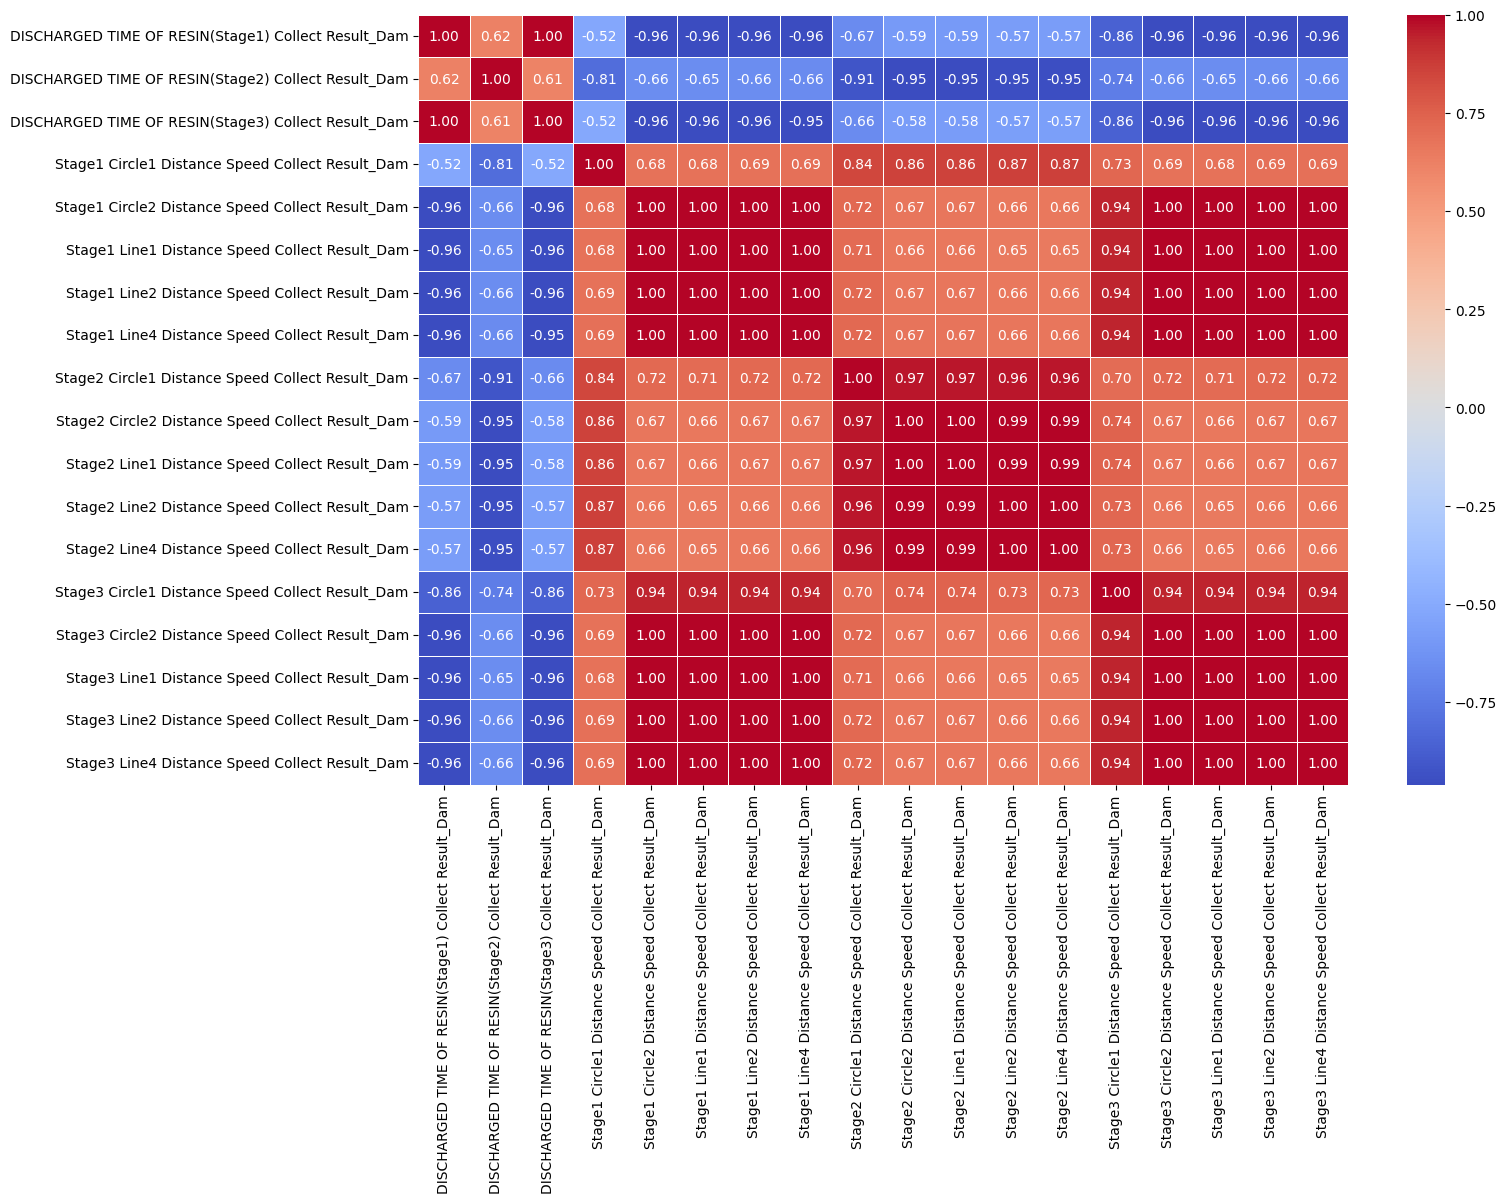

In [12]:
# 관심 있는 두 그룹의 칼럼들을 리스트로 정의
group1_columns = [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
]

group2_columns = [
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 두 그룹의 칼럼들을 합쳐서 필터링
selected_columns = group1_columns + group2_columns
selected_data = train_data[selected_columns]

# 상관관계 행렬 계산
correlation_matrix = selected_data.corr()

# 히트맵으로 상관관계 행렬 시각화
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.show()

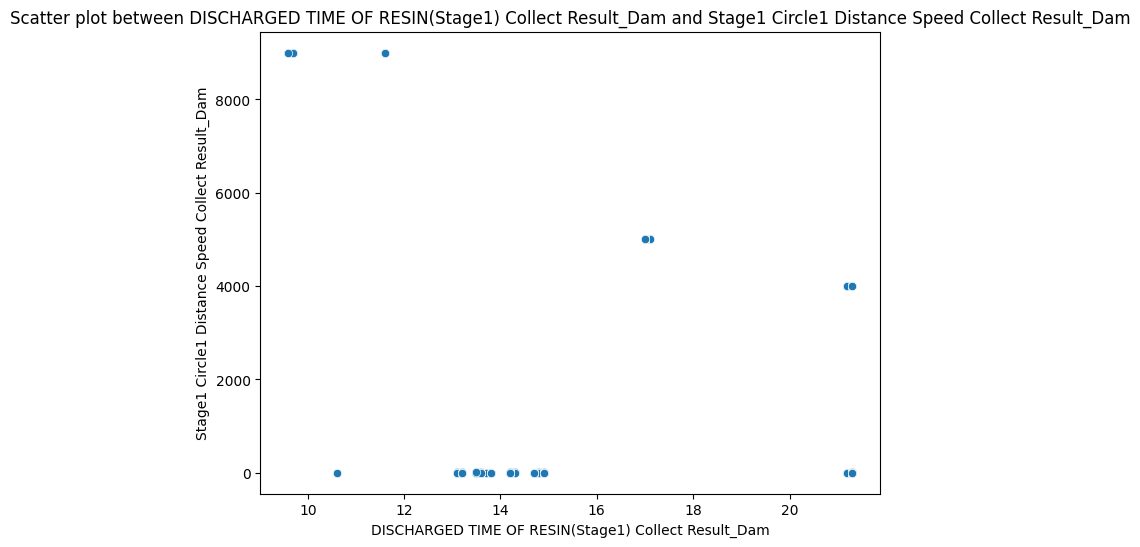

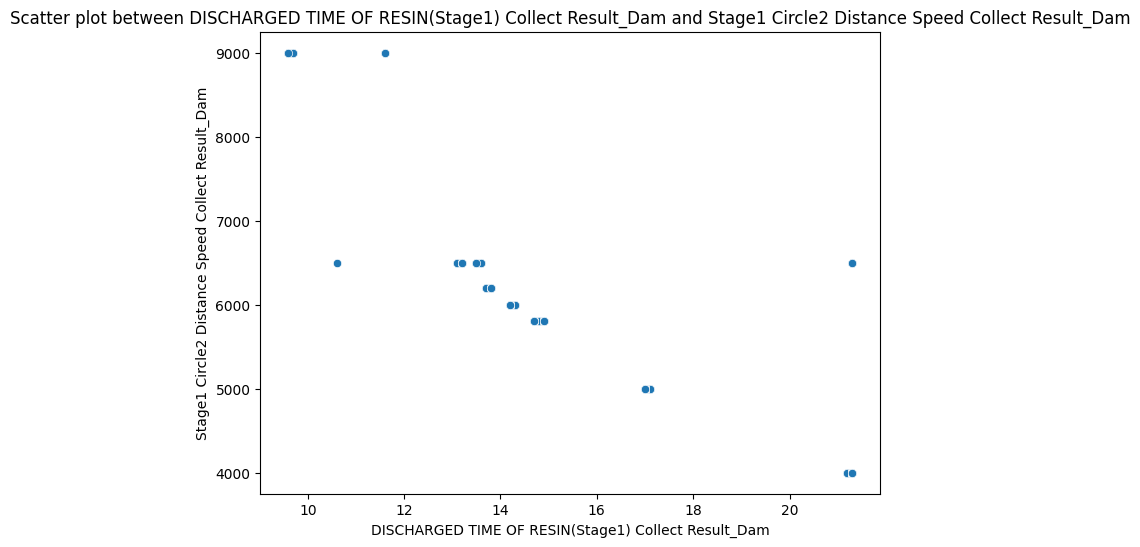

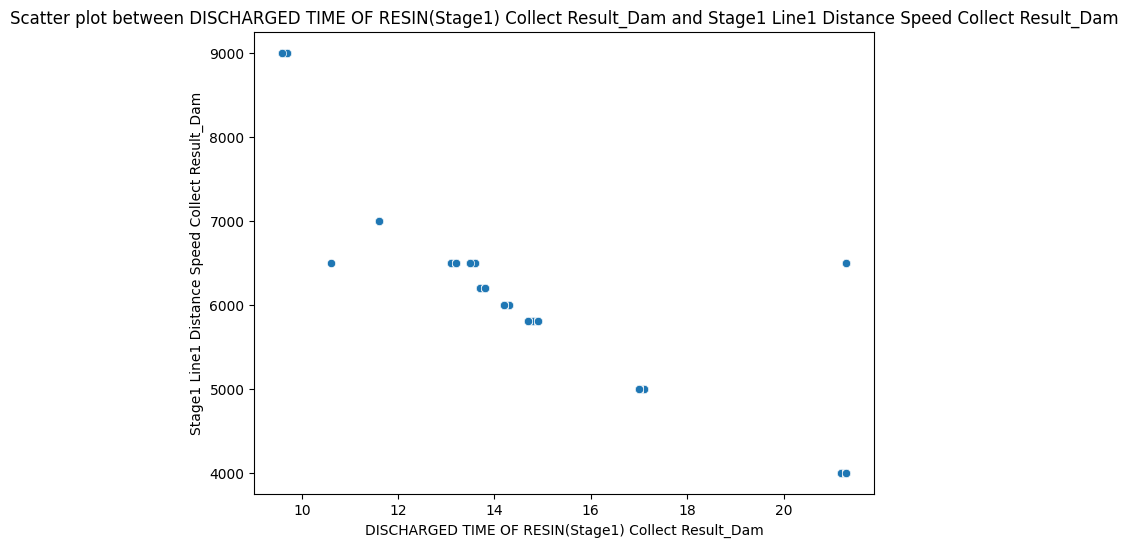

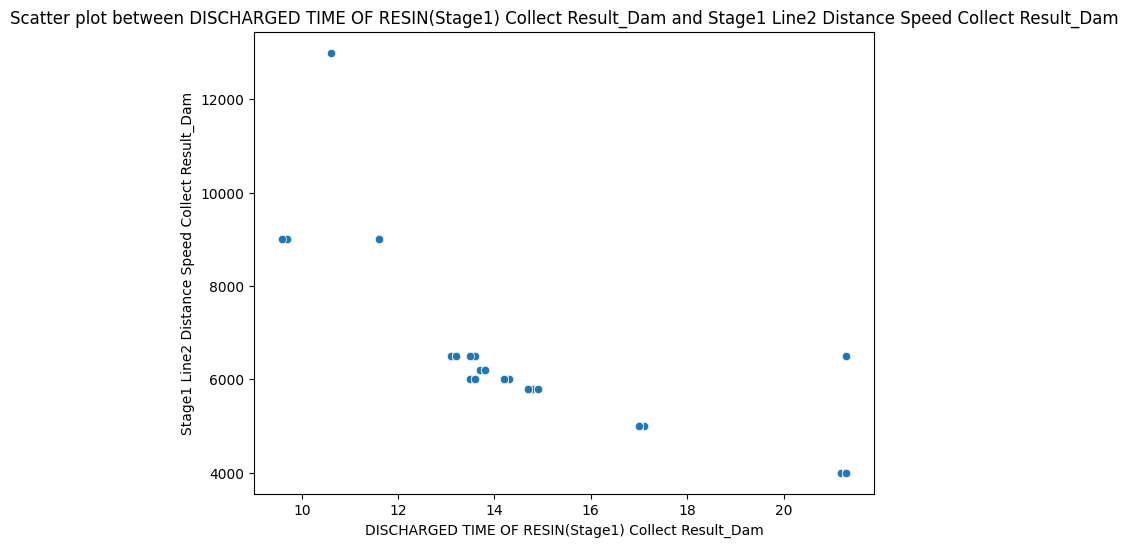

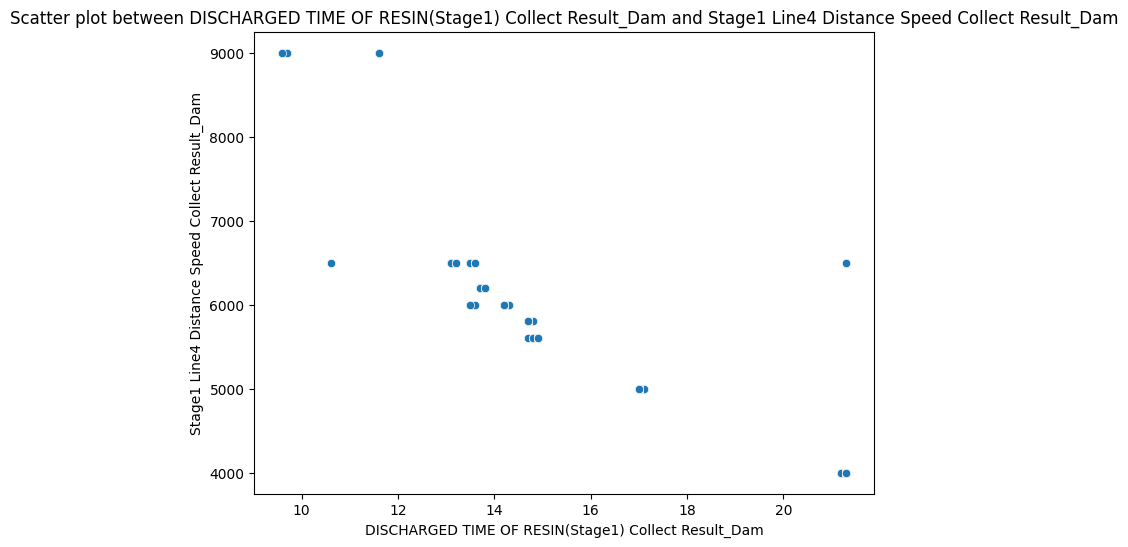

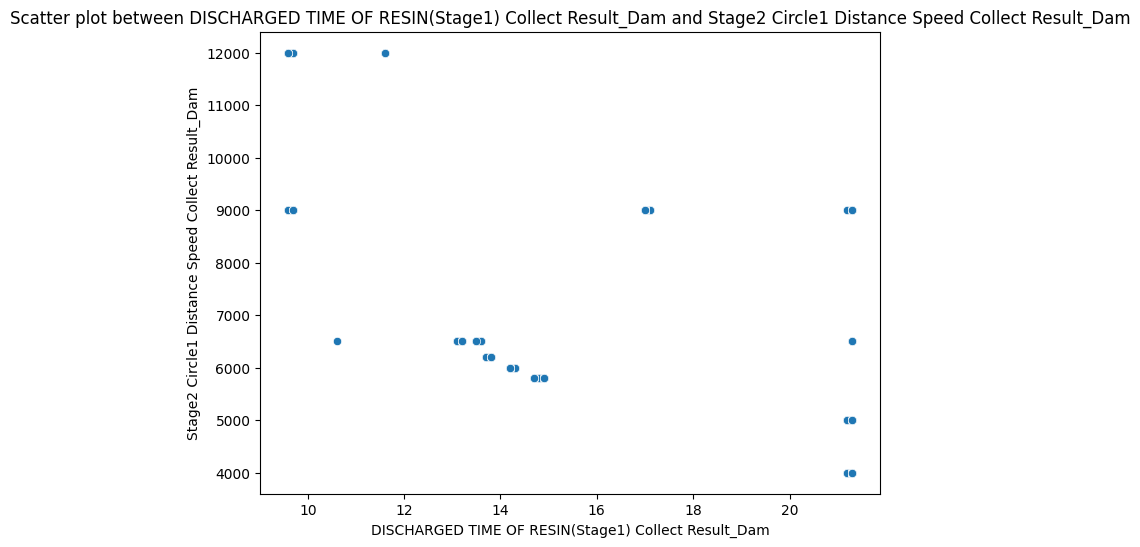

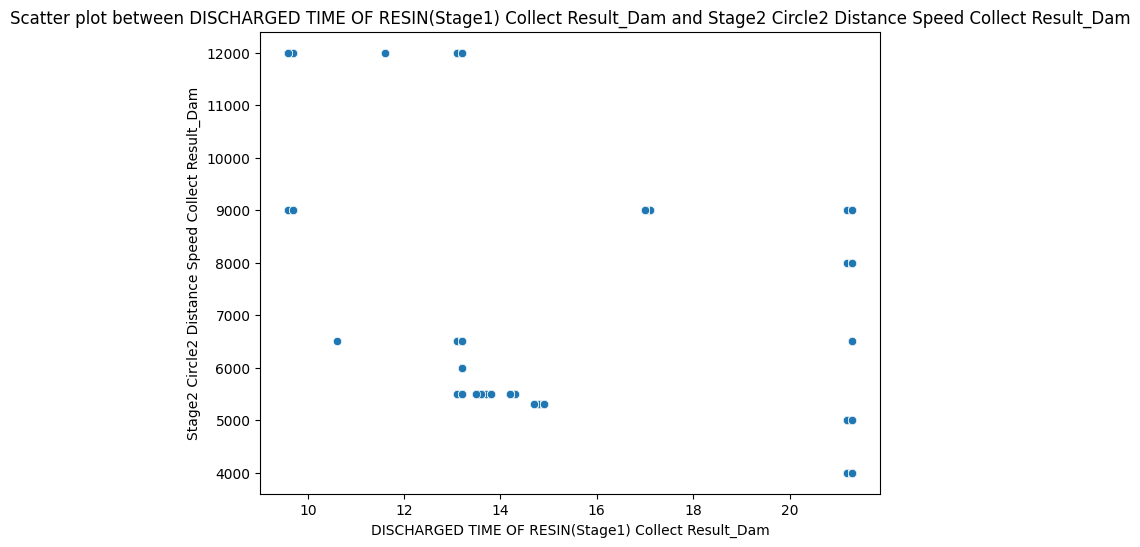

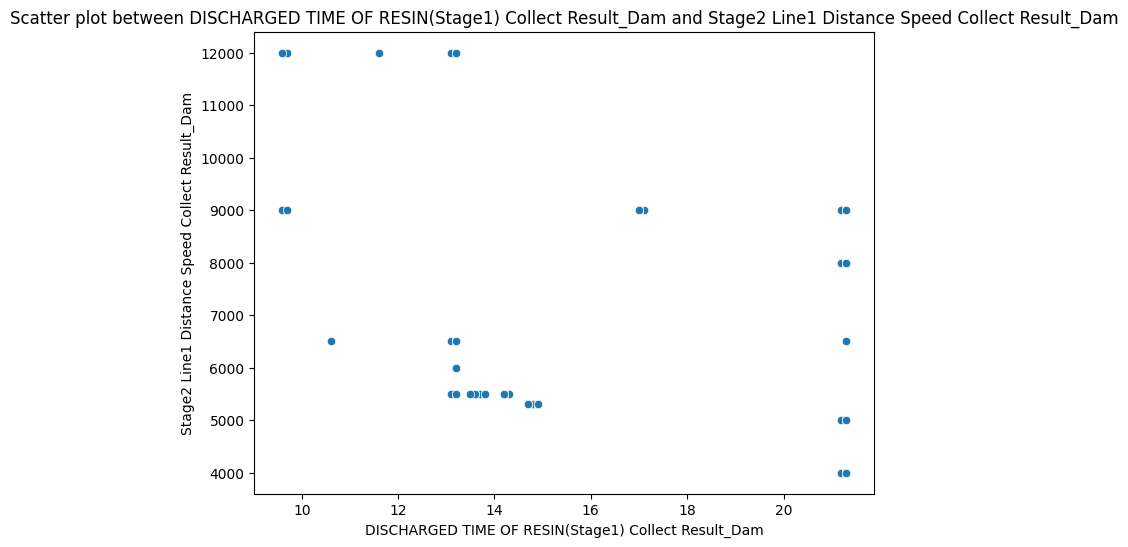

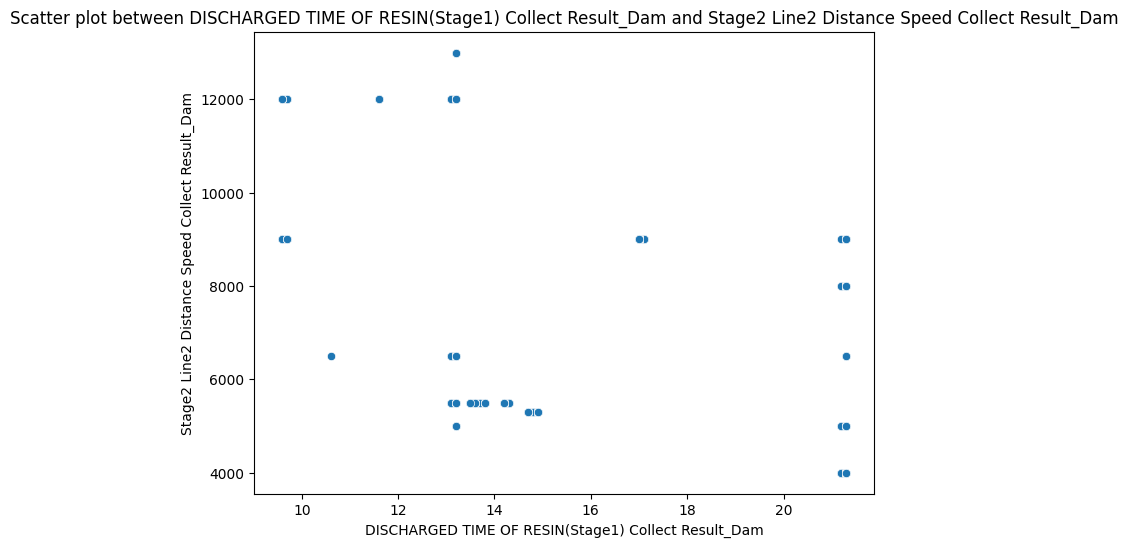

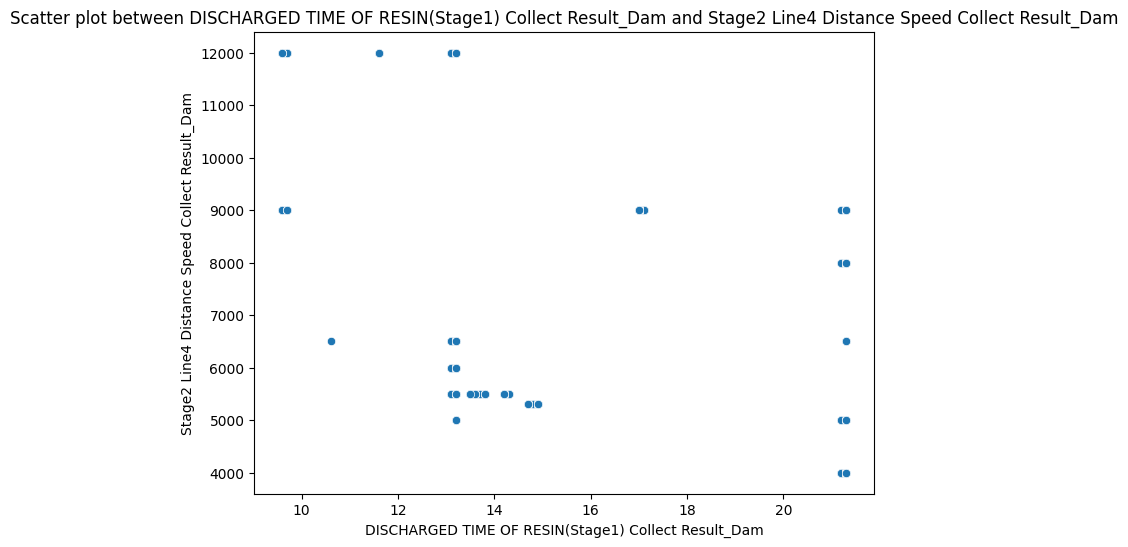

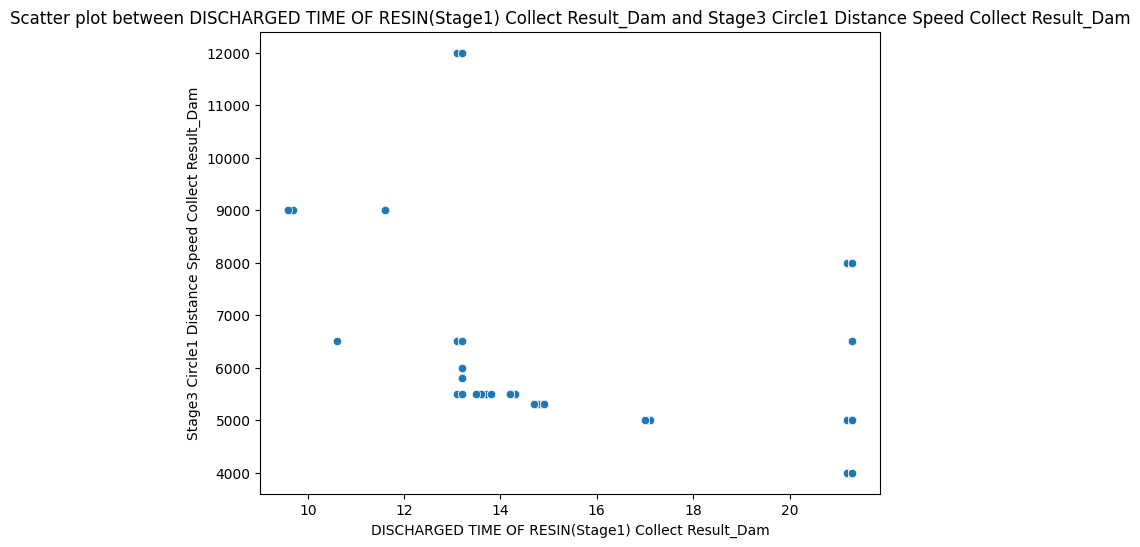

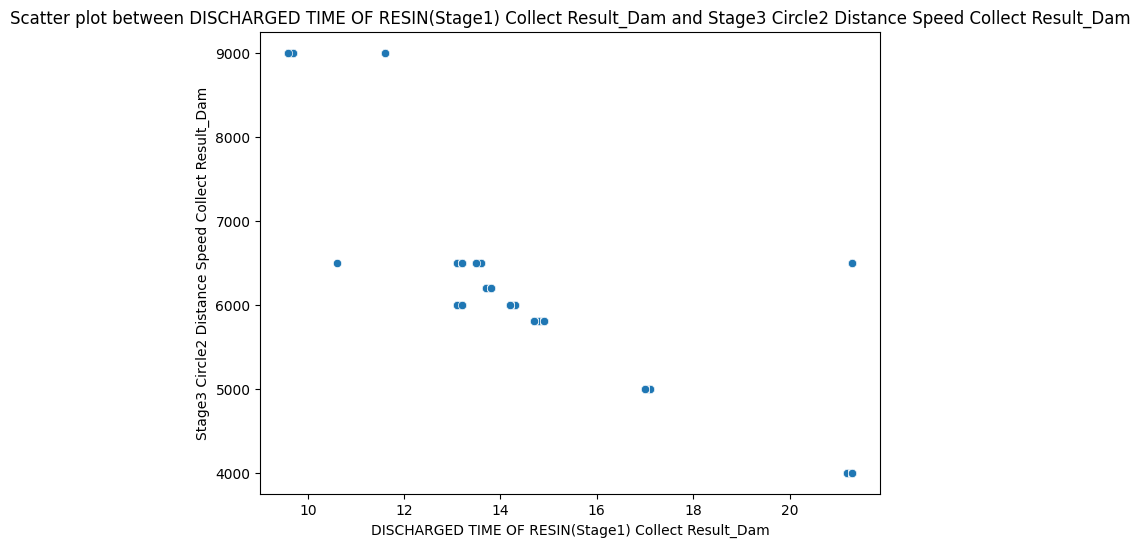

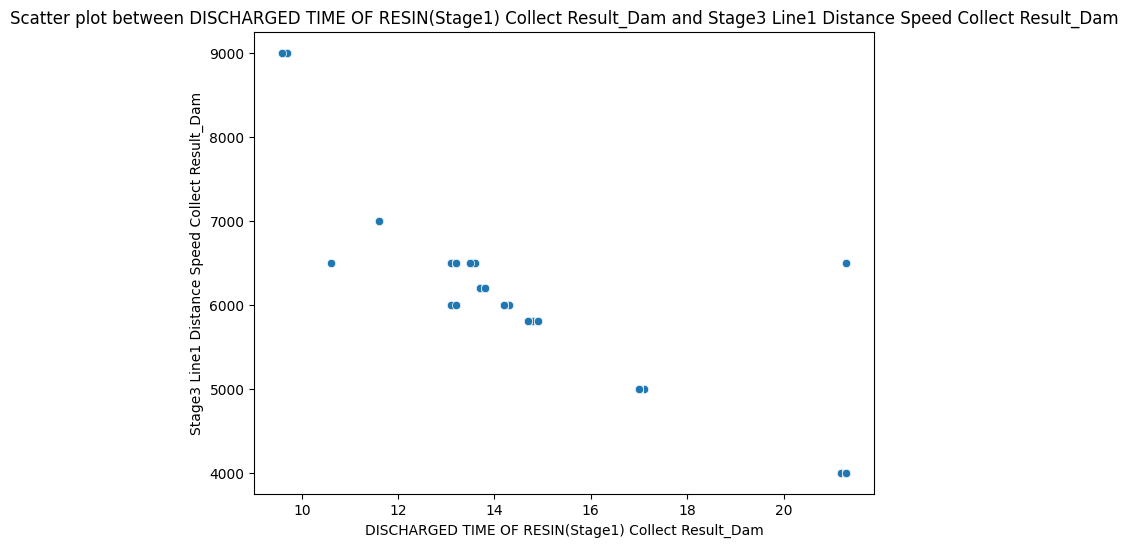

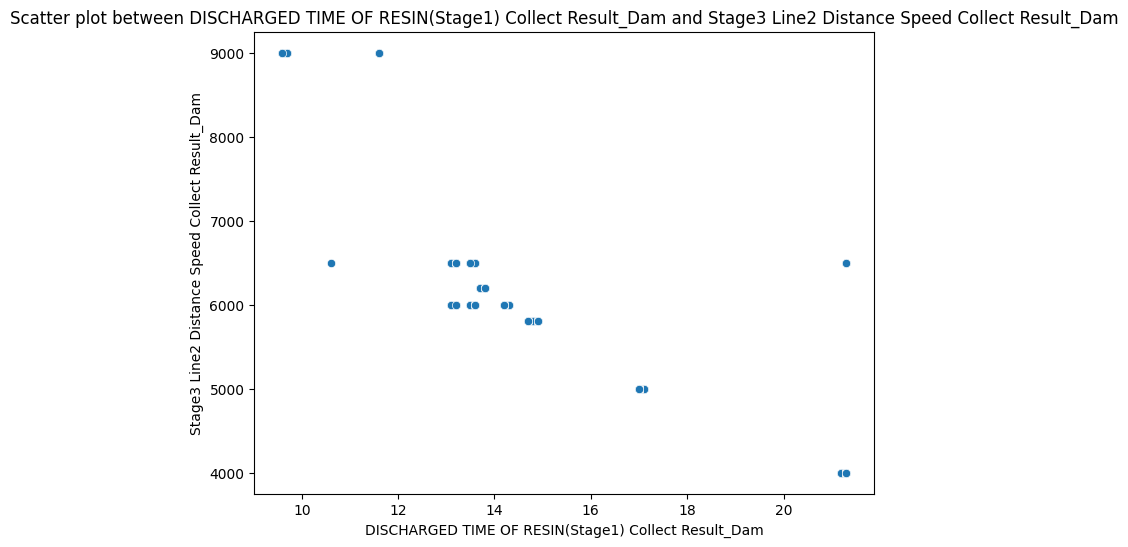

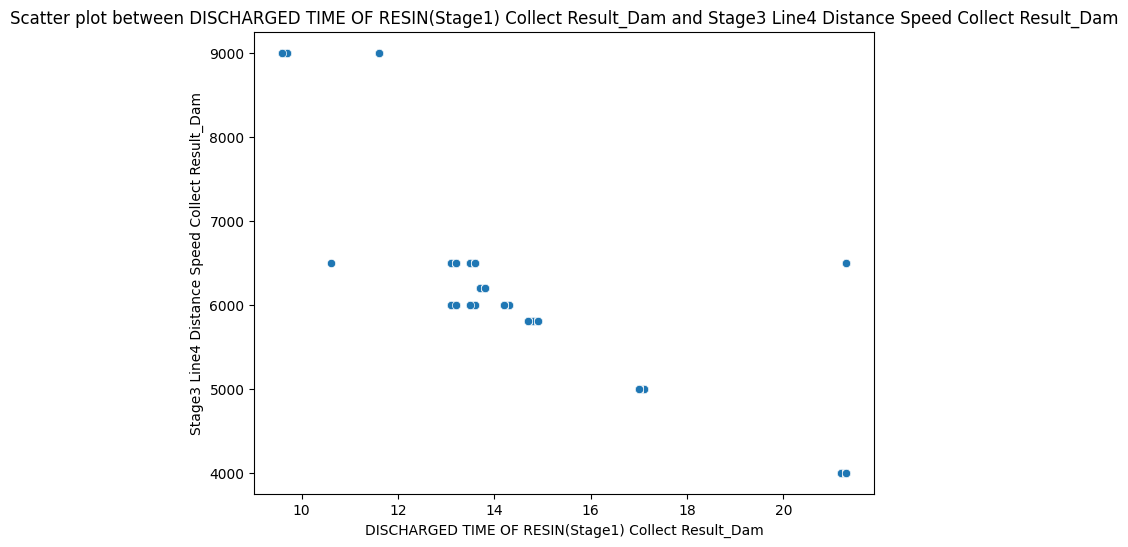

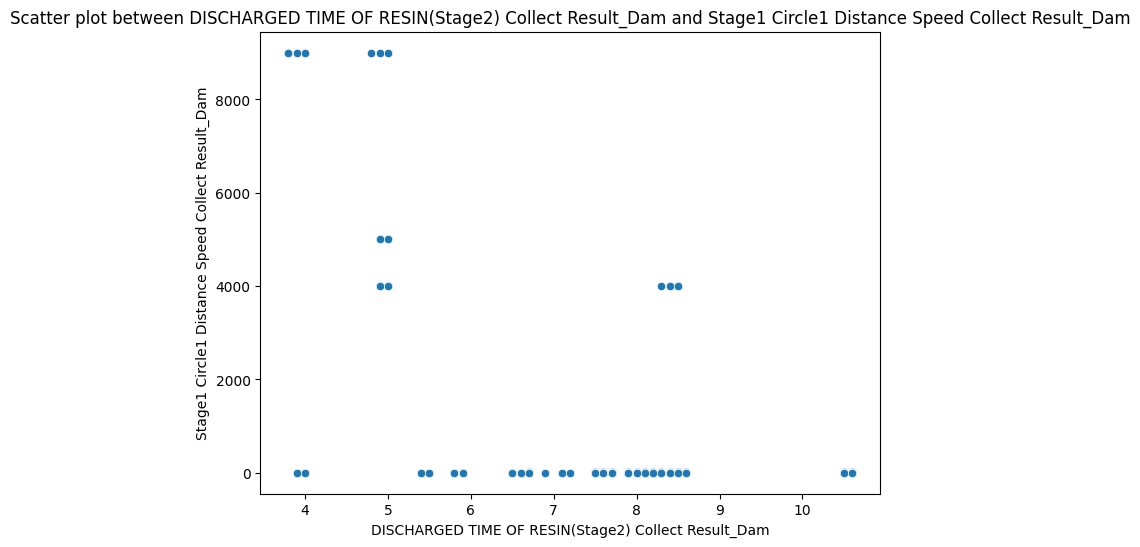

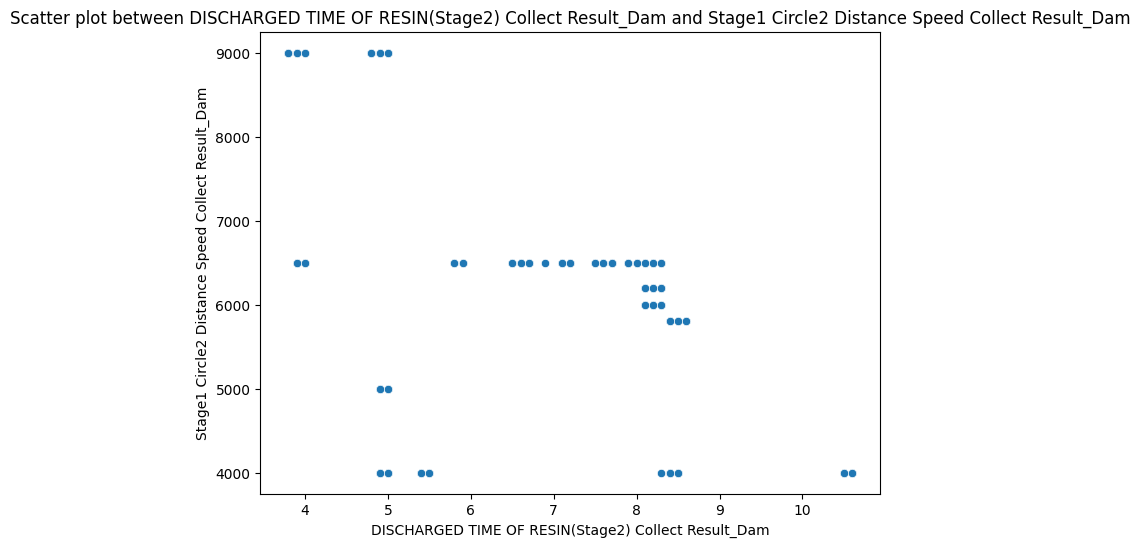

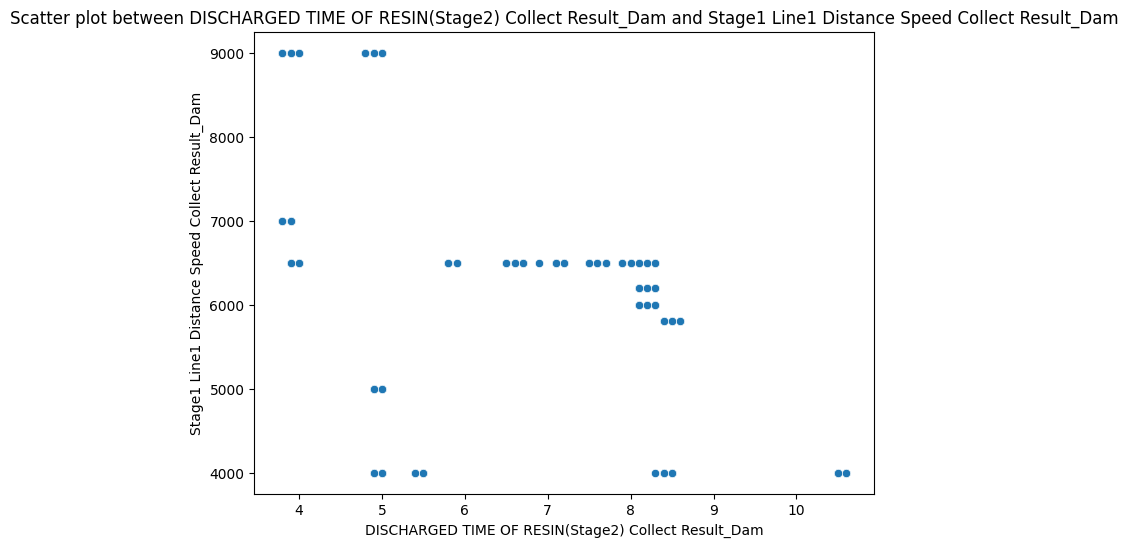

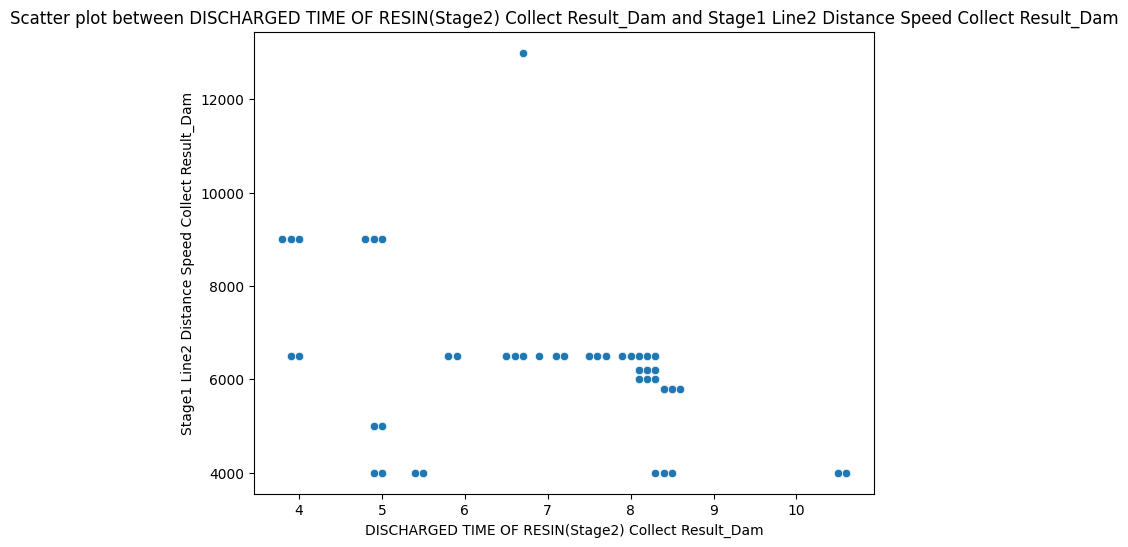

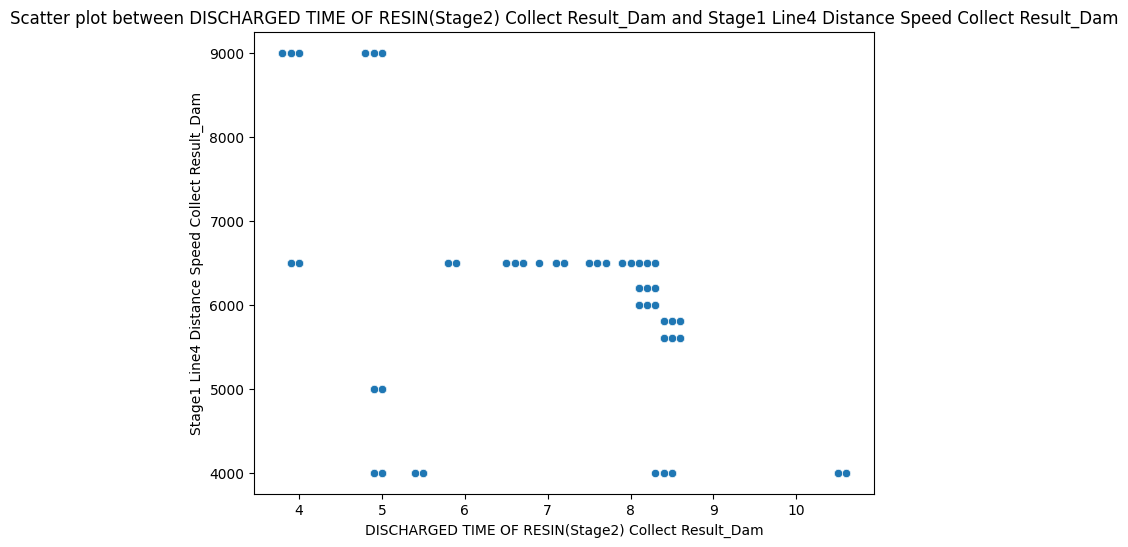

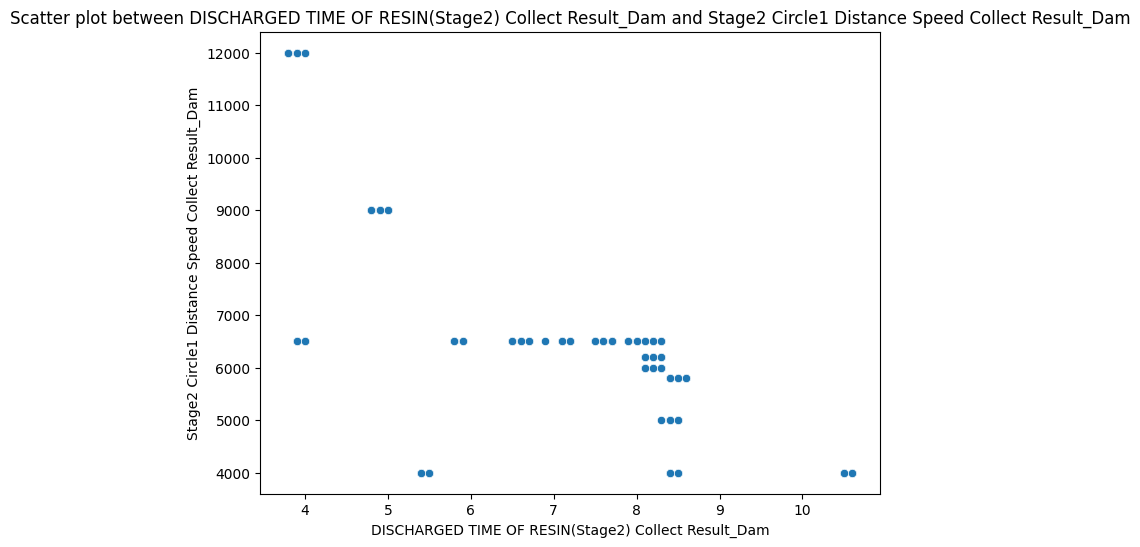

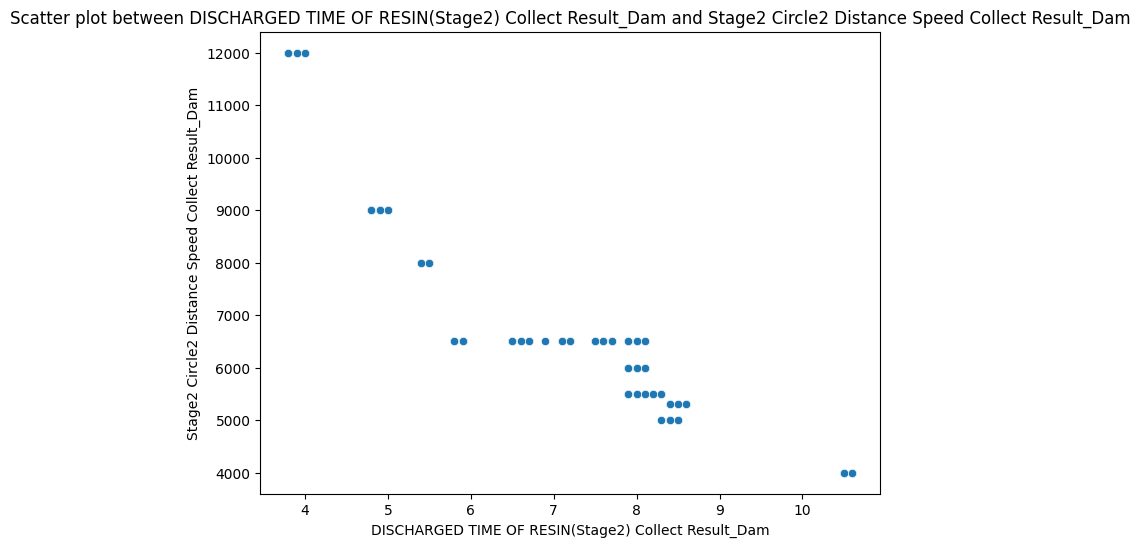

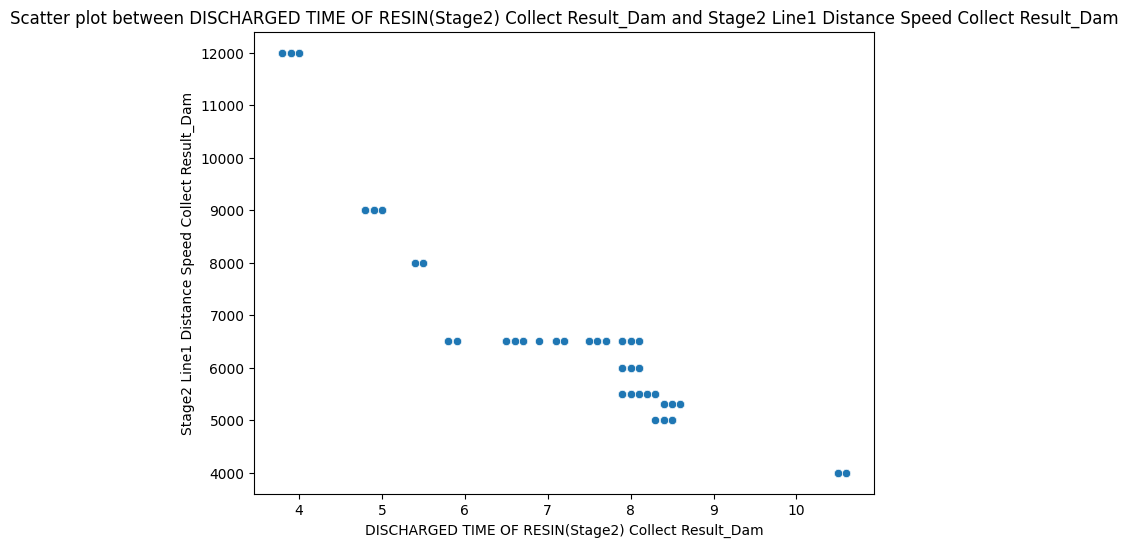

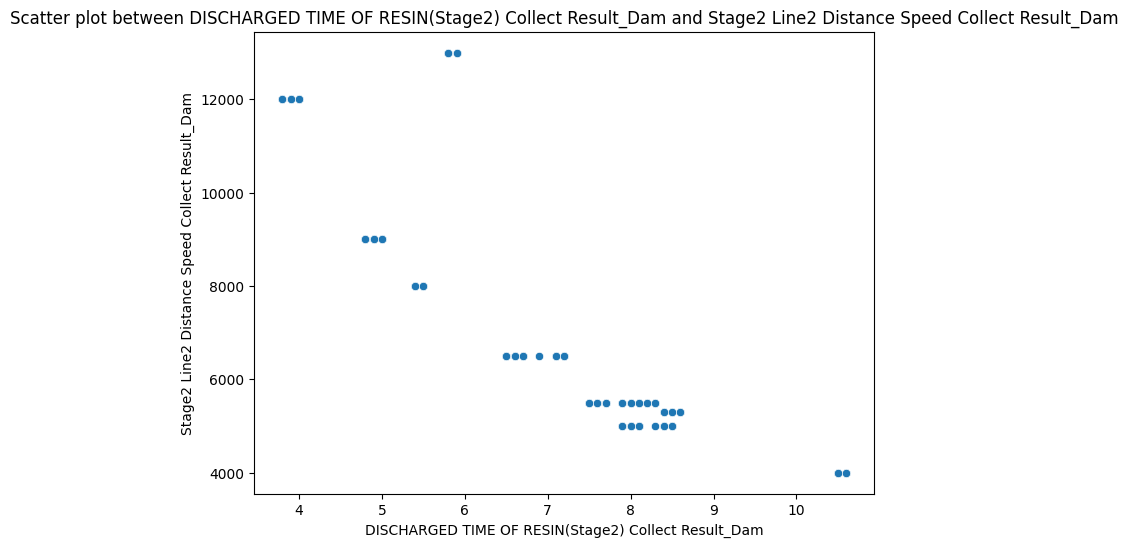

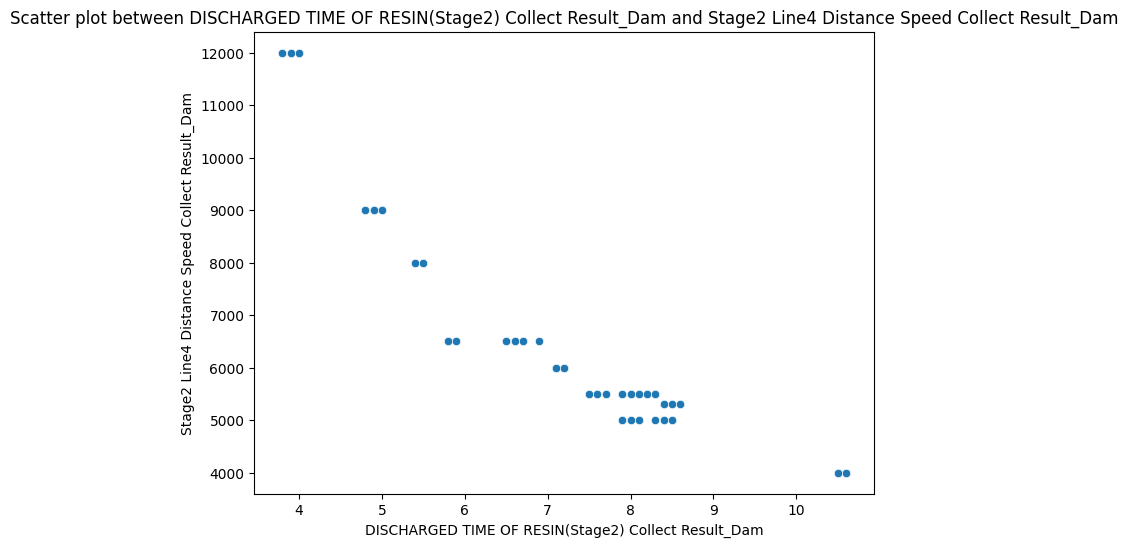

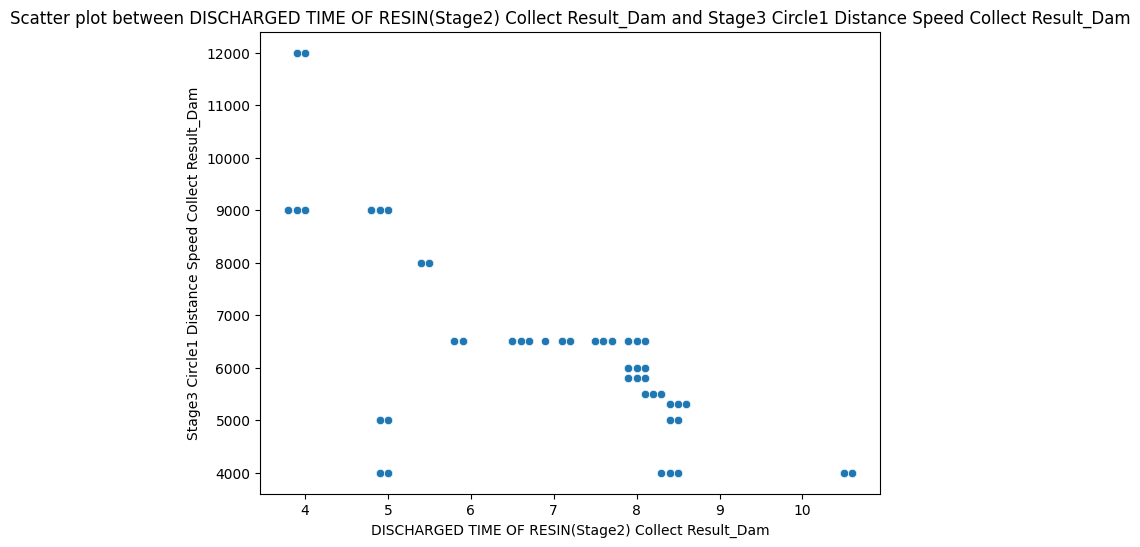

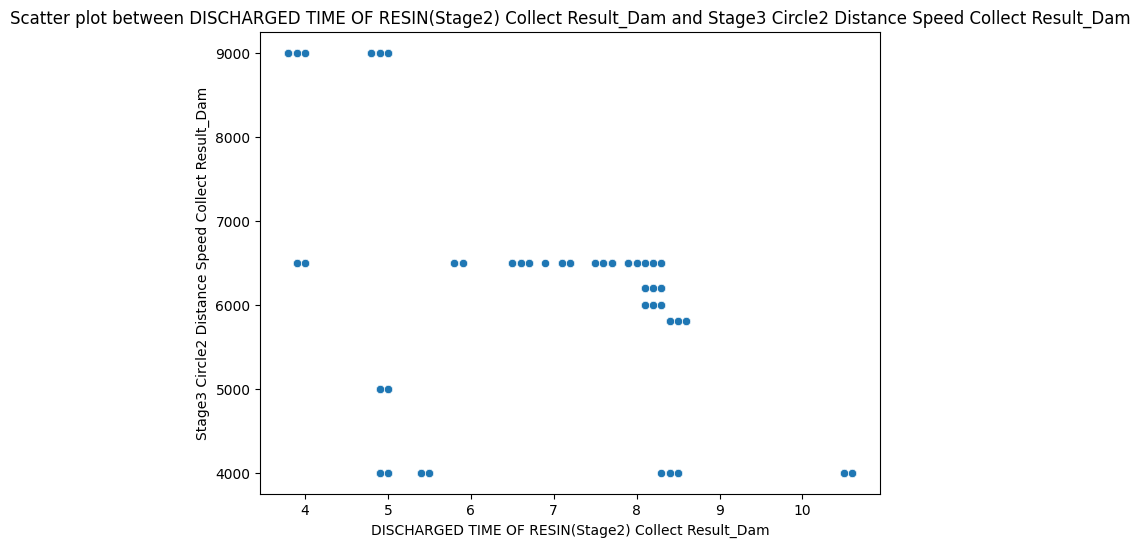

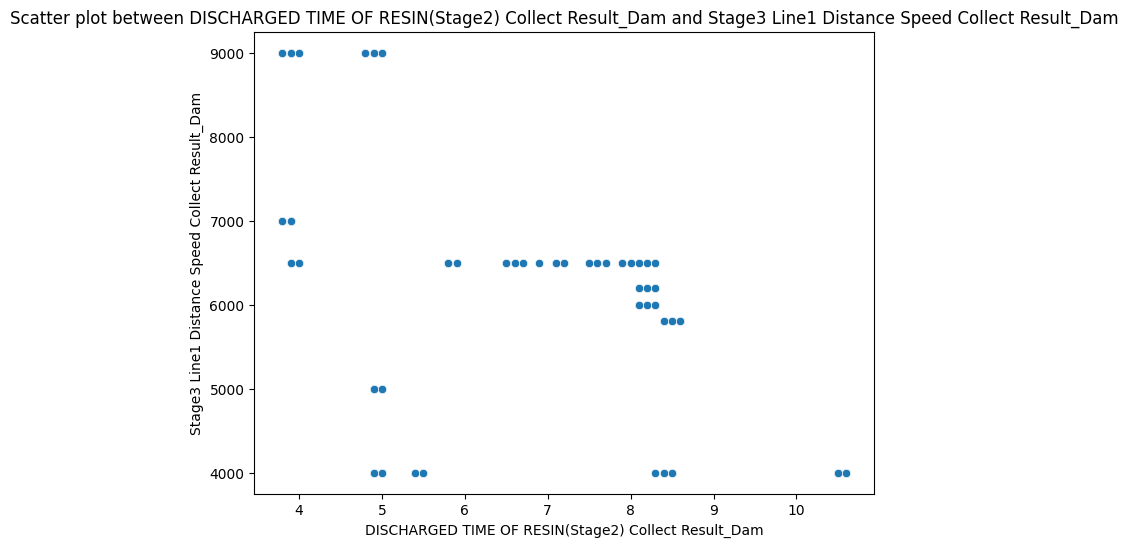

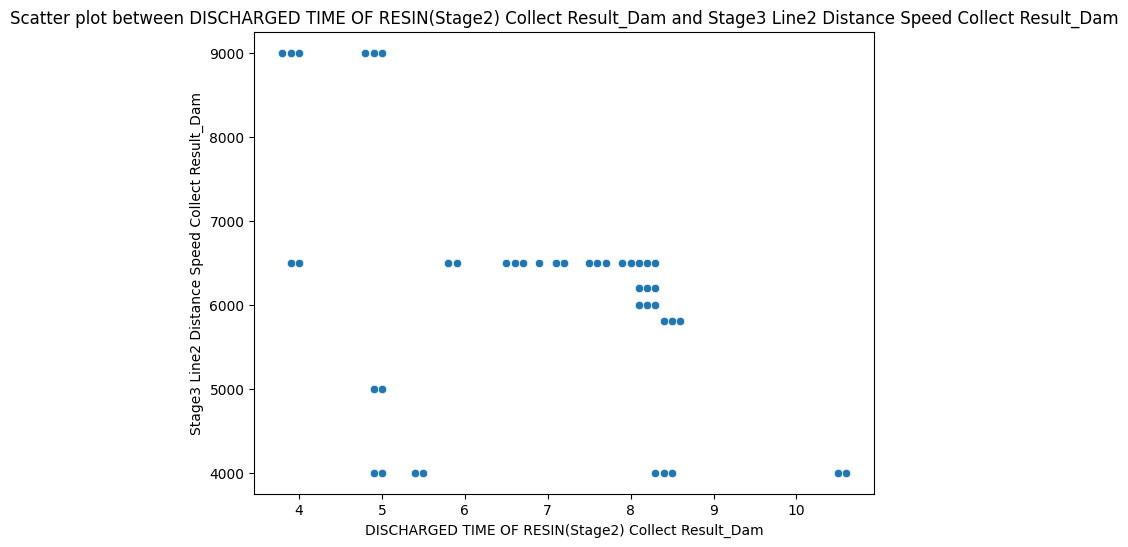

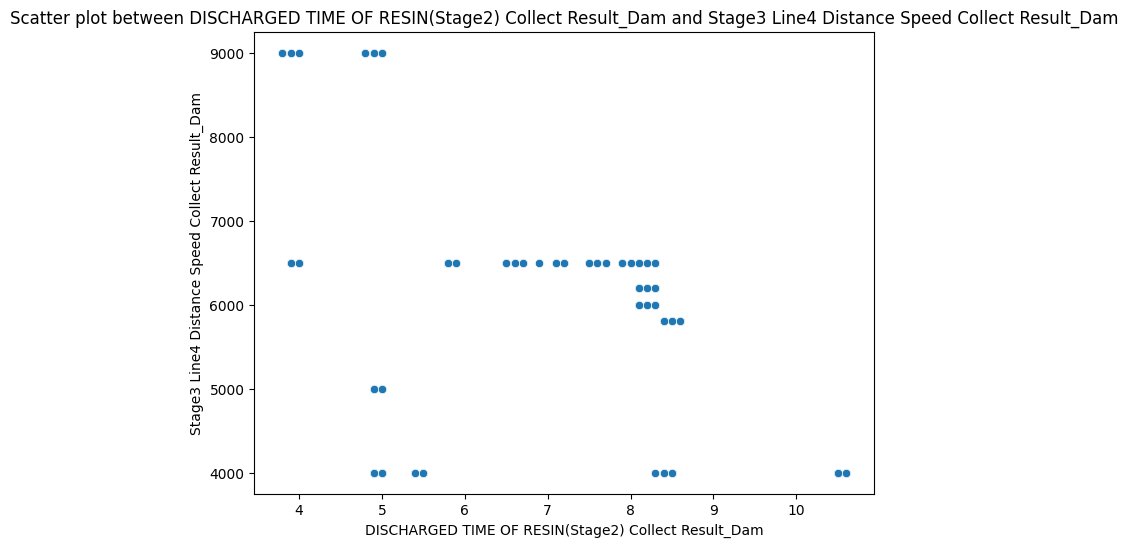

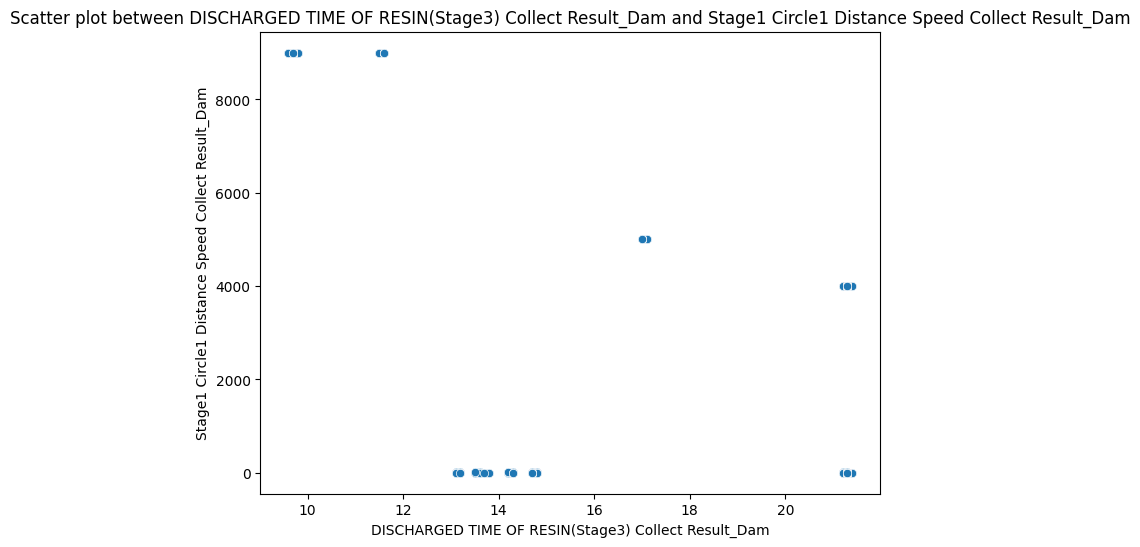

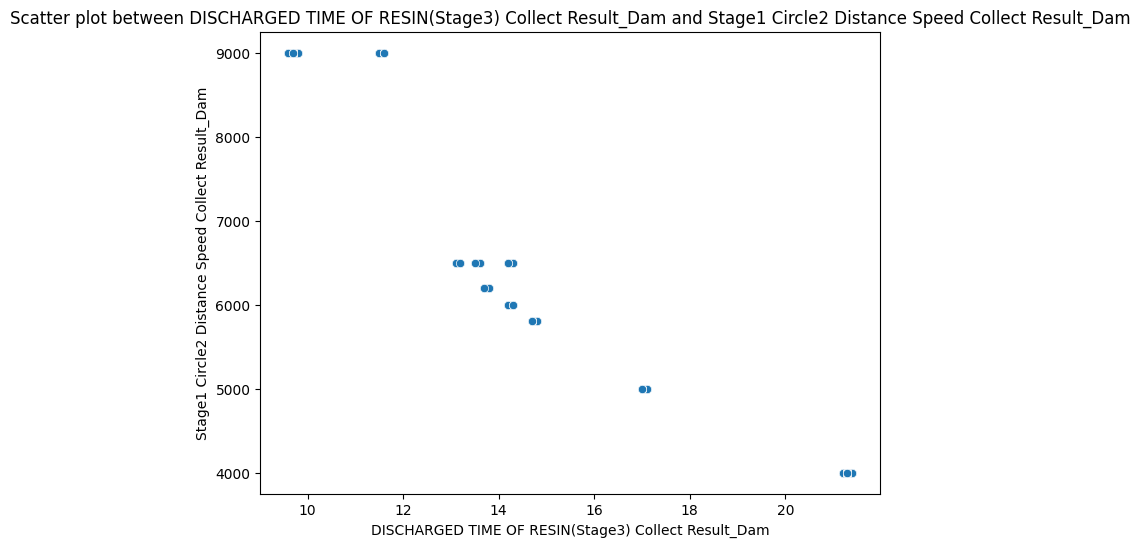

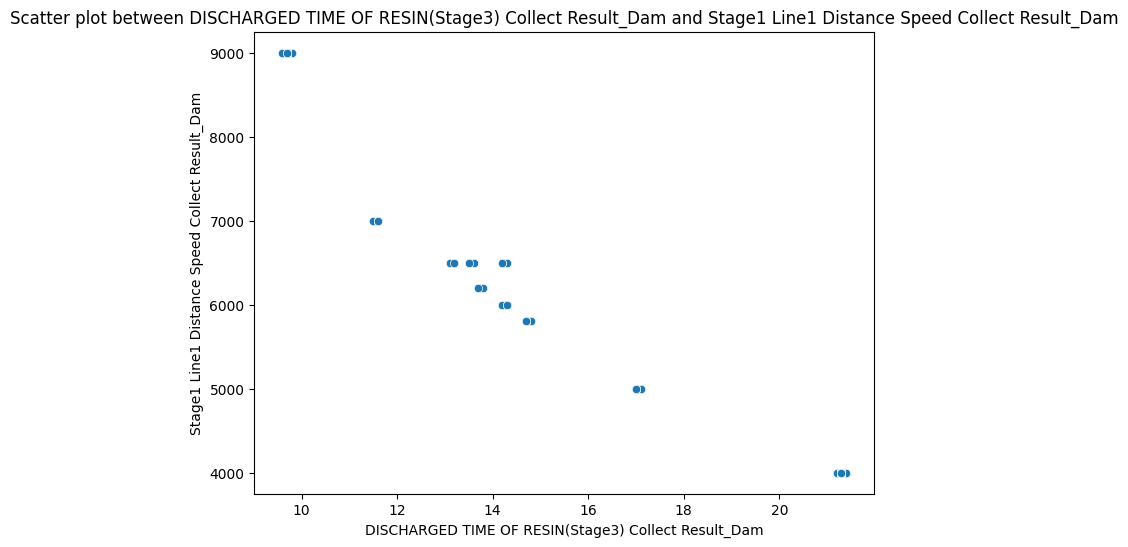

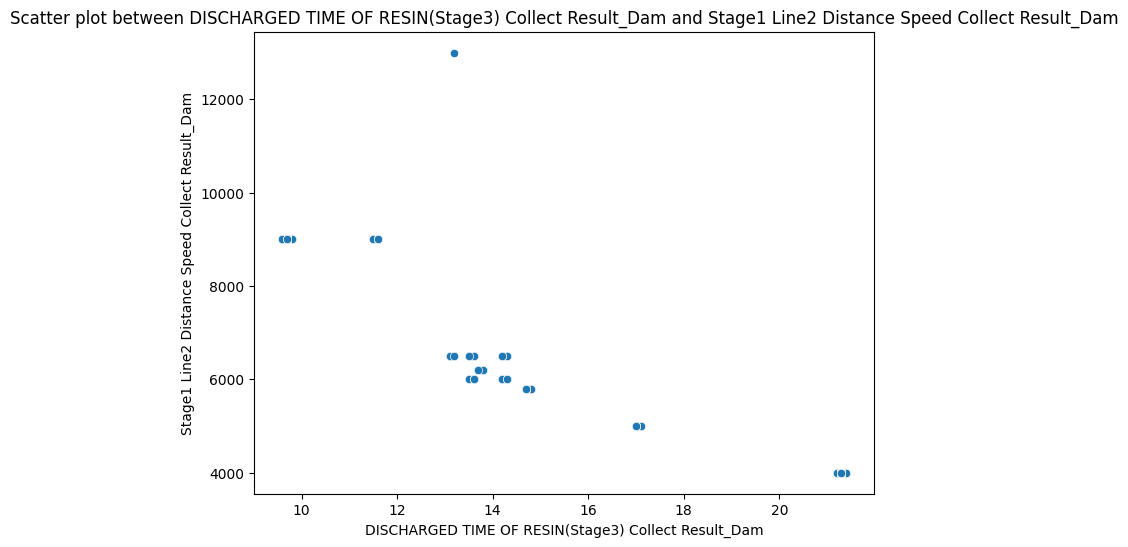

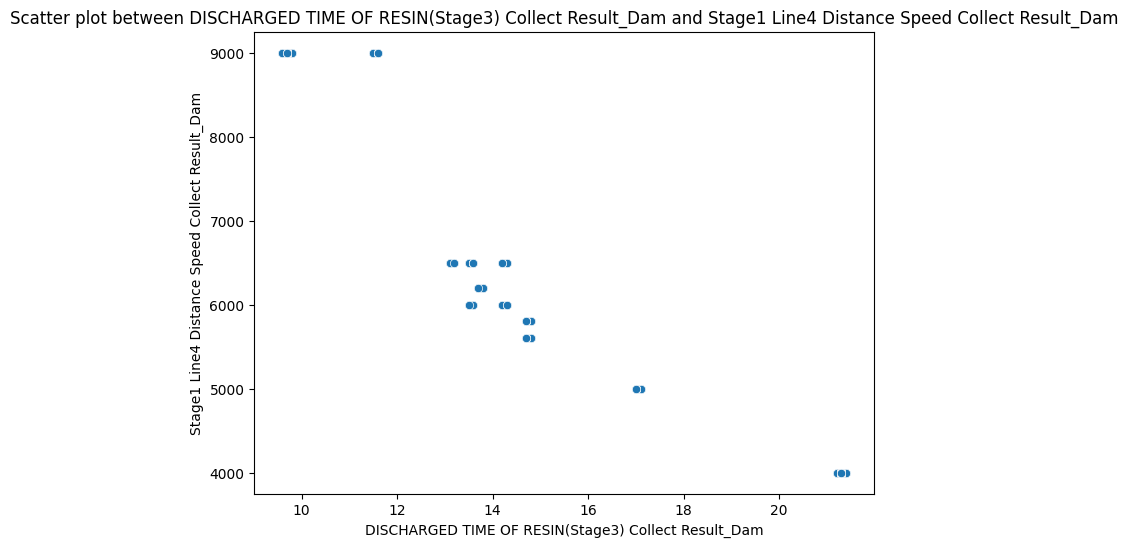

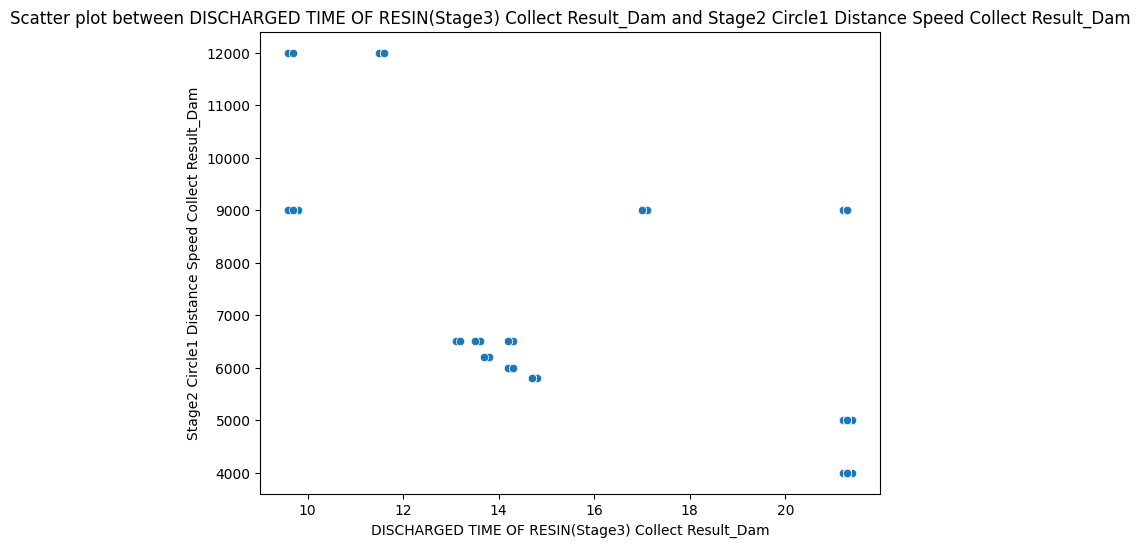

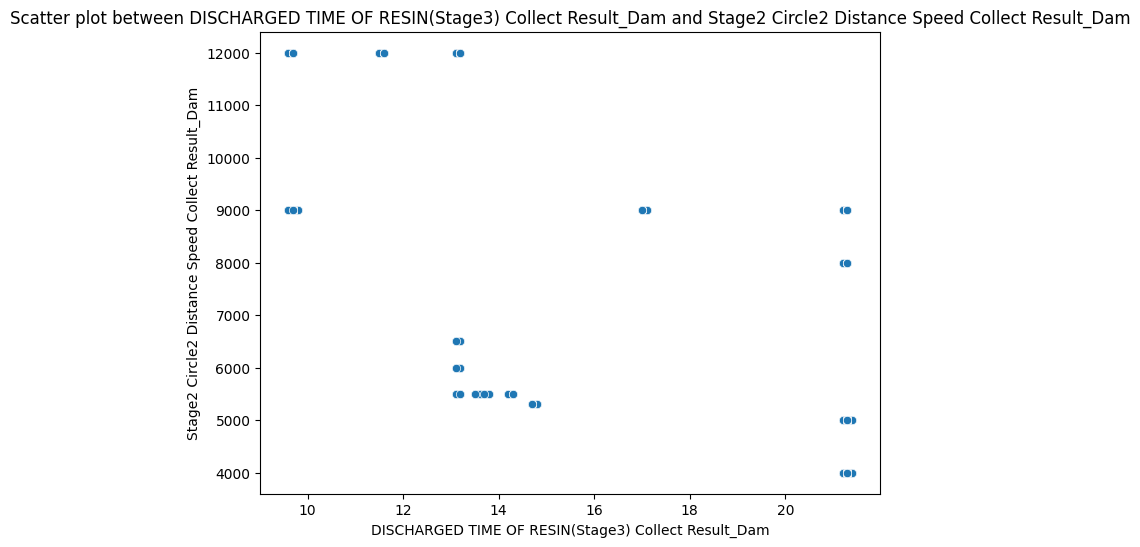

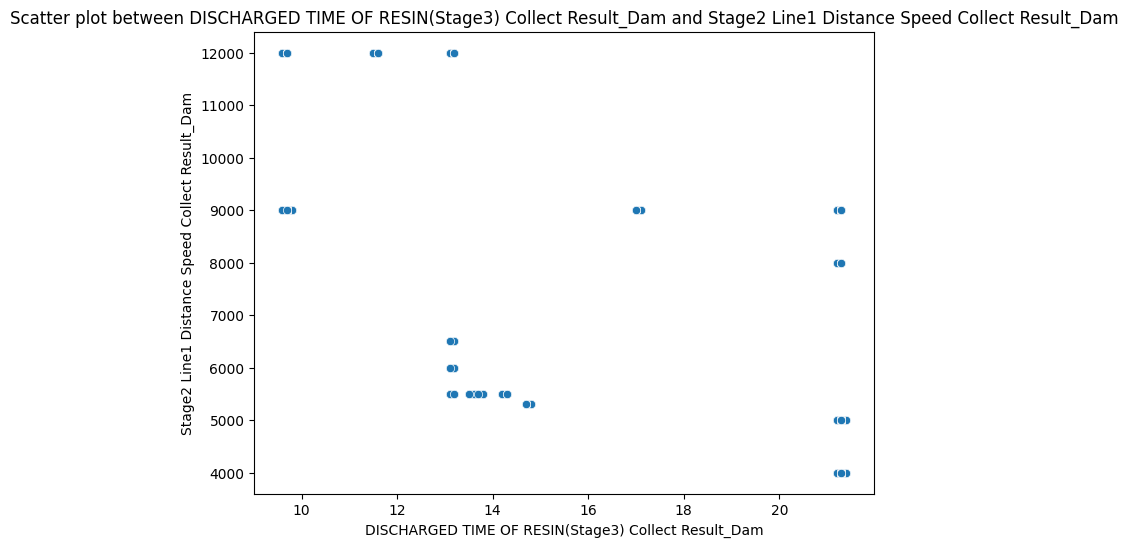

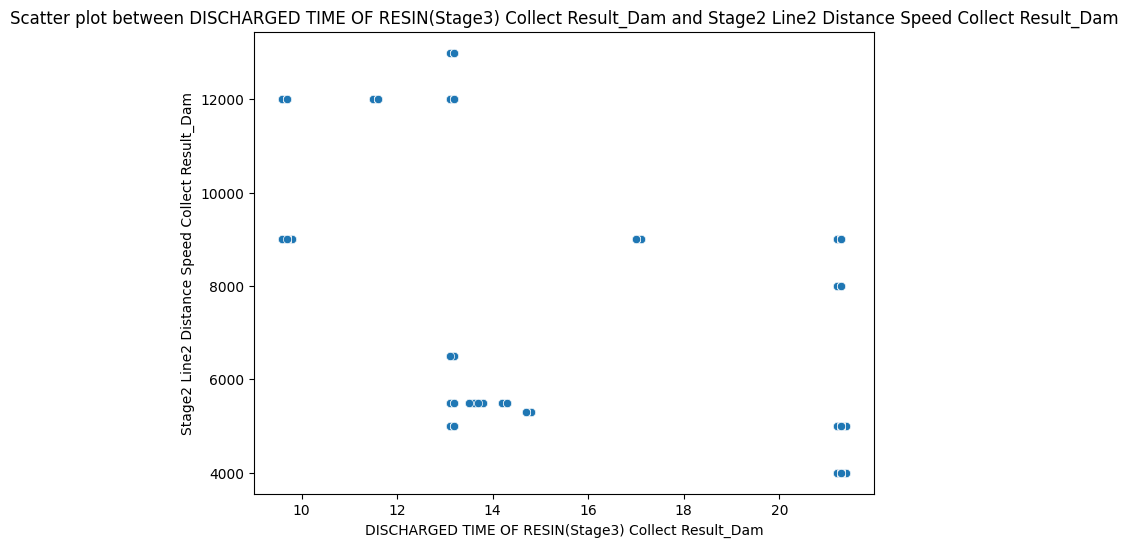

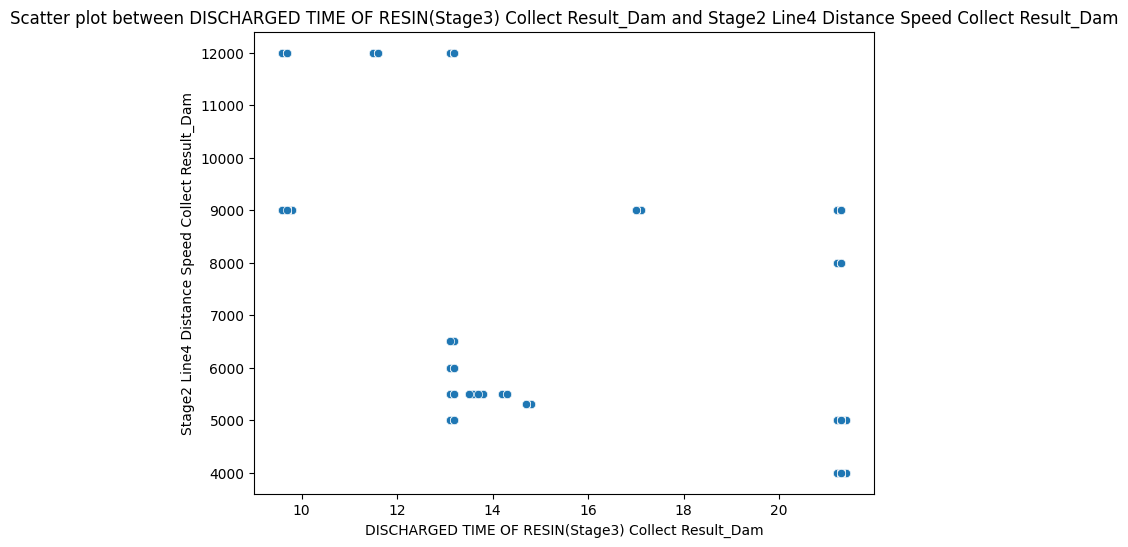

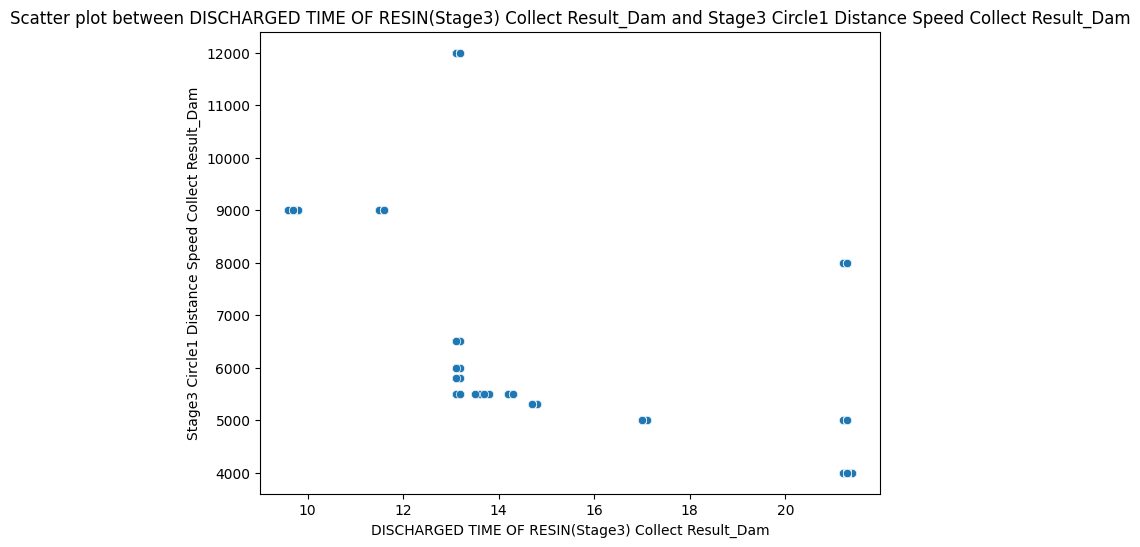

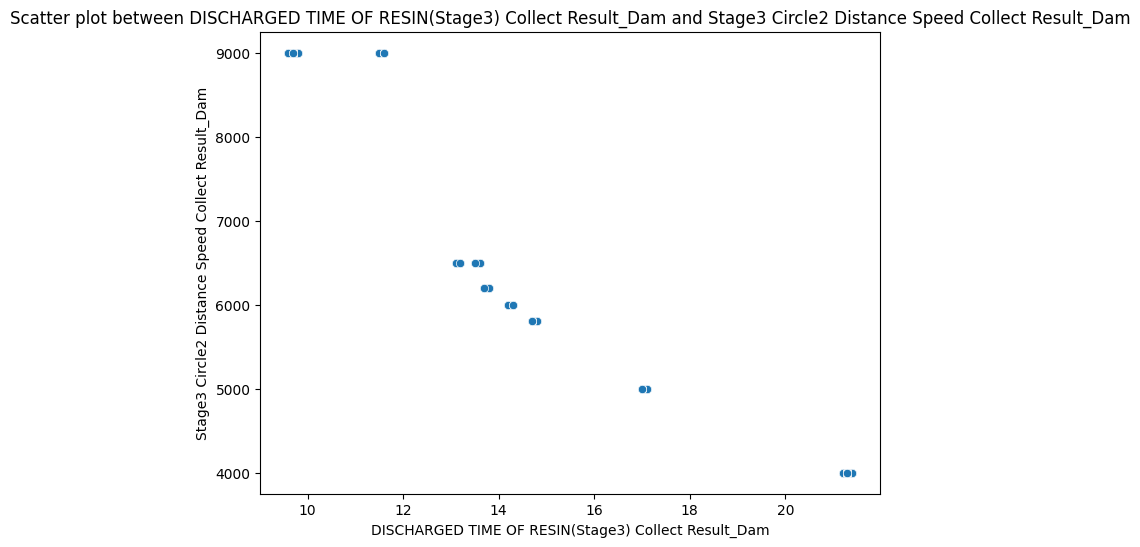

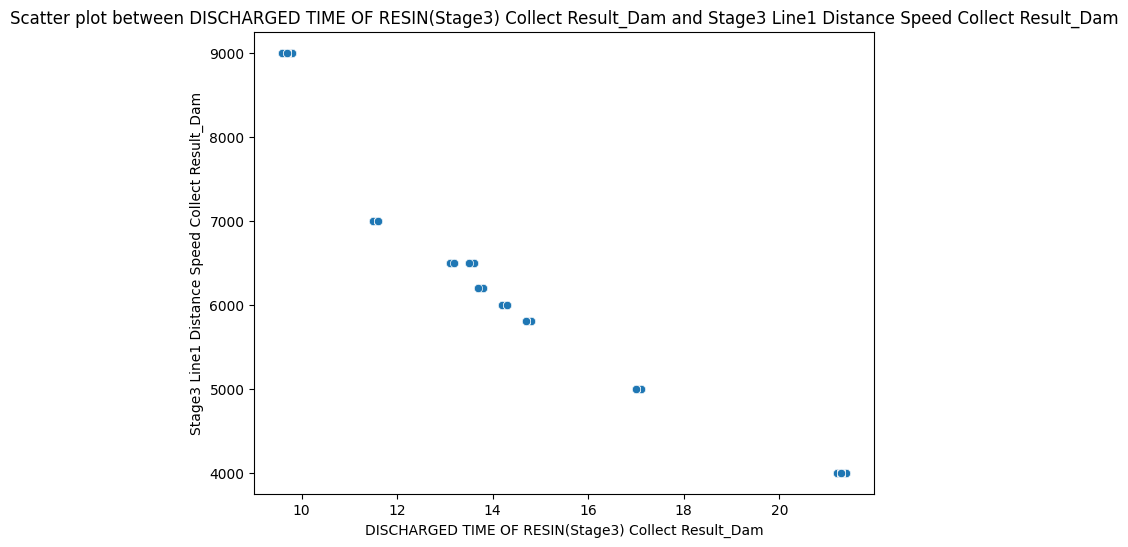

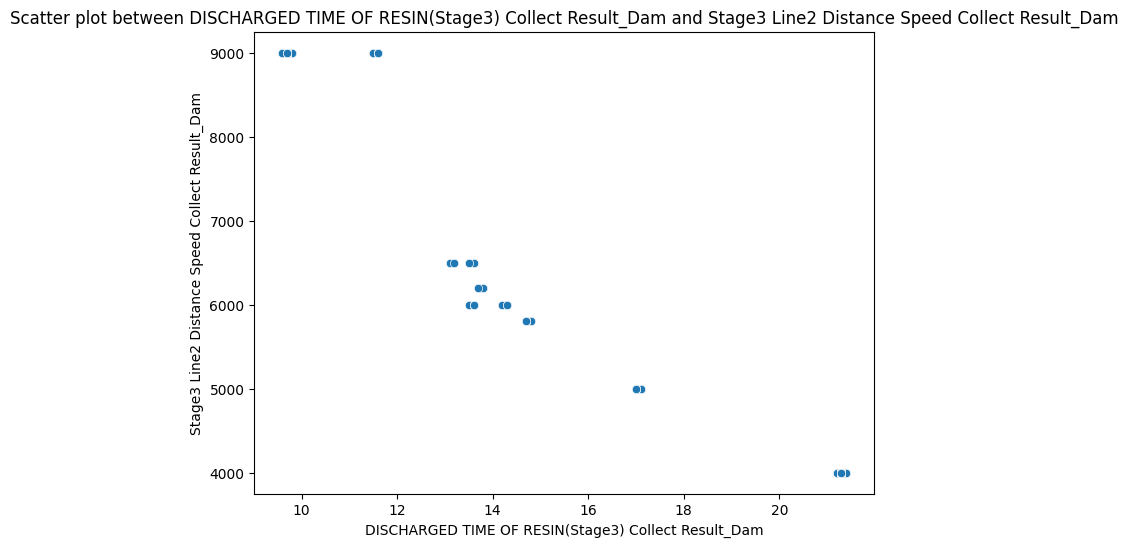

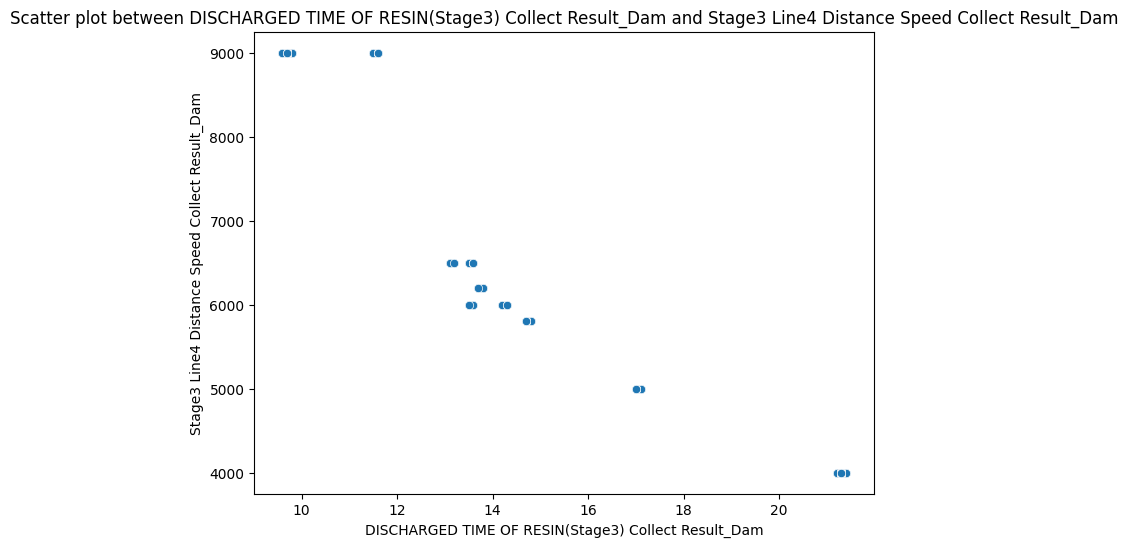

In [76]:
# 그룹 1과 그룹 2의 칼럼들 간의 산점도 그리기
for col1 in group1_columns:
    for col2 in group2_columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=train_data, x=col1, y=col2)
        plt.title(f'Scatter plot between {col1} and {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()

/tmp/ipykernel_55/3860996432.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(1 - correlation_matrix, method='ward')


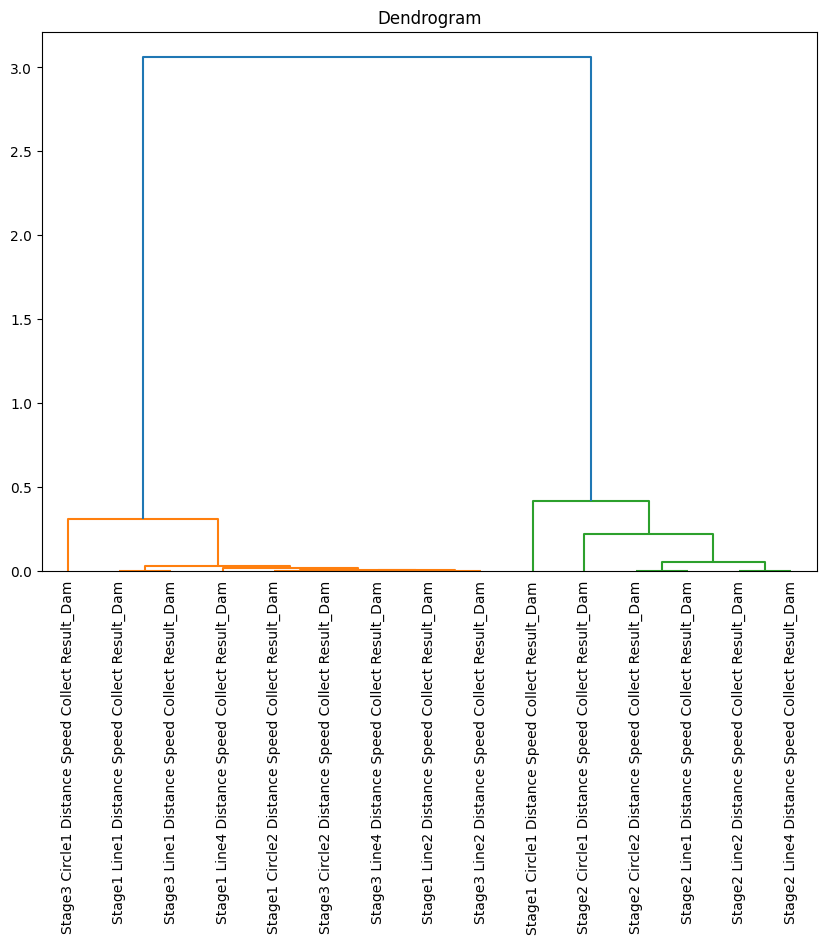

In [13]:
# 예시: 상관계수 행렬 계산
correlation_matrix = train_data[group2_columns].corr().values

# 계층적 클러스터링을 위한 linkage 계산
linkage_matrix = sch.linkage(1 - correlation_matrix, method='ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix, labels=group2_columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram")
plt.show()

In [14]:
from scipy.cluster.hierarchy import fcluster

In [15]:
# 임계값에 따라 클러스터를 생성합니다.
threshold = 0.25 
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# 클러스터 결과 출력
clustered_variables = pd.DataFrame({'Variable': group2_columns, 'Cluster': clusters})
print(clustered_variables)

                                            Variable  Cluster
0   Stage1 Circle1 Distance Speed Collect Result_Dam        4
1   Stage1 Circle2 Distance Speed Collect Result_Dam        1
2     Stage1 Line1 Distance Speed Collect Result_Dam        1
3     Stage1 Line2 Distance Speed Collect Result_Dam        1
4     Stage1 Line4 Distance Speed Collect Result_Dam        1
5   Stage2 Circle1 Distance Speed Collect Result_Dam        3
6   Stage2 Circle2 Distance Speed Collect Result_Dam        3
7     Stage2 Line1 Distance Speed Collect Result_Dam        3
8     Stage2 Line2 Distance Speed Collect Result_Dam        3
9     Stage2 Line4 Distance Speed Collect Result_Dam        3
10  Stage3 Circle1 Distance Speed Collect Result_Dam        2
11  Stage3 Circle2 Distance Speed Collect Result_Dam        1
12    Stage3 Line1 Distance Speed Collect Result_Dam        1
13    Stage3 Line2 Distance Speed Collect Result_Dam        1
14    Stage3 Line4 Distance Speed Collect Result_Dam        1


### 파생변수 추가

In [16]:
stage1_and_3 = ['Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam']

In [17]:
train_data, pca_result_stage1_and_3 = apply_pca(train_data, stage1_and_3, 1, prefix='stage1_and_3')

In [18]:
stage2 = ['Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam']

In [19]:
train_data, pca_result_stage2 = apply_pca(train_data, stage2, 1, prefix='stage2_')

In [20]:
train_data

Model.Suffix_Dam Workorder_Dam  CURE END POSITION Θ Collect Result_Dam  \
0          AJX75334505    4F1XA938-1                                     -90   
1          AJX75334505    3KPM0016-2                                     -90   
2          AJX75334501    4E1X9167-1                                      90   
3          AJX75334501    3K1X0057-1                                      90   
4          AJX75334501    3HPM0007-1                                     -90   
...                ...           ...                                     ...   
40501      AJX75334501    3J1XF434-2                                     -90   
40502      AJX75334501    4E1XC796-1                                      90   
40503      AJX75334501    4C1XD438-1                                     -90   
40504      AJX75334501    3I1XA258-1                                      90   
40505      AJX75334501    3G1XA501-1                                     -90   

       CURE SPEED Collect Result_Dam  \
0                                100   
1                                 70   
2                                 85   
3                                 70   
4                                 70   
...                              ...   
40501                             70   
40502                            100   
40503                            100   
40504                             70   
40505                             70   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   
...                                             ...   
40501                                            10   
40502                                            16   
40503                                            16   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.7     
...                                                  ...     
40501                                               17.0     
40502                                               14.9     
40503                                               14.2     
40504                                                9.7     
40505                                                9.6     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    8.4     
1                                                    4.9     
2                                                    8.5     
3                                                    8.4     
4                                                    4.9     
...                                                  ...     
40501                                                5.0     
40502                                            

### 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam' 하나 drop
* 두 변수 값이 동일해서 하나 drop

In [21]:
# 'CURE END POSITION Θ Collect Result_Dam' 변수를 제거하고 'CURE START POSITION Θ Collect Result_Dam'만 사용
train_data = train_data.drop(columns=['CURE END POSITION Θ Collect Result_Dam'])

In [22]:
train_data

Model.Suffix_Dam Workorder_Dam  CURE SPEED Collect Result_Dam  \
0          AJX75334505    4F1XA938-1                            100   
1          AJX75334505    3KPM0016-2                             70   
2          AJX75334501    4E1X9167-1                             85   
3          AJX75334501    3K1X0057-1                             70   
4          AJX75334501    3HPM0007-1                             70   
...                ...           ...                            ...   
40501      AJX75334501    3J1XF434-2                             70   
40502      AJX75334501    4E1XC796-1                            100   
40503      AJX75334501    4C1XD438-1                            100   
40504      AJX75334501    3I1XA258-1                             70   
40505      AJX75334501    3G1XA501-1                             70   

       CURE START POSITION Θ Collect Result_Dam  \
0                                           -90   
1                                           -90   
2                                            90   
3                                            90   
4                                           -90   
...                                         ...   
40501                                       -90   
40502                                        90   
40503                                       -90   
40504                                        90   
40505                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   
...                                             ...   
40501                                            10   
40502                                            16   
40503                                            16   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.7     
...                                                  ...     
40501                                               17.0     
40502                                               14.9     
40503                                               14.2     
40504                                                9.7     
40505                                                9.6     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    8.4     
1                                                    4.9     
2                                                    8.5     
3                                                    8.4     
4                                                    4.9     
...                                                  ...     
40501                                                5.0     
40502                                                8.5     
40503                                                8.2     
40504                                                4.9     
40505                                                3.9     

       DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam  \
0                                                   14.7     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.6     
...              

## CatBoost

### 언더샘플링


In [25]:
from imblearn.under_sampling import RandomUnderSampler

In [45]:
normal_ratio = 1.0  # 1:1 비율로 설정
df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_abnormal = len(df_abnormal)
df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=42)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)

### 데이터 분할


In [46]:
X = df_concat.drop('target', axis=1)
y = df_concat['target']

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

### 하이퍼파라미터

#### cat_features

In [47]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in X.columns if X[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_data, cat_features)    
print("Cat features are: %s \n" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['Model.Suffix_Dam', 'Workorder_Dam', 'WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill2'] 

[ 0  1 16 40]


In [48]:
# NaN 값을 문자열로 변환
for col in cat_features:
    x_train[col] = x_train[col].astype(str).fillna('missing')  # NaN을 'missing'으로 대체
    x_val[col] = x_val[col].astype(str).fillna('missing')      # NaN을 'missing'으로 대체

#### class_weight

In [32]:
# 불균형한 클래스인 것으로 확인되어 class_weight = 'balanced'로 설정
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

display(class_weights)

{'AbNormal': 1.3333333333333333, 'Normal': 0.8}

#### optuna

In [49]:
# Objective 함수
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
        "depth": trial.suggest_int("depth", 5, 10),
        "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),
        "random_state": 42,
        "class_weights" : class_weights,
        "cat_features" : cat_features,
        'eval_metric' : 'F1',
        "verbose": 1

    }

    cat_model = CatBoostClassifier(**params)

    cat_model.fit(x_train, y_train)
    val_pred = cat_model.predict(x_val)

    return f1_score(y_val, val_pred, pos_label='AbNormal')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best params:", best_params)

[I 2024-08-21 23:51:47,220] A new study created in memory with name: no-name-c04ff320-b5a6-43e6-8f24-06e4edf1a378
/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.6043790	total: 11.6ms	remaining: 17.5s
1:	learn: 0.6304771	total: 23.4ms	remaining: 17.7s
2:	learn: 0.6316838	total: 32.9ms	remaining: 16.6s
3:	learn: 0.6293904	total: 41.8ms	remaining: 15.8s
4:	learn: 0.6382302	total: 49.5ms	remaining: 15s
5:	learn: 0.6482234	total: 56.8ms	remaining: 14.3s
6:	learn: 0.6524363	total: 64.1ms	remaining: 13.8s
7:	learn: 0.6531148	total: 70.5ms	remaining: 13.3s
8:	learn: 0.6497890	total: 76.9ms	remaining: 12.9s
9:	learn: 0.6532258	total: 84.1ms	remaining: 12.7s
10:	learn: 0.6519806	total: 91ms	remaining: 12.5s
11:	learn: 0.6561816	total: 97.9ms	remaining: 12.3s
12:	learn: 0.6541158	total: 105ms	remaining: 12.2s
13:	learn: 0.6531919	total: 113ms	remaining: 12.1s
14:	learn: 0.6542457	total: 119ms	remaining: 12s
15:	learn: 0.6528915	total: 127ms	remaining: 11.9s
16:	learn: 0.6523582	total: 133ms	remaining: 11.8s
17:	learn: 0.6541293	total: 140ms	remaining: 11.7s
18:	learn: 0.6518061	total: 147ms	remaining: 11.6s
19:	learn: 0.6546185	total: 154ms	r

190:	learn: 0.7193573	total: 1.23s	remaining: 8.53s
191:	learn: 0.7191273	total: 1.23s	remaining: 8.53s
192:	learn: 0.7199012	total: 1.24s	remaining: 8.52s
193:	learn: 0.7206266	total: 1.25s	remaining: 8.51s
194:	learn: 0.7206428	total: 1.25s	remaining: 8.5s
195:	learn: 0.7214173	total: 1.26s	remaining: 8.49s
196:	learn: 0.7226126	total: 1.26s	remaining: 8.47s
197:	learn: 0.7236824	total: 1.27s	remaining: 8.46s
198:	learn: 0.7236969	total: 1.27s	remaining: 8.46s
199:	learn: 0.7244723	total: 1.28s	remaining: 8.45s
200:	learn: 0.7237113	total: 1.29s	remaining: 8.44s
201:	learn: 0.7242091	total: 1.29s	remaining: 8.43s
202:	learn: 0.7247075	total: 1.3s	remaining: 8.42s
203:	learn: 0.7259831	total: 1.3s	remaining: 8.41s
204:	learn: 0.7265093	total: 1.31s	remaining: 8.4s
205:	learn: 0.7267594	total: 1.32s	remaining: 8.39s
206:	learn: 0.7277862	total: 1.32s	remaining: 8.38s
207:	learn: 0.7282878	total: 1.33s	remaining: 8.38s
208:	learn: 0.7290647	total: 1.33s	remaining: 8.37s
209:	learn: 0.72

360:	learn: 0.7889201	total: 2.25s	remaining: 7.2s
361:	learn: 0.7897285	total: 2.25s	remaining: 7.19s
362:	learn: 0.7889419	total: 2.26s	remaining: 7.19s
363:	learn: 0.7900056	total: 2.26s	remaining: 7.18s
364:	learn: 0.7905149	total: 2.27s	remaining: 7.17s
365:	learn: 0.7905377	total: 2.28s	remaining: 7.17s
366:	learn: 0.7911161	total: 2.28s	remaining: 7.16s
367:	learn: 0.7905605	total: 2.29s	remaining: 7.15s
368:	learn: 0.7915789	total: 2.29s	remaining: 7.14s
369:	learn: 0.7923179	total: 2.3s	remaining: 7.14s
370:	learn: 0.7925718	total: 2.31s	remaining: 7.13s
371:	learn: 0.7936597	total: 2.31s	remaining: 7.12s
372:	learn: 0.7936352	total: 2.32s	remaining: 7.11s
373:	learn: 0.7946992	total: 2.32s	remaining: 7.1s
374:	learn: 0.7947243	total: 2.33s	remaining: 7.1s
375:	learn: 0.7942167	total: 2.33s	remaining: 7.09s
376:	learn: 0.7949779	total: 2.34s	remaining: 7.08s
377:	learn: 0.7958152	total: 2.35s	remaining: 7.08s
378:	learn: 0.7963744	total: 2.35s	remaining: 7.07s
379:	learn: 0.79

551:	learn: 0.8552594	total: 3.25s	remaining: 5.7s
552:	learn: 0.8558661	total: 3.26s	remaining: 5.69s
553:	learn: 0.8563528	total: 3.26s	remaining: 5.68s
554:	learn: 0.8574468	total: 3.27s	remaining: 5.67s
555:	learn: 0.8579940	total: 3.27s	remaining: 5.66s
556:	learn: 0.8579328	total: 3.28s	remaining: 5.66s
557:	learn: 0.8568997	total: 3.28s	remaining: 5.65s
558:	learn: 0.8580554	total: 3.29s	remaining: 5.64s
559:	learn: 0.8577510	total: 3.29s	remaining: 5.63s
560:	learn: 0.8583600	total: 3.29s	remaining: 5.62s
561:	learn: 0.8589698	total: 3.3s	remaining: 5.61s
562:	learn: 0.8583600	total: 3.3s	remaining: 5.6s
563:	learn: 0.8586031	total: 3.31s	remaining: 5.59s
564:	learn: 0.8586648	total: 3.31s	remaining: 5.59s
565:	learn: 0.8592130	total: 3.32s	remaining: 5.58s
566:	learn: 0.8589079	total: 3.32s	remaining: 5.57s
567:	learn: 0.8591509	total: 3.32s	remaining: 5.56s
568:	learn: 0.8591509	total: 3.33s	remaining: 5.55s
569:	learn: 0.8580554	total: 3.33s	remaining: 5.54s
570:	learn: 0.85

731:	learn: 0.8957710	total: 4.06s	remaining: 4.36s
732:	learn: 0.8952164	total: 4.07s	remaining: 4.35s
733:	learn: 0.8952164	total: 4.07s	remaining: 4.35s
734:	learn: 0.8956881	total: 4.07s	remaining: 4.34s
735:	learn: 0.8956881	total: 4.08s	remaining: 4.33s
736:	learn: 0.8962425	total: 4.08s	remaining: 4.33s
737:	learn: 0.8962425	total: 4.09s	remaining: 4.32s
738:	learn: 0.8965615	total: 4.09s	remaining: 4.31s
739:	learn: 0.8965615	total: 4.1s	remaining: 4.31s
740:	learn: 0.8962425	total: 4.1s	remaining: 4.3s
741:	learn: 0.8963948	total: 4.11s	remaining: 4.29s
742:	learn: 0.8967972	total: 4.11s	remaining: 4.29s
743:	learn: 0.8961593	total: 4.11s	remaining: 4.28s
744:	learn: 0.8961593	total: 4.12s	remaining: 4.27s
745:	learn: 0.8971843	total: 4.12s	remaining: 4.27s
746:	learn: 0.8975034	total: 4.13s	remaining: 4.26s
747:	learn: 0.8978227	total: 4.13s	remaining: 4.25s
748:	learn: 0.8985281	total: 4.14s	remaining: 4.25s
749:	learn: 0.8985281	total: 4.14s	remaining: 4.24s
750:	learn: 0.8

910:	learn: 0.9234058	total: 4.86s	remaining: 3.24s
911:	learn: 0.9241949	total: 4.87s	remaining: 3.23s
912:	learn: 0.9239649	total: 4.87s	remaining: 3.23s
913:	learn: 0.9246238	total: 4.88s	remaining: 3.22s
914:	learn: 0.9243937	total: 4.88s	remaining: 3.22s
915:	learn: 0.9248538	total: 4.88s	remaining: 3.21s
916:	learn: 0.9251837	total: 4.89s	remaining: 3.2s
917:	learn: 0.9257436	total: 4.89s	remaining: 3.2s
918:	learn: 0.9255137	total: 4.9s	remaining: 3.19s
919:	learn: 0.9257436	total: 4.9s	remaining: 3.19s
920:	learn: 0.9254136	total: 4.91s	remaining: 3.18s
921:	learn: 0.9263038	total: 4.91s	remaining: 3.17s
922:	learn: 0.9263038	total: 4.92s	remaining: 3.17s
923:	learn: 0.9268641	total: 4.92s	remaining: 3.16s
924:	learn: 0.9268641	total: 4.92s	remaining: 3.16s
925:	learn: 0.9268641	total: 4.93s	remaining: 3.15s
926:	learn: 0.9274245	total: 4.93s	remaining: 3.15s
927:	learn: 0.9268641	total: 4.94s	remaining: 3.14s
928:	learn: 0.9268641	total: 4.94s	remaining: 3.13s
929:	learn: 0.92

1090:	learn: 0.9446663	total: 5.67s	remaining: 2.22s
1091:	learn: 0.9446663	total: 5.67s	remaining: 2.21s
1092:	learn: 0.9446663	total: 5.68s	remaining: 2.21s
1093:	learn: 0.9450032	total: 5.68s	remaining: 2.2s
1094:	learn: 0.9448920	total: 5.69s	remaining: 2.2s
1095:	learn: 0.9448920	total: 5.69s	remaining: 2.19s
1096:	learn: 0.9448920	total: 5.7s	remaining: 2.19s
1097:	learn: 0.9453431	total: 5.7s	remaining: 2.18s
1098:	learn: 0.9459055	total: 5.71s	remaining: 2.17s
1099:	learn: 0.9457917	total: 5.71s	remaining: 2.17s
1100:	learn: 0.9455661	total: 5.72s	remaining: 2.17s
1101:	learn: 0.9471435	total: 5.72s	remaining: 2.16s
1102:	learn: 0.9466933	total: 5.72s	remaining: 2.15s
1103:	learn: 0.9472559	total: 5.73s	remaining: 2.15s
1104:	learn: 0.9472559	total: 5.73s	remaining: 2.14s
1105:	learn: 0.9469184	total: 5.74s	remaining: 2.14s
1106:	learn: 0.9469184	total: 5.74s	remaining: 2.13s
1107:	learn: 0.9465812	total: 5.75s	remaining: 2.13s
1108:	learn: 0.9469184	total: 5.75s	remaining: 2.1

1270:	learn: 0.9593148	total: 6.48s	remaining: 1.26s
1271:	learn: 0.9593148	total: 6.48s	remaining: 1.25s
1272:	learn: 0.9593148	total: 6.49s	remaining: 1.25s
1273:	learn: 0.9590919	total: 6.49s	remaining: 1.24s
1274:	learn: 0.9590919	total: 6.5s	remaining: 1.24s
1275:	learn: 0.9590919	total: 6.5s	remaining: 1.23s
1276:	learn: 0.9590919	total: 6.5s	remaining: 1.23s
1277:	learn: 0.9593148	total: 6.51s	remaining: 1.22s
1278:	learn: 0.9593148	total: 6.51s	remaining: 1.22s
1279:	learn: 0.9593148	total: 6.52s	remaining: 1.21s
1280:	learn: 0.9588533	total: 6.52s	remaining: 1.21s
1281:	learn: 0.9588533	total: 6.53s	remaining: 1.2s
1282:	learn: 0.9588533	total: 6.53s	remaining: 1.2s
1283:	learn: 0.9588533	total: 6.54s	remaining: 1.19s
1284:	learn: 0.9586305	total: 6.54s	remaining: 1.19s
1285:	learn: 0.9587496	total: 6.55s	remaining: 1.18s
1286:	learn: 0.9587496	total: 6.55s	remaining: 1.18s
1287:	learn: 0.9589725	total: 6.55s	remaining: 1.17s
1288:	learn: 0.9596573	total: 6.56s	remaining: 1.17

1448:	learn: 0.9676866	total: 7.29s	remaining: 347ms
1449:	learn: 0.9676866	total: 7.29s	remaining: 342ms
1450:	learn: 0.9676866	total: 7.29s	remaining: 337ms
1451:	learn: 0.9676866	total: 7.3s	remaining: 332ms
1452:	learn: 0.9679079	total: 7.3s	remaining: 327ms
1453:	learn: 0.9679079	total: 7.31s	remaining: 322ms
1454:	learn: 0.9683504	total: 7.31s	remaining: 317ms
1455:	learn: 0.9686964	total: 7.32s	remaining: 312ms
1456:	learn: 0.9682540	total: 7.32s	remaining: 307ms
1457:	learn: 0.9686964	total: 7.33s	remaining: 302ms
1458:	learn: 0.9686964	total: 7.33s	remaining: 296ms
1459:	learn: 0.9689175	total: 7.33s	remaining: 291ms
1460:	learn: 0.9689175	total: 7.34s	remaining: 286ms
1461:	learn: 0.9692638	total: 7.34s	remaining: 281ms
1462:	learn: 0.9694847	total: 7.35s	remaining: 276ms
1463:	learn: 0.9694847	total: 7.35s	remaining: 271ms
1464:	learn: 0.9689175	total: 7.36s	remaining: 266ms
1465:	learn: 0.9691384	total: 7.36s	remaining: 261ms
1466:	learn: 0.9691384	total: 7.37s	remaining: 2

[I 2024-08-21 23:51:55,031] Trial 0 finished with value: 0.6484543493889288 and parameters: {'n_estimators': 1518, 'learning_rate': 0.04867652578748667, 'depth': 6, 'subsample': 0.7937572313960817}. Best is trial 0 with value: 0.6484543493889288.


1492:	learn: 0.9708087	total: 7.48s	remaining: 125ms
1493:	learn: 0.9711552	total: 7.49s	remaining: 120ms
1494:	learn: 0.9711552	total: 7.49s	remaining: 115ms
1495:	learn: 0.9711552	total: 7.5s	remaining: 110ms
1496:	learn: 0.9708087	total: 7.5s	remaining: 105ms
1497:	learn: 0.9711552	total: 7.51s	remaining: 100ms
1498:	learn: 0.9711552	total: 7.51s	remaining: 95.2ms
1499:	learn: 0.9711552	total: 7.52s	remaining: 90.2ms
1500:	learn: 0.9715020	total: 7.52s	remaining: 85.2ms
1501:	learn: 0.9715020	total: 7.53s	remaining: 80.2ms
1502:	learn: 0.9712816	total: 7.53s	remaining: 75.2ms
1503:	learn: 0.9712816	total: 7.54s	remaining: 70.1ms
1504:	learn: 0.9712816	total: 7.54s	remaining: 65.1ms
1505:	learn: 0.9715020	total: 7.54s	remaining: 60.1ms
1506:	learn: 0.9718491	total: 7.55s	remaining: 55.1ms
1507:	learn: 0.9712816	total: 7.55s	remaining: 50.1ms
1508:	learn: 0.9712816	total: 7.56s	remaining: 45.1ms
1509:	learn: 0.9715020	total: 7.56s	remaining: 40.1ms
1510:	learn: 0.9717224	total: 7.57s	

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.6456401	total: 18.8ms	remaining: 28s
1:	learn: 0.6346663	total: 37.6ms	remaining: 28s
2:	learn: 0.6411717	total: 55.5ms	remaining: 27.6s
3:	learn: 0.6430441	total: 74.5ms	remaining: 27.7s
4:	learn: 0.6557938	total: 92.5ms	remaining: 27.5s
5:	learn: 0.6582935	total: 112ms	remaining: 27.7s
6:	learn: 0.6621133	total: 130ms	remaining: 27.7s
7:	learn: 0.6692602	total: 148ms	remaining: 27.4s
8:	learn: 0.6674298	total: 166ms	remaining: 27.3s
9:	learn: 0.6729196	total: 183ms	remaining: 27.1s
10:	learn: 0.6726368	total: 202ms	remaining: 27.2s
11:	learn: 0.6709532	total: 208ms	remaining: 25.6s
12:	learn: 0.6700426	total: 226ms	remaining: 25.7s
13:	learn: 0.6697432	total: 245ms	remaining: 25.9s
14:	learn: 0.6668427	total: 249ms	remaining: 24.5s
15:	learn: 0.6686938	total: 268ms	remaining: 24.7s
16:	learn: 0.6694331	total: 287ms	remaining: 24.9s
17:	learn: 0.6724416	total: 305ms	remaining: 25s
18:	learn: 0.6714699	total: 324ms	remaining: 25.1s
19:	learn: 0.6709721	total: 342ms	remainin

161:	learn: 0.7438255	total: 2.9s	remaining: 23.8s
162:	learn: 0.7440807	total: 2.92s	remaining: 23.8s
163:	learn: 0.7445977	total: 2.94s	remaining: 23.8s
164:	learn: 0.7440742	total: 2.96s	remaining: 23.8s
165:	learn: 0.7440742	total: 2.98s	remaining: 23.8s
166:	learn: 0.7438187	total: 3s	remaining: 23.8s
167:	learn: 0.7443330	total: 3.02s	remaining: 23.8s
168:	learn: 0.7448418	total: 3.03s	remaining: 23.7s
169:	learn: 0.7461311	total: 3.05s	remaining: 23.7s
170:	learn: 0.7461290	total: 3.07s	remaining: 23.7s
171:	learn: 0.7481925	total: 3.09s	remaining: 23.7s
172:	learn: 0.7487081	total: 3.11s	remaining: 23.7s
173:	learn: 0.7497411	total: 3.13s	remaining: 23.7s
174:	learn: 0.7494821	total: 3.14s	remaining: 23.7s
175:	learn: 0.7500000	total: 3.15s	remaining: 23.5s
176:	learn: 0.7497411	total: 3.16s	remaining: 23.5s
177:	learn: 0.7497411	total: 3.18s	remaining: 23.5s
178:	learn: 0.7494824	total: 3.2s	remaining: 23.5s
179:	learn: 0.7492239	total: 3.22s	remaining: 23.5s
180:	learn: 0.750

323:	learn: 0.7921525	total: 5.79s	remaining: 20.9s
324:	learn: 0.7918760	total: 5.81s	remaining: 20.9s
325:	learn: 0.7916230	total: 5.83s	remaining: 20.9s
326:	learn: 0.7926344	total: 5.85s	remaining: 20.8s
327:	learn: 0.7928870	total: 5.87s	remaining: 20.8s
328:	learn: 0.7926344	total: 5.89s	remaining: 20.8s
329:	learn: 0.7921054	total: 5.91s	remaining: 20.8s
330:	learn: 0.7923581	total: 5.93s	remaining: 20.8s
331:	learn: 0.7923817	total: 5.95s	remaining: 20.8s
332:	learn: 0.7929110	total: 5.96s	remaining: 20.8s
333:	learn: 0.7934403	total: 5.98s	remaining: 20.7s
334:	learn: 0.7934403	total: 6s	remaining: 20.7s
335:	learn: 0.7934403	total: 6.02s	remaining: 20.7s
336:	learn: 0.7940190	total: 6.04s	remaining: 20.7s
337:	learn: 0.7950797	total: 6.06s	remaining: 20.7s
338:	learn: 0.7948019	total: 6.08s	remaining: 20.7s
339:	learn: 0.7950797	total: 6.1s	remaining: 20.7s
340:	learn: 0.7942717	total: 6.12s	remaining: 20.6s
341:	learn: 0.7945493	total: 6.14s	remaining: 20.6s
342:	learn: 0.79

491:	learn: 0.8334157	total: 8.98s	remaining: 18.2s
492:	learn: 0.8339572	total: 8.99s	remaining: 18.2s
493:	learn: 0.8333686	total: 9.01s	remaining: 18.2s
494:	learn: 0.8336628	total: 9.03s	remaining: 18.2s
495:	learn: 0.8344511	total: 9.05s	remaining: 18.2s
496:	learn: 0.8344511	total: 9.07s	remaining: 18.2s
497:	learn: 0.8336156	total: 9.09s	remaining: 18.1s
498:	learn: 0.8336156	total: 9.11s	remaining: 18.1s
499:	learn: 0.8336156	total: 9.11s	remaining: 18.1s
500:	learn: 0.8341567	total: 9.13s	remaining: 18.1s
501:	learn: 0.8346979	total: 9.15s	remaining: 18s
502:	learn: 0.8336628	total: 9.17s	remaining: 18s
503:	learn: 0.8343558	total: 9.19s	remaining: 18s
504:	learn: 0.8343558	total: 9.21s	remaining: 18s
505:	learn: 0.8346501	total: 9.23s	remaining: 18s
506:	learn: 0.8346501	total: 9.24s	remaining: 18s
507:	learn: 0.8351912	total: 9.27s	remaining: 17.9s
508:	learn: 0.8357809	total: 9.29s	remaining: 17.9s
509:	learn: 0.8365690	total: 9.3s	remaining: 17.9s
510:	learn: 0.8370616	tot

650:	learn: 0.8693485	total: 11.9s	remaining: 15.4s
651:	learn: 0.8693485	total: 12s	remaining: 15.4s
652:	learn: 0.8699679	total: 12s	remaining: 15.4s
653:	learn: 0.8700364	total: 12s	remaining: 15.4s
654:	learn: 0.8694165	total: 12s	remaining: 15.3s
655:	learn: 0.8696581	total: 12s	remaining: 15.3s
656:	learn: 0.8704508	total: 12s	remaining: 15.3s
657:	learn: 0.8710712	total: 12.1s	remaining: 15.3s
658:	learn: 0.8707609	total: 12.1s	remaining: 15.3s
659:	learn: 0.8710022	total: 12.1s	remaining: 15.3s
660:	learn: 0.8706921	total: 12.1s	remaining: 15.2s
661:	learn: 0.8707609	total: 12.1s	remaining: 15.2s
662:	learn: 0.8713125	total: 12.2s	remaining: 15.2s
663:	learn: 0.8715537	total: 12.2s	remaining: 15.2s
664:	learn: 0.8717949	total: 12.2s	remaining: 15.2s
665:	learn: 0.8723465	total: 12.2s	remaining: 15.2s
666:	learn: 0.8723465	total: 12.2s	remaining: 15.1s
667:	learn: 0.8723465	total: 12.3s	remaining: 15.1s
668:	learn: 0.8728983	total: 12.3s	remaining: 15.1s
669:	learn: 0.8731391	to

815:	learn: 0.9122453	total: 15s	remaining: 12.5s
816:	learn: 0.9125738	total: 15.1s	remaining: 12.4s
817:	learn: 0.9125738	total: 15.1s	remaining: 12.4s
818:	learn: 0.9129025	total: 15.1s	remaining: 12.4s
819:	learn: 0.9143599	total: 15.1s	remaining: 12.4s
820:	learn: 0.9141250	total: 15.1s	remaining: 12.4s
821:	learn: 0.9143599	total: 15.2s	remaining: 12.4s
822:	learn: 0.9152982	total: 15.2s	remaining: 12.3s
823:	learn: 0.9148292	total: 15.2s	remaining: 12.3s
824:	learn: 0.9151589	total: 15.2s	remaining: 12.3s
825:	learn: 0.9152982	total: 15.2s	remaining: 12.3s
826:	learn: 0.9152982	total: 15.2s	remaining: 12.3s
827:	learn: 0.9162349	total: 15.3s	remaining: 12.2s
828:	learn: 0.9160009	total: 15.3s	remaining: 12.2s
829:	learn: 0.9163306	total: 15.3s	remaining: 12.2s
830:	learn: 0.9172662	total: 15.3s	remaining: 12.2s
831:	learn: 0.9174998	total: 15.3s	remaining: 12.2s
832:	learn: 0.9185302	total: 15.4s	remaining: 12.2s
833:	learn: 0.9190939	total: 15.4s	remaining: 12.1s
834:	learn: 0.

985:	learn: 0.9514731	total: 18.2s	remaining: 9.32s
986:	learn: 0.9518168	total: 18.2s	remaining: 9.31s
987:	learn: 0.9514731	total: 18.2s	remaining: 9.29s
988:	learn: 0.9514731	total: 18.2s	remaining: 9.27s
989:	learn: 0.9511297	total: 18.2s	remaining: 9.25s
990:	learn: 0.9513568	total: 18.3s	remaining: 9.23s
991:	learn: 0.9513568	total: 18.3s	remaining: 9.21s
992:	learn: 0.9517002	total: 18.3s	remaining: 9.2s
993:	learn: 0.9522709	total: 18.3s	remaining: 9.18s
994:	learn: 0.9520439	total: 18.3s	remaining: 9.16s
995:	learn: 0.9524978	total: 18.4s	remaining: 9.14s
996:	learn: 0.9524978	total: 18.4s	remaining: 9.12s
997:	learn: 0.9524978	total: 18.4s	remaining: 9.1s
998:	learn: 0.9524978	total: 18.4s	remaining: 9.08s
999:	learn: 0.9524978	total: 18.4s	remaining: 9.07s
1000:	learn: 0.9524978	total: 18.4s	remaining: 9.05s
1001:	learn: 0.9526149	total: 18.5s	remaining: 9.03s
1002:	learn: 0.9531860	total: 18.5s	remaining: 9.01s
1003:	learn: 0.9535304	total: 18.5s	remaining: 8.99s
1004:	lear

1144:	learn: 0.9717945	total: 21.1s	remaining: 6.39s
1145:	learn: 0.9720164	total: 21.1s	remaining: 6.37s
1146:	learn: 0.9725880	total: 21.1s	remaining: 6.35s
1147:	learn: 0.9725880	total: 21.1s	remaining: 6.33s
1148:	learn: 0.9724599	total: 21.2s	remaining: 6.32s
1149:	learn: 0.9730313	total: 21.2s	remaining: 6.3s
1150:	learn: 0.9732528	total: 21.2s	remaining: 6.28s
1151:	learn: 0.9734742	total: 21.2s	remaining: 6.26s
1152:	learn: 0.9734742	total: 21.2s	remaining: 6.24s
1153:	learn: 0.9734742	total: 21.2s	remaining: 6.22s
1154:	learn: 0.9734742	total: 21.3s	remaining: 6.21s
1155:	learn: 0.9734742	total: 21.3s	remaining: 6.19s
1156:	learn: 0.9736956	total: 21.3s	remaining: 6.17s
1157:	learn: 0.9736956	total: 21.3s	remaining: 6.15s
1158:	learn: 0.9736956	total: 21.3s	remaining: 6.13s
1159:	learn: 0.9736956	total: 21.4s	remaining: 6.11s
1160:	learn: 0.9742668	total: 21.4s	remaining: 6.09s
1161:	learn: 0.9742668	total: 21.4s	remaining: 6.08s
1162:	learn: 0.9742668	total: 21.4s	remaining: 

1303:	learn: 0.9840224	total: 24s	remaining: 3.46s
1304:	learn: 0.9840224	total: 24s	remaining: 3.44s
1305:	learn: 0.9838039	total: 24s	remaining: 3.42s
1306:	learn: 0.9835854	total: 24s	remaining: 3.4s
1307:	learn: 0.9835854	total: 24.1s	remaining: 3.38s
1308:	learn: 0.9842407	total: 24.1s	remaining: 3.37s
1309:	learn: 0.9842407	total: 24.1s	remaining: 3.35s
1310:	learn: 0.9844589	total: 24.1s	remaining: 3.33s
1311:	learn: 0.9844589	total: 24.1s	remaining: 3.31s
1312:	learn: 0.9844589	total: 24.1s	remaining: 3.29s
1313:	learn: 0.9846771	total: 24.2s	remaining: 3.27s
1314:	learn: 0.9846771	total: 24.2s	remaining: 3.25s
1315:	learn: 0.9848951	total: 24.2s	remaining: 3.24s
1316:	learn: 0.9848951	total: 24.2s	remaining: 3.22s
1317:	learn: 0.9848951	total: 24.2s	remaining: 3.2s
1318:	learn: 0.9848951	total: 24.3s	remaining: 3.18s
1319:	learn: 0.9848951	total: 24.3s	remaining: 3.16s
1320:	learn: 0.9848951	total: 24.3s	remaining: 3.15s
1321:	learn: 0.9848951	total: 24.3s	remaining: 3.13s
132

1466:	learn: 0.9927288	total: 26.9s	remaining: 459ms
1467:	learn: 0.9927288	total: 27s	remaining: 441ms
1468:	learn: 0.9927288	total: 27s	remaining: 422ms
1469:	learn: 0.9927288	total: 27s	remaining: 404ms
1470:	learn: 0.9929442	total: 27s	remaining: 386ms
1471:	learn: 0.9927288	total: 27s	remaining: 367ms
1472:	learn: 0.9929442	total: 27s	remaining: 349ms
1473:	learn: 0.9929442	total: 27.1s	remaining: 331ms
1474:	learn: 0.9929442	total: 27.1s	remaining: 312ms
1475:	learn: 0.9929442	total: 27.1s	remaining: 294ms
1476:	learn: 0.9931595	total: 27.1s	remaining: 275ms
1477:	learn: 0.9931595	total: 27.1s	remaining: 257ms
1478:	learn: 0.9933747	total: 27.2s	remaining: 239ms
1479:	learn: 0.9933747	total: 27.2s	remaining: 220ms
1480:	learn: 0.9933747	total: 27.2s	remaining: 202ms
1481:	learn: 0.9933747	total: 27.2s	remaining: 184ms
1482:	learn: 0.9933747	total: 27.2s	remaining: 165ms
1483:	learn: 0.9933747	total: 27.2s	remaining: 147ms
1484:	learn: 0.9933747	total: 27.3s	remaining: 129ms
1485:

[I 2024-08-21 23:52:22,746] Trial 1 finished with value: 0.646508279337653 and parameters: {'n_estimators': 1492, 'learning_rate': 0.011683854483140091, 'depth': 10, 'subsample': 0.6237505258271444}. Best is trial 0 with value: 0.6484543493889288.


1490:	learn: 0.9933747	total: 27.4s	remaining: 18.4ms
1491:	learn: 0.9933747	total: 27.4s	remaining: 0us
0:	learn: 0.6475312	total: 6.04ms	remaining: 4.77s


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


1:	learn: 0.6477021	total: 12.1ms	remaining: 4.76s
2:	learn: 0.6394426	total: 18.9ms	remaining: 4.96s
3:	learn: 0.6283276	total: 25.8ms	remaining: 5.08s
4:	learn: 0.6351370	total: 32.9ms	remaining: 5.17s
5:	learn: 0.6360267	total: 39.6ms	remaining: 5.18s
6:	learn: 0.6362107	total: 46.1ms	remaining: 5.16s
7:	learn: 0.6334394	total: 52ms	remaining: 5.09s
8:	learn: 0.6313451	total: 57.6ms	remaining: 5.01s
9:	learn: 0.6313451	total: 62.1ms	remaining: 4.85s
10:	learn: 0.6288032	total: 67.5ms	remaining: 4.79s
11:	learn: 0.6250843	total: 74.7ms	remaining: 4.85s
12:	learn: 0.6287894	total: 82ms	remaining: 4.91s
13:	learn: 0.6295503	total: 87.4ms	remaining: 4.85s
14:	learn: 0.6348934	total: 93.4ms	remaining: 4.83s
15:	learn: 0.6376183	total: 99.4ms	remaining: 4.81s
16:	learn: 0.6433557	total: 105ms	remaining: 4.79s
17:	learn: 0.6429683	total: 111ms	remaining: 4.75s
18:	learn: 0.6444273	total: 116ms	remaining: 4.7s
19:	learn: 0.6443289	total: 121ms	remaining: 4.65s
20:	learn: 0.6428710	total: 12

188:	learn: 0.6491949	total: 1.02s	remaining: 3.26s
189:	learn: 0.6497407	total: 1.03s	remaining: 3.25s
190:	learn: 0.6499596	total: 1.03s	remaining: 3.25s
191:	learn: 0.6496867	total: 1.04s	remaining: 3.24s
192:	learn: 0.6496867	total: 1.04s	remaining: 3.23s
193:	learn: 0.6491949	total: 1.05s	remaining: 3.23s
194:	learn: 0.6494679	total: 1.05s	remaining: 3.22s
195:	learn: 0.6494679	total: 1.06s	remaining: 3.22s
196:	learn: 0.6497407	total: 1.06s	remaining: 3.21s
197:	learn: 0.6494679	total: 1.07s	remaining: 3.21s
198:	learn: 0.6490307	total: 1.08s	remaining: 3.2s
199:	learn: 0.6497407	total: 1.08s	remaining: 3.2s
200:	learn: 0.6495220	total: 1.09s	remaining: 3.19s
201:	learn: 0.6492492	total: 1.09s	remaining: 3.18s
202:	learn: 0.6495220	total: 1.1s	remaining: 3.18s
203:	learn: 0.6494679	total: 1.1s	remaining: 3.17s
204:	learn: 0.6500135	total: 1.11s	remaining: 3.17s
205:	learn: 0.6497407	total: 1.11s	remaining: 3.16s
206:	learn: 0.6494679	total: 1.12s	remaining: 3.15s
207:	learn: 0.65

377:	learn: 0.6525156	total: 2.03s	remaining: 2.22s
378:	learn: 0.6522440	total: 2.04s	remaining: 2.21s
379:	learn: 0.6524632	total: 2.04s	remaining: 2.21s
380:	learn: 0.6522440	total: 2.05s	remaining: 2.2s
381:	learn: 0.6524632	total: 2.05s	remaining: 2.2s
382:	learn: 0.6526825	total: 2.06s	remaining: 2.19s
383:	learn: 0.6525156	total: 2.06s	remaining: 2.19s
384:	learn: 0.6525156	total: 2.07s	remaining: 2.18s
385:	learn: 0.6527348	total: 2.07s	remaining: 2.18s
386:	learn: 0.6529542	total: 2.08s	remaining: 2.17s
387:	learn: 0.6527348	total: 2.08s	remaining: 2.17s
388:	learn: 0.6527348	total: 2.09s	remaining: 2.16s
389:	learn: 0.6529542	total: 2.1s	remaining: 2.15s
390:	learn: 0.6531737	total: 2.1s	remaining: 2.15s
391:	learn: 0.6531737	total: 2.11s	remaining: 2.15s
392:	learn: 0.6529542	total: 2.11s	remaining: 2.14s
393:	learn: 0.6529020	total: 2.12s	remaining: 2.13s
394:	learn: 0.6529020	total: 2.12s	remaining: 2.13s
395:	learn: 0.6521914	total: 2.13s	remaining: 2.12s
396:	learn: 0.65

564:	learn: 0.6538850	total: 3.04s	remaining: 1.21s
565:	learn: 0.6538850	total: 3.04s	remaining: 1.21s
566:	learn: 0.6538850	total: 3.05s	remaining: 1.2s
567:	learn: 0.6538850	total: 3.05s	remaining: 1.2s
568:	learn: 0.6538850	total: 3.06s	remaining: 1.19s
569:	learn: 0.6538850	total: 3.06s	remaining: 1.19s
570:	learn: 0.6543766	total: 3.07s	remaining: 1.18s
571:	learn: 0.6541566	total: 3.07s	remaining: 1.18s
572:	learn: 0.6541566	total: 3.08s	remaining: 1.17s
573:	learn: 0.6539367	total: 3.08s	remaining: 1.17s
574:	learn: 0.6538850	total: 3.09s	remaining: 1.16s
575:	learn: 0.6538850	total: 3.1s	remaining: 1.16s
576:	learn: 0.6538850	total: 3.1s	remaining: 1.15s
577:	learn: 0.6538850	total: 3.11s	remaining: 1.14s
578:	learn: 0.6541566	total: 3.11s	remaining: 1.14s
579:	learn: 0.6538850	total: 3.12s	remaining: 1.13s
580:	learn: 0.6541566	total: 3.12s	remaining: 1.13s
581:	learn: 0.6543766	total: 3.13s	remaining: 1.12s
582:	learn: 0.6541050	total: 3.13s	remaining: 1.12s
583:	learn: 0.65

752:	learn: 0.6563951	total: 4.05s	remaining: 204ms
753:	learn: 0.6568872	total: 4.05s	remaining: 199ms
754:	learn: 0.6568872	total: 4.06s	remaining: 194ms
755:	learn: 0.6571582	total: 4.07s	remaining: 188ms
756:	learn: 0.6571082	total: 4.07s	remaining: 183ms
757:	learn: 0.6573794	total: 4.08s	remaining: 177ms
758:	learn: 0.6571082	total: 4.08s	remaining: 172ms
759:	learn: 0.6571082	total: 4.08s	remaining: 167ms
760:	learn: 0.6576504	total: 4.09s	remaining: 161ms
761:	learn: 0.6579213	total: 4.09s	remaining: 156ms
762:	learn: 0.6579213	total: 4.1s	remaining: 151ms
763:	learn: 0.6579213	total: 4.11s	remaining: 145ms
764:	learn: 0.6576504	total: 4.11s	remaining: 140ms
765:	learn: 0.6576504	total: 4.12s	remaining: 134ms
766:	learn: 0.6579213	total: 4.12s	remaining: 129ms
767:	learn: 0.6579708	total: 4.13s	remaining: 124ms
768:	learn: 0.6584628	total: 4.13s	remaining: 118ms
769:	learn: 0.6584628	total: 4.14s	remaining: 113ms
770:	learn: 0.6584628	total: 4.14s	remaining: 108ms
771:	learn: 0

[I 2024-08-21 23:52:27,097] Trial 2 finished with value: 0.7365591397849461 and parameters: {'n_estimators': 791, 'learning_rate': 0.001110984398352872, 'depth': 7, 'subsample': 0.5074575318838616}. Best is trial 2 with value: 0.7365591397849461.


790:	learn: 0.6586842	total: 4.25s	remaining: 0us
0:	learn: 0.6043790	total: 4.66ms	remaining: 5.6s
1:	learn: 0.6097036	total: 9.17ms	remaining: 5.5s
2:	learn: 0.6099153	total: 13.9ms	remaining: 5.55s
3:	learn: 0.6138545	total: 18.3ms	remaining: 5.47s
4:	learn: 0.6169846	total: 22.8ms	remaining: 5.45s
5:	learn: 0.6233073	total: 27.3ms	remaining: 5.44s
6:	learn: 0.6263736	total: 31.9ms	remaining: 5.43s
7:	learn: 0.6287649	total: 36ms	remaining: 5.37s
8:	learn: 0.6384977	total: 40.8ms	remaining: 5.4s
9:	learn: 0.6439759	total: 45.3ms	remaining: 5.39s
10:	learn: 0.6440564	total: 49.7ms	remaining: 5.37s
11:	learn: 0.6433349	total: 54ms	remaining: 5.35s
12:	learn: 0.6400054	total: 58.8ms	remaining: 5.37s
13:	learn: 0.6397659	total: 63.2ms	remaining: 5.36s
14:	learn: 0.6393677	total: 67.8ms	remaining: 5.36s
15:	learn: 0.6386647	total: 72.2ms	remaining: 5.35s
16:	learn: 0.6387864	total: 76.4ms	remaining: 5.32s
17:	learn: 0.6397435	total: 80.7ms	remaining: 5.3s
18:	learn: 0.6417900	total: 84.6

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


33:	learn: 0.6553596	total: 151ms	remaining: 5.17s
34:	learn: 0.6559249	total: 155ms	remaining: 5.18s
35:	learn: 0.6551537	total: 160ms	remaining: 5.17s
36:	learn: 0.6559249	total: 164ms	remaining: 5.16s
37:	learn: 0.6552567	total: 169ms	remaining: 5.16s
38:	learn: 0.6560272	total: 173ms	remaining: 5.16s
39:	learn: 0.6554793	total: 176ms	remaining: 5.1s
40:	learn: 0.6575175	total: 180ms	remaining: 5.09s
41:	learn: 0.6597798	total: 184ms	remaining: 5.08s
42:	learn: 0.6605505	total: 189ms	remaining: 5.08s
43:	learn: 0.6602285	total: 193ms	remaining: 5.07s
44:	learn: 0.6602773	total: 197ms	remaining: 5.05s
45:	learn: 0.6611761	total: 202ms	remaining: 5.07s
46:	learn: 0.6612245	total: 206ms	remaining: 5.06s
47:	learn: 0.6618187	total: 210ms	remaining: 5.05s
48:	learn: 0.6621869	total: 215ms	remaining: 5.05s
49:	learn: 0.6617378	total: 219ms	remaining: 5.04s
50:	learn: 0.6628262	total: 223ms	remaining: 5.02s
51:	learn: 0.6639594	total: 227ms	remaining: 5.01s
52:	learn: 0.6642306	total: 231m

218:	learn: 0.7292023	total: 948ms	remaining: 4.25s
219:	learn: 0.7307561	total: 952ms	remaining: 4.25s
220:	learn: 0.7307561	total: 957ms	remaining: 4.24s
221:	learn: 0.7312769	total: 961ms	remaining: 4.24s
222:	learn: 0.7320476	total: 966ms	remaining: 4.24s
223:	learn: 0.7325677	total: 970ms	remaining: 4.23s
224:	learn: 0.7325677	total: 974ms	remaining: 4.23s
225:	learn: 0.7328182	total: 979ms	remaining: 4.22s
226:	learn: 0.7333288	total: 983ms	remaining: 4.22s
227:	learn: 0.7338484	total: 988ms	remaining: 4.21s
228:	learn: 0.7325772	total: 992ms	remaining: 4.21s
229:	learn: 0.7323174	total: 997ms	remaining: 4.21s
230:	learn: 0.7323174	total: 1s	remaining: 4.2s
231:	learn: 0.7343504	total: 1s	remaining: 4.2s
232:	learn: 0.7335796	total: 1.01s	remaining: 4.2s
233:	learn: 0.7351048	total: 1.01s	remaining: 4.19s
234:	learn: 0.7356322	total: 1.02s	remaining: 4.19s
235:	learn: 0.7366475	total: 1.02s	remaining: 4.18s
236:	learn: 0.7366694	total: 1.03s	remaining: 4.18s
237:	learn: 0.7369213

400:	learn: 0.7931761	total: 1.75s	remaining: 3.49s
401:	learn: 0.7944955	total: 1.75s	remaining: 3.49s
402:	learn: 0.7947243	total: 1.76s	remaining: 3.48s
403:	learn: 0.7950284	total: 1.76s	remaining: 3.48s
404:	learn: 0.7950537	total: 1.77s	remaining: 3.48s
405:	learn: 0.7961206	total: 1.77s	remaining: 3.47s
406:	learn: 0.7963744	total: 1.78s	remaining: 3.47s
407:	learn: 0.7968816	total: 1.78s	remaining: 3.46s
408:	learn: 0.7973618	total: 1.78s	remaining: 3.46s
409:	learn: 0.7973618	total: 1.79s	remaining: 3.45s
410:	learn: 0.7976149	total: 1.79s	remaining: 3.45s
411:	learn: 0.7989611	total: 1.8s	remaining: 3.44s
412:	learn: 0.7992416	total: 1.8s	remaining: 3.44s
413:	learn: 0.7992693	total: 1.81s	remaining: 3.44s
414:	learn: 0.7993525	total: 1.81s	remaining: 3.43s
415:	learn: 0.7993525	total: 1.82s	remaining: 3.43s
416:	learn: 0.7996339	total: 1.82s	remaining: 3.42s
417:	learn: 0.8006187	total: 1.82s	remaining: 3.42s
418:	learn: 0.8008716	total: 1.83s	remaining: 3.41s
419:	learn: 0.

582:	learn: 0.8522848	total: 2.56s	remaining: 2.71s
583:	learn: 0.8517390	total: 2.56s	remaining: 2.71s
584:	learn: 0.8514950	total: 2.57s	remaining: 2.7s
585:	learn: 0.8525868	total: 2.57s	remaining: 2.7s
586:	learn: 0.8522848	total: 2.57s	remaining: 2.69s
587:	learn: 0.8525287	total: 2.58s	remaining: 2.69s
588:	learn: 0.8533768	total: 2.58s	remaining: 2.68s
589:	learn: 0.8531915	total: 2.59s	remaining: 2.68s
590:	learn: 0.8528890	total: 2.59s	remaining: 2.68s
591:	learn: 0.8535618	total: 2.6s	remaining: 2.67s
592:	learn: 0.8539230	total: 2.6s	remaining: 2.67s
593:	learn: 0.8547724	total: 2.61s	remaining: 2.66s
594:	learn: 0.8542849	total: 2.61s	remaining: 2.66s
595:	learn: 0.8548318	total: 2.61s	remaining: 2.65s
596:	learn: 0.8551949	total: 2.62s	remaining: 2.65s
597:	learn: 0.8545880	total: 2.62s	remaining: 2.64s
598:	learn: 0.8545880	total: 2.63s	remaining: 2.64s
599:	learn: 0.8545880	total: 2.63s	remaining: 2.63s
600:	learn: 0.8545880	total: 2.63s	remaining: 2.63s
601:	learn: 0.85

763:	learn: 0.8928293	total: 3.36s	remaining: 1.92s
764:	learn: 0.8924388	total: 3.37s	remaining: 1.92s
765:	learn: 0.8929915	total: 3.37s	remaining: 1.91s
766:	learn: 0.8932273	total: 3.37s	remaining: 1.91s
767:	learn: 0.8933087	total: 3.38s	remaining: 1.9s
768:	learn: 0.8933087	total: 3.38s	remaining: 1.9s
769:	learn: 0.8938619	total: 3.39s	remaining: 1.9s
770:	learn: 0.8947331	total: 3.39s	remaining: 1.89s
771:	learn: 0.8941795	total: 3.4s	remaining: 1.89s
772:	learn: 0.8944152	total: 3.4s	remaining: 1.88s
773:	learn: 0.8944152	total: 3.4s	remaining: 1.88s
774:	learn: 0.8948864	total: 3.41s	remaining: 1.87s
775:	learn: 0.8948864	total: 3.41s	remaining: 1.87s
776:	learn: 0.8946508	total: 3.42s	remaining: 1.86s
777:	learn: 0.8948864	total: 3.42s	remaining: 1.86s
778:	learn: 0.8951218	total: 3.43s	remaining: 1.86s
779:	learn: 0.8947331	total: 3.43s	remaining: 1.85s
780:	learn: 0.8947331	total: 3.44s	remaining: 1.85s
781:	learn: 0.8957578	total: 3.44s	remaining: 1.84s
782:	learn: 0.8955

944:	learn: 0.9214286	total: 4.16s	remaining: 1.13s
945:	learn: 0.9210996	total: 4.17s	remaining: 1.12s
946:	learn: 0.9215616	total: 4.17s	remaining: 1.12s
947:	learn: 0.9217925	total: 4.17s	remaining: 1.11s
948:	learn: 0.9221215	total: 4.18s	remaining: 1.11s
949:	learn: 0.9221215	total: 4.18s	remaining: 1.1s
950:	learn: 0.9232417	total: 4.19s	remaining: 1.1s
951:	learn: 0.9232417	total: 4.19s	remaining: 1.1s
952:	learn: 0.9227802	total: 4.2s	remaining: 1.09s
953:	learn: 0.9232417	total: 4.2s	remaining: 1.09s
954:	learn: 0.9232417	total: 4.21s	remaining: 1.08s
955:	learn: 0.9232417	total: 4.21s	remaining: 1.08s
956:	learn: 0.9232417	total: 4.21s	remaining: 1.07s
957:	learn: 0.9237028	total: 4.22s	remaining: 1.07s
958:	learn: 0.9233733	total: 4.22s	remaining: 1.06s
959:	learn: 0.9233733	total: 4.23s	remaining: 1.06s
960:	learn: 0.9230440	total: 4.23s	remaining: 1.06s
961:	learn: 0.9237349	total: 4.24s	remaining: 1.05s
962:	learn: 0.9238658	total: 4.24s	remaining: 1.05s
963:	learn: 0.923

1124:	learn: 0.9437478	total: 4.97s	remaining: 335ms
1125:	learn: 0.9434097	total: 4.97s	remaining: 331ms
1126:	learn: 0.9434097	total: 4.97s	remaining: 327ms
1127:	learn: 0.9437478	total: 4.98s	remaining: 322ms
1128:	learn: 0.9437478	total: 4.98s	remaining: 318ms
1129:	learn: 0.9439748	total: 4.99s	remaining: 313ms
1130:	learn: 0.9444285	total: 4.99s	remaining: 309ms
1131:	learn: 0.9444285	total: 5s	remaining: 305ms
1132:	learn: 0.9444285	total: 5s	remaining: 300ms
1133:	learn: 0.9452202	total: 5.01s	remaining: 296ms
1134:	learn: 0.9452202	total: 5.01s	remaining: 291ms
1135:	learn: 0.9456732	total: 5.01s	remaining: 287ms
1136:	learn: 0.9457853	total: 5.02s	remaining: 283ms
1137:	learn: 0.9460117	total: 5.02s	remaining: 278ms
1138:	learn: 0.9453349	total: 5.03s	remaining: 274ms
1139:	learn: 0.9451084	total: 5.03s	remaining: 269ms
1140:	learn: 0.9463505	total: 5.04s	remaining: 265ms
1141:	learn: 0.9461241	total: 5.04s	remaining: 260ms
1142:	learn: 0.9473684	total: 5.04s	remaining: 256ms

[I 2024-08-21 23:52:32,518] Trial 3 finished with value: 0.6628733997155051 and parameters: {'n_estimators': 1201, 'learning_rate': 0.045918287098769994, 'depth': 6, 'subsample': 0.7072121204815862}. Best is trial 2 with value: 0.7365591397849461.


1170:	learn: 0.9489533	total: 5.17s	remaining: 132ms
1171:	learn: 0.9489533	total: 5.17s	remaining: 128ms
1172:	learn: 0.9489533	total: 5.18s	remaining: 124ms
1173:	learn: 0.9488392	total: 5.18s	remaining: 119ms
1174:	learn: 0.9491793	total: 5.19s	remaining: 115ms
1175:	learn: 0.9487271	total: 5.19s	remaining: 110ms
1176:	learn: 0.9487271	total: 5.2s	remaining: 106ms
1177:	learn: 0.9487271	total: 5.2s	remaining: 102ms
1178:	learn: 0.9500861	total: 5.2s	remaining: 97.1ms
1179:	learn: 0.9497455	total: 5.21s	remaining: 92.7ms
1180:	learn: 0.9497455	total: 5.21s	remaining: 88.3ms
1181:	learn: 0.9492909	total: 5.22s	remaining: 83.9ms
1182:	learn: 0.9495166	total: 5.22s	remaining: 79.5ms
1183:	learn: 0.9495166	total: 5.23s	remaining: 75ms
1184:	learn: 0.9495166	total: 5.23s	remaining: 70.6ms
1185:	learn: 0.9491793	total: 5.24s	remaining: 66.2ms
1186:	learn: 0.9497455	total: 5.24s	remaining: 61.8ms
1187:	learn: 0.9497455	total: 5.24s	remaining: 57.4ms
1188:	learn: 0.9500861	total: 5.25s	remai

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


1:	learn: 0.6322555	total: 19ms	remaining: 9.69s
2:	learn: 0.6442900	total: 27.6ms	remaining: 9.36s
3:	learn: 0.6527391	total: 36.1ms	remaining: 9.17s
4:	learn: 0.6394062	total: 39.3ms	remaining: 7.98s
5:	learn: 0.6435142	total: 47.2ms	remaining: 7.98s
6:	learn: 0.6446347	total: 55.5ms	remaining: 8.03s
7:	learn: 0.6493051	total: 64.3ms	remaining: 8.13s
8:	learn: 0.6491990	total: 73ms	remaining: 8.2s
9:	learn: 0.6513090	total: 81.7ms	remaining: 8.25s
10:	learn: 0.6572366	total: 90ms	remaining: 8.25s
11:	learn: 0.6597094	total: 98.9ms	remaining: 8.31s
12:	learn: 0.6620491	total: 108ms	remaining: 8.34s
13:	learn: 0.6602182	total: 116ms	remaining: 8.32s
14:	learn: 0.6640203	total: 124ms	remaining: 8.31s
15:	learn: 0.6645219	total: 132ms	remaining: 8.31s
16:	learn: 0.6653441	total: 141ms	remaining: 8.29s
17:	learn: 0.6663038	total: 149ms	remaining: 8.31s
18:	learn: 0.6645815	total: 158ms	remaining: 8.33s
19:	learn: 0.6638194	total: 167ms	remaining: 8.33s
20:	learn: 0.6651768	total: 175ms	re

172:	learn: 0.7290217	total: 1.44s	remaining: 7.03s
173:	learn: 0.7287731	total: 1.44s	remaining: 7.02s
174:	learn: 0.7292818	total: 1.45s	remaining: 7.02s
175:	learn: 0.7290217	total: 1.46s	remaining: 7.01s
176:	learn: 0.7300396	total: 1.47s	remaining: 7s
177:	learn: 0.7305593	total: 1.48s	remaining: 6.99s
178:	learn: 0.7295417	total: 1.49s	remaining: 6.99s
179:	learn: 0.7298126	total: 1.5s	remaining: 6.98s
180:	learn: 0.7285481	total: 1.5s	remaining: 6.97s
181:	learn: 0.7283001	total: 1.51s	remaining: 6.96s
182:	learn: 0.7300396	total: 1.52s	remaining: 6.95s
183:	learn: 0.7305805	total: 1.53s	remaining: 6.94s
184:	learn: 0.7303103	total: 1.54s	remaining: 6.93s
185:	learn: 0.7305487	total: 1.54s	remaining: 6.93s
186:	learn: 0.7295194	total: 1.55s	remaining: 6.92s
187:	learn: 0.7310477	total: 1.56s	remaining: 6.91s
188:	learn: 0.7333470	total: 1.57s	remaining: 6.91s
189:	learn: 0.7338572	total: 1.58s	remaining: 6.9s
190:	learn: 0.7330966	total: 1.59s	remaining: 6.89s
191:	learn: 0.7343

341:	learn: 0.7872681	total: 2.88s	remaining: 5.7s
342:	learn: 0.7875208	total: 2.89s	remaining: 5.7s
343:	learn: 0.7877945	total: 2.9s	remaining: 5.69s
344:	learn: 0.7880473	total: 2.9s	remaining: 5.68s
345:	learn: 0.7888263	total: 2.91s	remaining: 5.67s
346:	learn: 0.7891005	total: 2.92s	remaining: 5.66s
347:	learn: 0.7893530	total: 2.93s	remaining: 5.66s
348:	learn: 0.7896053	total: 2.94s	remaining: 5.65s
349:	learn: 0.7904067	total: 2.94s	remaining: 5.64s
350:	learn: 0.7904067	total: 2.95s	remaining: 5.63s
351:	learn: 0.7904067	total: 2.96s	remaining: 5.62s
352:	learn: 0.7901320	total: 2.97s	remaining: 5.61s
353:	learn: 0.7901320	total: 2.98s	remaining: 5.61s
354:	learn: 0.7906137	total: 2.99s	remaining: 5.6s
355:	learn: 0.7908429	total: 3s	remaining: 5.59s
356:	learn: 0.7915973	total: 3s	remaining: 5.58s
357:	learn: 0.7929479	total: 3.01s	remaining: 5.57s
358:	learn: 0.7921465	total: 3.02s	remaining: 5.57s
359:	learn: 0.7926728	total: 3.03s	remaining: 5.56s
360:	learn: 0.7934504	t

507:	learn: 0.8649982	total: 4.31s	remaining: 4.34s
508:	learn: 0.8663939	total: 4.32s	remaining: 4.34s
509:	learn: 0.8666338	total: 4.33s	remaining: 4.33s
510:	learn: 0.8659139	total: 4.34s	remaining: 4.32s
511:	learn: 0.8677651	total: 4.34s	remaining: 4.31s
512:	learn: 0.8673527	total: 4.35s	remaining: 4.3s
513:	learn: 0.8682707	total: 4.36s	remaining: 4.29s
514:	learn: 0.8687496	total: 4.37s	remaining: 4.29s
515:	learn: 0.8689889	total: 4.38s	remaining: 4.28s
516:	learn: 0.8694672	total: 4.39s	remaining: 4.27s
517:	learn: 0.8694672	total: 4.4s	remaining: 4.26s
518:	learn: 0.8693326	total: 4.4s	remaining: 4.25s
519:	learn: 0.8704904	total: 4.41s	remaining: 4.24s
520:	learn: 0.8707972	total: 4.42s	remaining: 4.24s
521:	learn: 0.8721274	total: 4.43s	remaining: 4.23s
522:	learn: 0.8734579	total: 4.44s	remaining: 4.22s
523:	learn: 0.8735275	total: 4.45s	remaining: 4.21s
524:	learn: 0.8739057	total: 4.46s	remaining: 4.2s
525:	learn: 0.8746911	total: 4.46s	remaining: 4.19s
526:	learn: 0.87

675:	learn: 0.9171161	total: 5.75s	remaining: 2.93s
676:	learn: 0.9176721	total: 5.76s	remaining: 2.92s
677:	learn: 0.9176721	total: 5.77s	remaining: 2.91s
678:	learn: 0.9176721	total: 5.78s	remaining: 2.9s
679:	learn: 0.9176721	total: 5.79s	remaining: 2.89s
680:	learn: 0.9176721	total: 5.79s	remaining: 2.88s
681:	learn: 0.9176721	total: 5.8s	remaining: 2.88s
682:	learn: 0.9186501	total: 5.81s	remaining: 2.87s
683:	learn: 0.9190727	total: 5.82s	remaining: 2.86s
684:	learn: 0.9193996	total: 5.83s	remaining: 2.85s
685:	learn: 0.9194960	total: 5.83s	remaining: 2.84s
686:	learn: 0.9193996	total: 5.84s	remaining: 2.83s
687:	learn: 0.9191689	total: 5.85s	remaining: 2.82s
688:	learn: 0.9189382	total: 5.86s	remaining: 2.81s
689:	learn: 0.9188420	total: 5.87s	remaining: 2.81s
690:	learn: 0.9186113	total: 5.88s	remaining: 2.8s
691:	learn: 0.9190727	total: 5.89s	remaining: 2.79s
692:	learn: 0.9193996	total: 5.89s	remaining: 2.78s
693:	learn: 0.9197267	total: 5.9s	remaining: 2.77s
694:	learn: 0.92

843:	learn: 0.9509692	total: 7.19s	remaining: 1.5s
844:	learn: 0.9516474	total: 7.2s	remaining: 1.49s
845:	learn: 0.9518717	total: 7.21s	remaining: 1.48s
846:	learn: 0.9518717	total: 7.22s	remaining: 1.47s
847:	learn: 0.9525438	total: 7.23s	remaining: 1.47s
848:	learn: 0.9525438	total: 7.24s	remaining: 1.46s
849:	learn: 0.9525438	total: 7.24s	remaining: 1.45s
850:	learn: 0.9528833	total: 7.25s	remaining: 1.44s
851:	learn: 0.9529915	total: 7.26s	remaining: 1.43s
852:	learn: 0.9527677	total: 7.27s	remaining: 1.42s
853:	learn: 0.9527677	total: 7.28s	remaining: 1.41s
854:	learn: 0.9533310	total: 7.29s	remaining: 1.41s
855:	learn: 0.9533310	total: 7.29s	remaining: 1.4s
856:	learn: 0.9533310	total: 7.3s	remaining: 1.39s
857:	learn: 0.9533310	total: 7.31s	remaining: 1.38s
858:	learn: 0.9533310	total: 7.32s	remaining: 1.37s
859:	learn: 0.9533310	total: 7.33s	remaining: 1.36s
860:	learn: 0.9533310	total: 7.34s	remaining: 1.35s
861:	learn: 0.9533310	total: 7.35s	remaining: 1.35s
862:	learn: 0.95

[I 2024-08-21 23:52:41,347] Trial 4 finished with value: 0.6513629842180775 and parameters: {'n_estimators': 1020, 'learning_rate': 0.024342120889207557, 'depth': 8, 'subsample': 0.5195878120191102}. Best is trial 2 with value: 0.7365591397849461.


1011:	learn: 0.9692998	total: 8.63s	remaining: 68.2ms
1012:	learn: 0.9695200	total: 8.64s	remaining: 59.7ms
1013:	learn: 0.9695200	total: 8.65s	remaining: 51.2ms
1014:	learn: 0.9698654	total: 8.66s	remaining: 42.6ms
1015:	learn: 0.9698654	total: 8.66s	remaining: 34.1ms
1016:	learn: 0.9700855	total: 8.67s	remaining: 25.6ms
1017:	learn: 0.9700855	total: 8.68s	remaining: 17.1ms
1018:	learn: 0.9699907	total: 8.69s	remaining: 8.53ms
1019:	learn: 0.9699907	total: 8.7s	remaining: 0us
0:	learn: 0.5793162	total: 3.9ms	remaining: 7.64s
1:	learn: 0.6436796	total: 7.6ms	remaining: 7.45s
2:	learn: 0.6502634	total: 11ms	remaining: 7.18s
3:	learn: 0.6483858	total: 14.4ms	remaining: 7.07s
4:	learn: 0.6455746	total: 18ms	remaining: 7.03s
5:	learn: 0.6456908	total: 21.3ms	remaining: 6.94s
6:	learn: 0.6512511	total: 24.8ms	remaining: 6.94s
7:	learn: 0.6503067	total: 28.7ms	remaining: 7s
8:	learn: 0.6490279	total: 32.2ms	remaining: 6.99s
9:	learn: 0.6494578	total: 35.6ms	remaining: 6.95s
10:	learn: 0.6502

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


17:	learn: 0.6583876	total: 64.7ms	remaining: 6.99s
18:	learn: 0.6584373	total: 66.6ms	remaining: 6.81s
19:	learn: 0.6595989	total: 70.1ms	remaining: 6.81s
20:	learn: 0.6607323	total: 74.2ms	remaining: 6.86s
21:	learn: 0.6622276	total: 77.4ms	remaining: 6.83s
22:	learn: 0.6605096	total: 81.1ms	remaining: 6.84s
23:	learn: 0.6617201	total: 84.5ms	remaining: 6.82s
24:	learn: 0.6660825	total: 88.3ms	remaining: 6.84s
25:	learn: 0.6692759	total: 91.4ms	remaining: 6.81s
26:	learn: 0.6699009	total: 94.6ms	remaining: 6.78s
27:	learn: 0.6713004	total: 98.3ms	remaining: 6.79s
28:	learn: 0.6721488	total: 102ms	remaining: 6.77s
29:	learn: 0.6739848	total: 105ms	remaining: 6.77s
30:	learn: 0.6749747	total: 109ms	remaining: 6.77s
31:	learn: 0.6748689	total: 112ms	remaining: 6.78s
32:	learn: 0.6760848	total: 116ms	remaining: 6.78s
33:	learn: 0.6738809	total: 119ms	remaining: 6.77s
34:	learn: 0.6725900	total: 123ms	remaining: 6.77s
35:	learn: 0.6718225	total: 126ms	remaining: 6.76s
36:	learn: 0.6700303

187:	learn: 0.8026407	total: 664ms	remaining: 6.26s
188:	learn: 0.8032581	total: 667ms	remaining: 6.26s
189:	learn: 0.8031693	total: 671ms	remaining: 6.26s
190:	learn: 0.8021703	total: 674ms	remaining: 6.25s
191:	learn: 0.8026700	total: 677ms	remaining: 6.24s
192:	learn: 0.8051894	total: 681ms	remaining: 6.24s
193:	learn: 0.8061573	total: 684ms	remaining: 6.24s
194:	learn: 0.8067825	total: 688ms	remaining: 6.23s
195:	learn: 0.8090592	total: 691ms	remaining: 6.23s
196:	learn: 0.8095902	total: 695ms	remaining: 6.22s
197:	learn: 0.8117155	total: 699ms	remaining: 6.22s
198:	learn: 0.8149079	total: 702ms	remaining: 6.22s
199:	learn: 0.8167539	total: 706ms	remaining: 6.22s
200:	learn: 0.8160101	total: 709ms	remaining: 6.21s
201:	learn: 0.8165061	total: 713ms	remaining: 6.21s
202:	learn: 0.8170391	total: 716ms	remaining: 6.21s
203:	learn: 0.8167912	total: 720ms	remaining: 6.2s
204:	learn: 0.8165061	total: 723ms	remaining: 6.2s
205:	learn: 0.8170766	total: 727ms	remaining: 6.19s
206:	learn: 0.

356:	learn: 0.8803746	total: 1.26s	remaining: 5.68s
357:	learn: 0.8798978	total: 1.27s	remaining: 5.68s
358:	learn: 0.8823404	total: 1.27s	remaining: 5.68s
359:	learn: 0.8843180	total: 1.27s	remaining: 5.67s
360:	learn: 0.8837671	total: 1.28s	remaining: 5.67s
361:	learn: 0.8820404	total: 1.28s	remaining: 5.67s
362:	learn: 0.8820273	total: 1.28s	remaining: 5.66s
363:	learn: 0.8821902	total: 1.29s	remaining: 5.66s
364:	learn: 0.8830542	total: 1.29s	remaining: 5.65s
365:	learn: 0.8832919	total: 1.3s	remaining: 5.65s
366:	learn: 0.8836813	total: 1.3s	remaining: 5.65s
367:	learn: 0.8836813	total: 1.3s	remaining: 5.64s
368:	learn: 0.8841567	total: 1.31s	remaining: 5.64s
369:	learn: 0.8843943	total: 1.31s	remaining: 5.64s
370:	learn: 0.8840045	total: 1.31s	remaining: 5.63s
371:	learn: 0.8846318	total: 1.32s	remaining: 5.63s
372:	learn: 0.8849457	total: 1.32s	remaining: 5.63s
373:	learn: 0.8852599	total: 1.32s	remaining: 5.62s
374:	learn: 0.8845471	total: 1.33s	remaining: 5.62s
375:	learn: 0.8

520:	learn: 0.9338104	total: 1.87s	remaining: 5.16s
521:	learn: 0.9352878	total: 1.87s	remaining: 5.16s
522:	learn: 0.9352878	total: 1.87s	remaining: 5.16s
523:	learn: 0.9343911	total: 1.88s	remaining: 5.15s
524:	learn: 0.9337238	total: 1.88s	remaining: 5.15s
525:	learn: 0.9339522	total: 1.88s	remaining: 5.14s
526:	learn: 0.9340753	total: 1.89s	remaining: 5.14s
527:	learn: 0.9350927	total: 1.89s	remaining: 5.14s
528:	learn: 0.9353205	total: 1.9s	remaining: 5.13s
529:	learn: 0.9358819	total: 1.9s	remaining: 5.13s
530:	learn: 0.9364582	total: 1.9s	remaining: 5.13s
531:	learn: 0.9367918	total: 1.91s	remaining: 5.12s
532:	learn: 0.9367918	total: 1.91s	remaining: 5.12s
533:	learn: 0.9371257	total: 1.91s	remaining: 5.11s
534:	learn: 0.9365791	total: 1.92s	remaining: 5.11s
535:	learn: 0.9374733	total: 1.92s	remaining: 5.11s
536:	learn: 0.9389297	total: 1.92s	remaining: 5.1s
537:	learn: 0.9403784	total: 1.93s	remaining: 5.1s
538:	learn: 0.9402697	total: 1.93s	remaining: 5.1s
539:	learn: 0.9402

688:	learn: 0.9638743	total: 2.46s	remaining: 4.55s
689:	learn: 0.9642171	total: 2.47s	remaining: 4.55s
690:	learn: 0.9649035	total: 2.47s	remaining: 4.54s
691:	learn: 0.9645835	total: 2.47s	remaining: 4.54s
692:	learn: 0.9643621	total: 2.48s	remaining: 4.54s
693:	learn: 0.9647059	total: 2.48s	remaining: 4.53s
694:	learn: 0.9649273	total: 2.48s	remaining: 4.53s
695:	learn: 0.9651486	total: 2.49s	remaining: 4.53s
696:	learn: 0.9655909	total: 2.49s	remaining: 4.52s
697:	learn: 0.9662793	total: 2.5s	remaining: 4.52s
698:	learn: 0.9668449	total: 2.5s	remaining: 4.52s
699:	learn: 0.9668449	total: 2.5s	remaining: 4.51s
700:	learn: 0.9667213	total: 2.51s	remaining: 4.51s
701:	learn: 0.9672867	total: 2.51s	remaining: 4.5s
702:	learn: 0.9672867	total: 2.51s	remaining: 4.5s
703:	learn: 0.9676315	total: 2.52s	remaining: 4.5s
704:	learn: 0.9679487	total: 2.52s	remaining: 4.5s
705:	learn: 0.9675075	total: 2.52s	remaining: 4.49s
706:	learn: 0.9678523	total: 2.53s	remaining: 4.49s
707:	learn: 0.96772

856:	learn: 0.9819037	total: 3.06s	remaining: 3.95s
857:	learn: 0.9821212	total: 3.06s	remaining: 3.94s
858:	learn: 0.9821212	total: 3.07s	remaining: 3.94s
859:	learn: 0.9821212	total: 3.07s	remaining: 3.94s
860:	learn: 0.9823387	total: 3.08s	remaining: 3.93s
861:	learn: 0.9823387	total: 3.08s	remaining: 3.93s
862:	learn: 0.9823387	total: 3.08s	remaining: 3.93s
863:	learn: 0.9819890	total: 3.09s	remaining: 3.92s
864:	learn: 0.9819890	total: 3.09s	remaining: 3.92s
865:	learn: 0.9819890	total: 3.09s	remaining: 3.92s
866:	learn: 0.9822064	total: 3.1s	remaining: 3.91s
867:	learn: 0.9819890	total: 3.1s	remaining: 3.91s
868:	learn: 0.9824237	total: 3.1s	remaining: 3.9s
869:	learn: 0.9829060	total: 3.11s	remaining: 3.9s
870:	learn: 0.9829060	total: 3.11s	remaining: 3.9s
871:	learn: 0.9832561	total: 3.12s	remaining: 3.89s
872:	learn: 0.9829060	total: 3.12s	remaining: 3.89s
873:	learn: 0.9830388	total: 3.12s	remaining: 3.89s
874:	learn: 0.9834734	total: 3.13s	remaining: 3.88s
875:	learn: 0.9829

1024:	learn: 0.9875578	total: 3.66s	remaining: 3.35s
1025:	learn: 0.9875578	total: 3.66s	remaining: 3.34s
1026:	learn: 0.9875578	total: 3.67s	remaining: 3.34s
1027:	learn: 0.9873418	total: 3.67s	remaining: 3.34s
1028:	learn: 0.9873418	total: 3.67s	remaining: 3.33s
1029:	learn: 0.9873418	total: 3.68s	remaining: 3.33s
1030:	learn: 0.9873418	total: 3.68s	remaining: 3.33s
1031:	learn: 0.9873418	total: 3.69s	remaining: 3.32s
1032:	learn: 0.9873418	total: 3.69s	remaining: 3.32s
1033:	learn: 0.9873418	total: 3.69s	remaining: 3.31s
1034:	learn: 0.9876930	total: 3.7s	remaining: 3.31s
1035:	learn: 0.9876930	total: 3.7s	remaining: 3.31s
1036:	learn: 0.9876930	total: 3.7s	remaining: 3.3s
1037:	learn: 0.9876930	total: 3.71s	remaining: 3.3s
1038:	learn: 0.9876930	total: 3.71s	remaining: 3.3s
1039:	learn: 0.9879090	total: 3.71s	remaining: 3.29s
1040:	learn: 0.9879090	total: 3.72s	remaining: 3.29s
1041:	learn: 0.9876930	total: 3.72s	remaining: 3.29s
1042:	learn: 0.9876930	total: 3.73s	remaining: 3.28s

1192:	learn: 0.9941712	total: 4.26s	remaining: 2.75s
1193:	learn: 0.9942468	total: 4.27s	remaining: 2.74s
1194:	learn: 0.9943856	total: 4.27s	remaining: 2.74s
1195:	learn: 0.9943856	total: 4.27s	remaining: 2.74s
1196:	learn: 0.9946000	total: 4.28s	remaining: 2.73s
1197:	learn: 0.9946000	total: 4.28s	remaining: 2.73s
1198:	learn: 0.9946000	total: 4.28s	remaining: 2.73s
1199:	learn: 0.9946000	total: 4.29s	remaining: 2.72s
1200:	learn: 0.9946000	total: 4.29s	remaining: 2.72s
1201:	learn: 0.9946000	total: 4.29s	remaining: 2.71s
1202:	learn: 0.9946000	total: 4.3s	remaining: 2.71s
1203:	learn: 0.9946000	total: 4.3s	remaining: 2.71s
1204:	learn: 0.9946000	total: 4.3s	remaining: 2.71s
1205:	learn: 0.9948142	total: 4.31s	remaining: 2.7s
1206:	learn: 0.9948142	total: 4.31s	remaining: 2.7s
1207:	learn: 0.9948142	total: 4.32s	remaining: 2.69s
1208:	learn: 0.9948142	total: 4.32s	remaining: 2.69s
1209:	learn: 0.9948142	total: 4.32s	remaining: 2.69s
1210:	learn: 0.9948142	total: 4.33s	remaining: 2.68

1360:	learn: 0.9953819	total: 4.87s	remaining: 2.15s
1361:	learn: 0.9953819	total: 4.87s	remaining: 2.15s
1362:	learn: 0.9951677	total: 4.87s	remaining: 2.14s
1363:	learn: 0.9953819	total: 4.88s	remaining: 2.14s
1364:	learn: 0.9953819	total: 4.88s	remaining: 2.13s
1365:	learn: 0.9958100	total: 4.88s	remaining: 2.13s
1366:	learn: 0.9960239	total: 4.89s	remaining: 2.13s
1367:	learn: 0.9960239	total: 4.89s	remaining: 2.12s
1368:	learn: 0.9960239	total: 4.89s	remaining: 2.12s
1369:	learn: 0.9960239	total: 4.9s	remaining: 2.12s
1370:	learn: 0.9962377	total: 4.9s	remaining: 2.11s
1371:	learn: 0.9962377	total: 4.91s	remaining: 2.11s
1372:	learn: 0.9962377	total: 4.91s	remaining: 2.1s
1373:	learn: 0.9962377	total: 4.91s	remaining: 2.1s
1374:	learn: 0.9962377	total: 4.92s	remaining: 2.1s
1375:	learn: 0.9962377	total: 4.92s	remaining: 2.1s
1376:	learn: 0.9962377	total: 4.92s	remaining: 2.09s
1377:	learn: 0.9962377	total: 4.93s	remaining: 2.09s
1378:	learn: 0.9962377	total: 4.93s	remaining: 2.08s

1528:	learn: 0.9982263	total: 5.47s	remaining: 1.55s
1529:	learn: 0.9982263	total: 5.47s	remaining: 1.54s
1530:	learn: 0.9982263	total: 5.47s	remaining: 1.54s
1531:	learn: 0.9982263	total: 5.48s	remaining: 1.54s
1532:	learn: 0.9982263	total: 5.48s	remaining: 1.53s
1533:	learn: 0.9982263	total: 5.48s	remaining: 1.53s
1534:	learn: 0.9982263	total: 5.49s	remaining: 1.53s
1535:	learn: 0.9982263	total: 5.49s	remaining: 1.52s
1536:	learn: 0.9982263	total: 5.5s	remaining: 1.52s
1537:	learn: 0.9982263	total: 5.5s	remaining: 1.51s
1538:	learn: 0.9982263	total: 5.5s	remaining: 1.51s
1539:	learn: 0.9982263	total: 5.5s	remaining: 1.51s
1540:	learn: 0.9982263	total: 5.51s	remaining: 1.5s
1541:	learn: 0.9982263	total: 5.51s	remaining: 1.5s
1542:	learn: 0.9982263	total: 5.52s	remaining: 1.5s
1543:	learn: 0.9982263	total: 5.52s	remaining: 1.49s
1544:	learn: 0.9982263	total: 5.52s	remaining: 1.49s
1545:	learn: 0.9982263	total: 5.53s	remaining: 1.49s
1546:	learn: 0.9982263	total: 5.53s	remaining: 1.48s


1696:	learn: 0.9993613	total: 6.07s	remaining: 948ms
1697:	learn: 0.9993613	total: 6.07s	remaining: 944ms
1698:	learn: 0.9993613	total: 6.08s	remaining: 941ms
1699:	learn: 0.9993613	total: 6.08s	remaining: 937ms
1700:	learn: 0.9993613	total: 6.08s	remaining: 934ms
1701:	learn: 0.9993613	total: 6.09s	remaining: 930ms
1702:	learn: 0.9993613	total: 6.09s	remaining: 926ms
1703:	learn: 0.9993613	total: 6.09s	remaining: 923ms
1704:	learn: 0.9993613	total: 6.1s	remaining: 919ms
1705:	learn: 0.9993613	total: 6.1s	remaining: 916ms
1706:	learn: 0.9993613	total: 6.11s	remaining: 912ms
1707:	learn: 0.9993613	total: 6.11s	remaining: 909ms
1708:	learn: 0.9993613	total: 6.11s	remaining: 905ms
1709:	learn: 0.9993613	total: 6.12s	remaining: 901ms
1710:	learn: 0.9993613	total: 6.12s	remaining: 898ms
1711:	learn: 0.9993613	total: 6.12s	remaining: 894ms
1712:	learn: 0.9993613	total: 6.13s	remaining: 891ms
1713:	learn: 0.9993613	total: 6.13s	remaining: 887ms
1714:	learn: 0.9993613	total: 6.13s	remaining: 8

1863:	learn: 0.9995743	total: 6.67s	remaining: 351ms
1864:	learn: 0.9995743	total: 6.68s	remaining: 347ms
1865:	learn: 0.9995743	total: 6.68s	remaining: 344ms
1866:	learn: 0.9995743	total: 6.68s	remaining: 340ms
1867:	learn: 0.9995743	total: 6.69s	remaining: 336ms
1868:	learn: 0.9995743	total: 6.69s	remaining: 333ms
1869:	learn: 0.9995743	total: 6.69s	remaining: 329ms
1870:	learn: 0.9995743	total: 6.7s	remaining: 326ms
1871:	learn: 0.9995743	total: 6.7s	remaining: 322ms
1872:	learn: 0.9993613	total: 6.7s	remaining: 319ms
1873:	learn: 0.9993613	total: 6.71s	remaining: 315ms
1874:	learn: 0.9995743	total: 6.71s	remaining: 311ms
1875:	learn: 0.9993613	total: 6.71s	remaining: 308ms
1876:	learn: 0.9993613	total: 6.72s	remaining: 304ms
1877:	learn: 0.9993613	total: 6.72s	remaining: 301ms
1878:	learn: 0.9993613	total: 6.73s	remaining: 297ms
1879:	learn: 0.9993613	total: 6.73s	remaining: 294ms
1880:	learn: 0.9993613	total: 6.73s	remaining: 290ms
1881:	learn: 0.9993613	total: 6.74s	remaining: 28

[I 2024-08-21 23:52:48,535] Trial 5 finished with value: 0.6053412462908012 and parameters: {'n_estimators': 1962, 'learning_rate': 0.17513028417002463, 'depth': 5, 'subsample': 0.6009056510366025}. Best is trial 2 with value: 0.7365591397849461.
/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.6470447	total: 4.81ms	remaining: 6.29s
1:	learn: 0.6209624	total: 9.25ms	remaining: 6.05s
2:	learn: 0.6490134	total: 13.8ms	remaining: 6.01s
3:	learn: 0.6468518	total: 18.3ms	remaining: 5.97s
4:	learn: 0.6419672	total: 23ms	remaining: 6.01s
5:	learn: 0.6450546	total: 27.1ms	remaining: 5.89s
6:	learn: 0.6452261	total: 31.4ms	remaining: 5.84s
7:	learn: 0.6456027	total: 35.5ms	remaining: 5.78s
8:	learn: 0.6479490	total: 39.8ms	remaining: 5.75s
9:	learn: 0.6474073	total: 44.1ms	remaining: 5.73s
10:	learn: 0.6474560	total: 47.9ms	remaining: 5.65s
11:	learn: 0.6486486	total: 52ms	remaining: 5.62s
12:	learn: 0.6488111	total: 56.3ms	remaining: 5.62s
13:	learn: 0.6493541	total: 60.5ms	remaining: 5.6s
14:	learn: 0.6514745	total: 64.7ms	remaining: 5.58s
15:	learn: 0.6517005	total: 68.8ms	remaining: 5.57s
16:	learn: 0.6539751	total: 73.1ms	remaining: 5.56s
17:	learn: 0.6515874	total: 77.1ms	remaining: 5.53s
18:	learn: 0.6526725	total: 81.2ms	remaining: 5.52s
19:	learn: 0.6522351	total:

190:	learn: 0.7505129	total: 806ms	remaining: 4.72s
191:	learn: 0.7500000	total: 811ms	remaining: 4.72s
192:	learn: 0.7502568	total: 815ms	remaining: 4.71s
193:	learn: 0.7515426	total: 819ms	remaining: 4.71s
194:	learn: 0.7533484	total: 823ms	remaining: 4.71s
195:	learn: 0.7533484	total: 828ms	remaining: 4.7s
196:	learn: 0.7541209	total: 832ms	remaining: 4.7s
197:	learn: 0.7541231	total: 836ms	remaining: 4.7s
198:	learn: 0.7567010	total: 841ms	remaining: 4.69s
199:	learn: 0.7582508	total: 845ms	remaining: 4.69s
200:	learn: 0.7579946	total: 849ms	remaining: 4.68s
201:	learn: 0.7595407	total: 853ms	remaining: 4.68s
202:	learn: 0.7587677	total: 858ms	remaining: 4.68s
203:	learn: 0.7597965	total: 862ms	remaining: 4.67s
204:	learn: 0.7592847	total: 866ms	remaining: 4.67s
205:	learn: 0.7587629	total: 870ms	remaining: 4.66s
206:	learn: 0.7592796	total: 875ms	remaining: 4.66s
207:	learn: 0.7600688	total: 879ms	remaining: 4.66s
208:	learn: 0.7603306	total: 884ms	remaining: 4.66s
209:	learn: 0.7

374:	learn: 0.8422819	total: 1.61s	remaining: 4.01s
375:	learn: 0.8428192	total: 1.61s	remaining: 4s
376:	learn: 0.8431661	total: 1.62s	remaining: 4s
377:	learn: 0.8440521	total: 1.62s	remaining: 4s
378:	learn: 0.8453190	total: 1.63s	remaining: 3.99s
379:	learn: 0.8463158	total: 1.63s	remaining: 3.99s
380:	learn: 0.8454794	total: 1.63s	remaining: 3.98s
381:	learn: 0.8469896	total: 1.64s	remaining: 3.98s
382:	learn: 0.8465586	total: 1.64s	remaining: 3.97s
383:	learn: 0.8465045	total: 1.65s	remaining: 3.97s
384:	learn: 0.8457223	total: 1.65s	remaining: 3.96s
385:	learn: 0.8463158	total: 1.65s	remaining: 3.96s
386:	learn: 0.8474505	total: 1.66s	remaining: 3.96s
387:	learn: 0.8476933	total: 1.66s	remaining: 3.95s
388:	learn: 0.8479360	total: 1.67s	remaining: 3.95s
389:	learn: 0.8479910	total: 1.67s	remaining: 3.94s
390:	learn: 0.8486634	total: 1.68s	remaining: 3.94s
391:	learn: 0.8493900	total: 1.68s	remaining: 3.94s
392:	learn: 0.8489613	total: 1.69s	remaining: 3.93s
393:	learn: 0.8492036

555:	learn: 0.8958968	total: 2.41s	remaining: 3.27s
556:	learn: 0.8958968	total: 2.41s	remaining: 3.26s
557:	learn: 0.8958968	total: 2.42s	remaining: 3.26s
558:	learn: 0.8955795	total: 2.42s	remaining: 3.25s
559:	learn: 0.8953447	total: 2.42s	remaining: 3.25s
560:	learn: 0.8958142	total: 2.43s	remaining: 3.24s
561:	learn: 0.8970692	total: 2.43s	remaining: 3.24s
562:	learn: 0.8967518	total: 2.44s	remaining: 3.23s
563:	learn: 0.8972360	total: 2.44s	remaining: 3.23s
564:	learn: 0.8980228	total: 2.45s	remaining: 3.23s
565:	learn: 0.8980228	total: 2.45s	remaining: 3.22s
566:	learn: 0.8975541	total: 2.46s	remaining: 3.22s
567:	learn: 0.8973195	total: 2.46s	remaining: 3.21s
568:	learn: 0.8975541	total: 2.46s	remaining: 3.21s
569:	learn: 0.8981908	total: 2.47s	remaining: 3.2s
570:	learn: 0.8975541	total: 2.47s	remaining: 3.2s
571:	learn: 0.8973195	total: 2.48s	remaining: 3.19s
572:	learn: 0.8973195	total: 2.48s	remaining: 3.19s
573:	learn: 0.8978723	total: 2.48s	remaining: 3.19s
574:	learn: 0.

744:	learn: 0.9316452	total: 3.22s	remaining: 2.44s
745:	learn: 0.9319974	total: 3.22s	remaining: 2.44s
746:	learn: 0.9319974	total: 3.23s	remaining: 2.43s
747:	learn: 0.9322251	total: 3.23s	remaining: 2.43s
748:	learn: 0.9319974	total: 3.23s	remaining: 2.42s
749:	learn: 0.9317697	total: 3.24s	remaining: 2.42s
750:	learn: 0.9317697	total: 3.24s	remaining: 2.41s
751:	learn: 0.9317697	total: 3.25s	remaining: 2.41s
752:	learn: 0.9321010	total: 3.25s	remaining: 2.4s
753:	learn: 0.9321010	total: 3.26s	remaining: 2.4s
754:	learn: 0.9323287	total: 3.26s	remaining: 2.4s
755:	learn: 0.9323287	total: 3.26s	remaining: 2.39s
756:	learn: 0.9323287	total: 3.27s	remaining: 2.39s
757:	learn: 0.9326602	total: 3.27s	remaining: 2.38s
758:	learn: 0.9326602	total: 3.28s	remaining: 2.38s
759:	learn: 0.9327839	total: 3.28s	remaining: 2.37s
760:	learn: 0.9331154	total: 3.29s	remaining: 2.37s
761:	learn: 0.9328878	total: 3.29s	remaining: 2.37s
762:	learn: 0.9326602	total: 3.29s	remaining: 2.36s
763:	learn: 0.9

932:	learn: 0.9558090	total: 4.02s	remaining: 1.63s
933:	learn: 0.9558090	total: 4.03s	remaining: 1.62s
934:	learn: 0.9554685	total: 4.03s	remaining: 1.62s
935:	learn: 0.9554685	total: 4.04s	remaining: 1.61s
936:	learn: 0.9554685	total: 4.04s	remaining: 1.61s
937:	learn: 0.9554685	total: 4.04s	remaining: 1.6s
938:	learn: 0.9554685	total: 4.05s	remaining: 1.6s
939:	learn: 0.9558090	total: 4.05s	remaining: 1.59s
940:	learn: 0.9555857	total: 4.06s	remaining: 1.59s
941:	learn: 0.9558090	total: 4.06s	remaining: 1.59s
942:	learn: 0.9553622	total: 4.06s	remaining: 1.58s
943:	learn: 0.9558090	total: 4.07s	remaining: 1.58s
944:	learn: 0.9553622	total: 4.07s	remaining: 1.57s
945:	learn: 0.9555857	total: 4.08s	remaining: 1.57s
946:	learn: 0.9555857	total: 4.08s	remaining: 1.56s
947:	learn: 0.9555857	total: 4.09s	remaining: 1.56s
948:	learn: 0.9558090	total: 4.09s	remaining: 1.55s
949:	learn: 0.9560322	total: 4.09s	remaining: 1.55s
950:	learn: 0.9558090	total: 4.1s	remaining: 1.55s
951:	learn: 0.9

1120:	learn: 0.9722559	total: 4.83s	remaining: 814ms
1121:	learn: 0.9720360	total: 4.83s	remaining: 810ms
1122:	learn: 0.9720360	total: 4.83s	remaining: 805ms
1123:	learn: 0.9720360	total: 4.84s	remaining: 801ms
1124:	learn: 0.9721627	total: 4.84s	remaining: 797ms
1125:	learn: 0.9725098	total: 4.85s	remaining: 792ms
1126:	learn: 0.9725098	total: 4.85s	remaining: 788ms
1127:	learn: 0.9725098	total: 4.86s	remaining: 784ms
1128:	learn: 0.9725098	total: 4.86s	remaining: 779ms
1129:	learn: 0.9727299	total: 4.87s	remaining: 775ms
1130:	learn: 0.9728226	total: 4.87s	remaining: 771ms
1131:	learn: 0.9728226	total: 4.87s	remaining: 767ms
1132:	learn: 0.9730424	total: 4.88s	remaining: 762ms
1133:	learn: 0.9733895	total: 4.88s	remaining: 758ms
1134:	learn: 0.9728226	total: 4.89s	remaining: 754ms
1135:	learn: 0.9730424	total: 4.89s	remaining: 749ms
1136:	learn: 0.9733895	total: 4.9s	remaining: 745ms
1137:	learn: 0.9738287	total: 4.9s	remaining: 741ms
1138:	learn: 0.9739565	total: 4.9s	remaining: 73

[I 2024-08-21 23:52:54,295] Trial 6 finished with value: 0.6297376093294461 and parameters: {'n_estimators': 1310, 'learning_rate': 0.06493911701619817, 'depth': 6, 'subsample': 0.5136083775452677}. Best is trial 2 with value: 0.7365591397849461.


1308:	learn: 0.9827365	total: 5.63s	remaining: 4.3ms
1309:	learn: 0.9826037	total: 5.64s	remaining: 0us
0:	learn: 0.6010038	total: 6.48ms	remaining: 6.9s
1:	learn: 0.6083045	total: 14ms	remaining: 7.42s
2:	learn: 0.6302023	total: 20.9ms	remaining: 7.41s
3:	learn: 0.6512843	total: 27.5ms	remaining: 7.31s
4:	learn: 0.6414968	total: 34.4ms	remaining: 7.29s
5:	learn: 0.6453153	total: 41ms	remaining: 7.25s
6:	learn: 0.6435644	total: 48ms	remaining: 7.27s
7:	learn: 0.6539427	total: 54.4ms	remaining: 7.19s
8:	learn: 0.6538462	total: 60.4ms	remaining: 7.09s
9:	learn: 0.6535808	total: 66.2ms	remaining: 6.99s
10:	learn: 0.6530740	total: 72.4ms	remaining: 6.94s
11:	learn: 0.6520100	total: 78.2ms	remaining: 6.87s
12:	learn: 0.6512910	total: 83.8ms	remaining: 6.79s
13:	learn: 0.6519039	total: 89.3ms	remaining: 6.71s
14:	learn: 0.6500721	total: 95.3ms	remaining: 6.68s
15:	learn: 0.6505255	total: 101ms	remaining: 6.64s
16:	learn: 0.6500156	total: 107ms	remaining: 6.6s
17:	learn: 0.6490041	total: 113m

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


21:	learn: 0.6520396	total: 136ms	remaining: 6.45s
22:	learn: 0.6528397	total: 142ms	remaining: 6.43s
23:	learn: 0.6540579	total: 148ms	remaining: 6.42s
24:	learn: 0.6555941	total: 153ms	remaining: 6.39s
25:	learn: 0.6545526	total: 159ms	remaining: 6.37s
26:	learn: 0.6561448	total: 165ms	remaining: 6.36s
27:	learn: 0.6574472	total: 171ms	remaining: 6.34s
28:	learn: 0.6586335	total: 177ms	remaining: 6.32s
29:	learn: 0.6576159	total: 182ms	remaining: 6.29s
30:	learn: 0.6573491	total: 189ms	remaining: 6.29s
31:	learn: 0.6574413	total: 194ms	remaining: 6.26s
32:	learn: 0.6567363	total: 199ms	remaining: 6.23s
33:	learn: 0.6557814	total: 201ms	remaining: 6.11s
34:	learn: 0.6563376	total: 207ms	remaining: 6.09s
35:	learn: 0.6556982	total: 213ms	remaining: 6.08s
36:	learn: 0.6566068	total: 218ms	remaining: 6.07s
37:	learn: 0.6553778	total: 224ms	remaining: 6.05s
38:	learn: 0.6551586	total: 229ms	remaining: 6.03s
39:	learn: 0.6560868	total: 235ms	remaining: 6.02s
40:	learn: 0.6558672	total: 240

204:	learn: 0.6693115	total: 1.15s	remaining: 4.81s
205:	learn: 0.6697618	total: 1.15s	remaining: 4.81s
206:	learn: 0.6685495	total: 1.16s	remaining: 4.8s
207:	learn: 0.6687744	total: 1.16s	remaining: 4.8s
208:	learn: 0.6695798	total: 1.17s	remaining: 4.79s
209:	learn: 0.6694932	total: 1.18s	remaining: 4.79s
210:	learn: 0.6702986	total: 1.18s	remaining: 4.78s
211:	learn: 0.6698481	total: 1.19s	remaining: 4.78s
212:	learn: 0.6708350	total: 1.19s	remaining: 4.77s
213:	learn: 0.6721322	total: 1.2s	remaining: 4.76s
214:	learn: 0.6720904	total: 1.2s	remaining: 4.76s
215:	learn: 0.6718225	total: 1.21s	remaining: 4.75s
216:	learn: 0.6713287	total: 1.21s	remaining: 4.75s
217:	learn: 0.6721322	total: 1.22s	remaining: 4.75s
218:	learn: 0.6713710	total: 1.23s	remaining: 4.74s
219:	learn: 0.6713710	total: 1.23s	remaining: 4.73s
220:	learn: 0.6718645	total: 1.24s	remaining: 4.73s
221:	learn: 0.6733871	total: 1.24s	remaining: 4.72s
222:	learn: 0.6740035	total: 1.25s	remaining: 4.72s
223:	learn: 0.67

387:	learn: 0.6991156	total: 2.16s	remaining: 3.77s
388:	learn: 0.6991156	total: 2.17s	remaining: 3.77s
389:	learn: 0.6991431	total: 2.17s	remaining: 3.76s
390:	learn: 0.6991431	total: 2.17s	remaining: 3.75s
391:	learn: 0.6988797	total: 2.18s	remaining: 3.75s
392:	learn: 0.6993790	total: 2.19s	remaining: 3.74s
393:	learn: 0.6991431	total: 2.19s	remaining: 3.74s
394:	learn: 0.7006412	total: 2.2s	remaining: 3.73s
395:	learn: 0.7001417	total: 2.2s	remaining: 3.73s
396:	learn: 0.6996151	total: 2.21s	remaining: 3.72s
397:	learn: 0.6998785	total: 2.21s	remaining: 3.72s
398:	learn: 0.7006412	total: 2.22s	remaining: 3.71s
399:	learn: 0.7006146	total: 2.23s	remaining: 3.71s
400:	learn: 0.7006146	total: 2.23s	remaining: 3.69s
401:	learn: 0.7008778	total: 2.23s	remaining: 3.69s
402:	learn: 0.7011409	total: 2.24s	remaining: 3.68s
403:	learn: 0.7008778	total: 2.24s	remaining: 3.67s
404:	learn: 0.7013776	total: 2.25s	remaining: 3.67s
405:	learn: 0.7016145	total: 2.25s	remaining: 3.66s
406:	learn: 0.

568:	learn: 0.7138983	total: 3.16s	remaining: 2.76s
569:	learn: 0.7138983	total: 3.17s	remaining: 2.76s
570:	learn: 0.7146634	total: 3.17s	remaining: 2.75s
571:	learn: 0.7146634	total: 3.18s	remaining: 2.75s
572:	learn: 0.7149248	total: 3.19s	remaining: 2.74s
573:	learn: 0.7149248	total: 3.19s	remaining: 2.74s
574:	learn: 0.7149248	total: 3.19s	remaining: 2.73s
575:	learn: 0.7144020	total: 3.2s	remaining: 2.72s
576:	learn: 0.7149057	total: 3.21s	remaining: 2.72s
577:	learn: 0.7151671	total: 3.21s	remaining: 2.71s
578:	learn: 0.7149248	total: 3.22s	remaining: 2.71s
579:	learn: 0.7149248	total: 3.22s	remaining: 2.7s
580:	learn: 0.7146634	total: 3.23s	remaining: 2.7s
581:	learn: 0.7151860	total: 3.24s	remaining: 2.69s
582:	learn: 0.7151860	total: 3.24s	remaining: 2.69s
583:	learn: 0.7144213	total: 3.25s	remaining: 2.68s
584:	learn: 0.7144213	total: 3.25s	remaining: 2.67s
585:	learn: 0.7144213	total: 3.26s	remaining: 2.67s
586:	learn: 0.7149248	total: 3.26s	remaining: 2.66s
587:	learn: 0.7

750:	learn: 0.7190505	total: 4.17s	remaining: 1.75s
751:	learn: 0.7185261	total: 4.17s	remaining: 1.74s
752:	learn: 0.7192958	total: 4.18s	remaining: 1.74s
753:	learn: 0.7195579	total: 4.19s	remaining: 1.73s
754:	learn: 0.7200491	total: 4.19s	remaining: 1.73s
755:	learn: 0.7197870	total: 4.2s	remaining: 1.72s
756:	learn: 0.7197870	total: 4.2s	remaining: 1.72s
757:	learn: 0.7197870	total: 4.21s	remaining: 1.71s
758:	learn: 0.7195579	total: 4.21s	remaining: 1.7s
759:	learn: 0.7198035	total: 4.22s	remaining: 1.7s
760:	learn: 0.7203112	total: 4.23s	remaining: 1.69s
761:	learn: 0.7200491	total: 4.23s	remaining: 1.69s
762:	learn: 0.7203112	total: 4.24s	remaining: 1.68s
763:	learn: 0.7200491	total: 4.24s	remaining: 1.68s
764:	learn: 0.7202950	total: 4.25s	remaining: 1.67s
765:	learn: 0.7202950	total: 4.25s	remaining: 1.66s
766:	learn: 0.7205410	total: 4.26s	remaining: 1.66s
767:	learn: 0.7207872	total: 4.26s	remaining: 1.65s
768:	learn: 0.7207872	total: 4.26s	remaining: 1.65s
769:	learn: 0.72

927:	learn: 0.7368493	total: 5.17s	remaining: 769ms
928:	learn: 0.7368493	total: 5.17s	remaining: 763ms
929:	learn: 0.7360825	total: 5.18s	remaining: 757ms
930:	learn: 0.7360825	total: 5.18s	remaining: 752ms
931:	learn: 0.7360748	total: 5.19s	remaining: 746ms
932:	learn: 0.7358218	total: 5.2s	remaining: 741ms
933:	learn: 0.7360825	total: 5.2s	remaining: 735ms
934:	learn: 0.7363355	total: 5.21s	remaining: 730ms
935:	learn: 0.7363355	total: 5.21s	remaining: 724ms
936:	learn: 0.7363355	total: 5.22s	remaining: 719ms
937:	learn: 0.7363355	total: 5.22s	remaining: 713ms
938:	learn: 0.7363355	total: 5.23s	remaining: 707ms
939:	learn: 0.7365961	total: 5.24s	remaining: 702ms
940:	learn: 0.7365961	total: 5.24s	remaining: 696ms
941:	learn: 0.7365961	total: 5.25s	remaining: 691ms
942:	learn: 0.7363430	total: 5.25s	remaining: 685ms
943:	learn: 0.7368638	total: 5.26s	remaining: 680ms
944:	learn: 0.7373772	total: 5.27s	remaining: 674ms
945:	learn: 0.7371240	total: 5.27s	remaining: 669ms
946:	learn: 0.

[I 2024-08-21 23:53:00,375] Trial 7 finished with value: 0.7407903549899532 and parameters: {'n_estimators': 1066, 'learning_rate': 0.008869810782827739, 'depth': 7, 'subsample': 0.7841707058520961}. Best is trial 7 with value: 0.7407903549899532.
/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.6487962	total: 6.02ms	remaining: 8.57s
1:	learn: 0.6337676	total: 12.3ms	remaining: 8.79s
2:	learn: 0.6518034	total: 18ms	remaining: 8.53s
3:	learn: 0.6536447	total: 24ms	remaining: 8.54s
4:	learn: 0.6479301	total: 29.4ms	remaining: 8.34s
5:	learn: 0.6481846	total: 35ms	remaining: 8.29s
6:	learn: 0.6524424	total: 40.3ms	remaining: 8.17s
7:	learn: 0.6515246	total: 46ms	remaining: 8.15s
8:	learn: 0.6462128	total: 51.8ms	remaining: 8.15s
9:	learn: 0.6485967	total: 57.1ms	remaining: 8.09s
10:	learn: 0.6464568	total: 62.5ms	remaining: 8.04s
11:	learn: 0.6460410	total: 68.5ms	remaining: 8.08s
12:	learn: 0.6397132	total: 74.3ms	remaining: 8.07s
13:	learn: 0.6399256	total: 80.1ms	remaining: 8.08s
14:	learn: 0.6422872	total: 85.7ms	remaining: 8.06s
15:	learn: 0.6444859	total: 91.3ms	remaining: 8.05s
16:	learn: 0.6493489	total: 97ms	remaining: 8.04s
17:	learn: 0.6510032	total: 103ms	remaining: 8.03s
18:	learn: 0.6556121	total: 108ms	remaining: 8.02s
19:	learn: 0.6565206	total: 113ms	

191:	learn: 0.6483754	total: 1.02s	remaining: 6.57s
192:	learn: 0.6481019	total: 1.03s	remaining: 6.57s
193:	learn: 0.6476101	total: 1.03s	remaining: 6.56s
194:	learn: 0.6473365	total: 1.04s	remaining: 6.56s
195:	learn: 0.6473365	total: 1.04s	remaining: 6.55s
196:	learn: 0.6473365	total: 1.05s	remaining: 6.55s
197:	learn: 0.6478835	total: 1.05s	remaining: 6.55s
198:	learn: 0.6473365	total: 1.06s	remaining: 6.54s
199:	learn: 0.6478835	total: 1.07s	remaining: 6.54s
200:	learn: 0.6483754	total: 1.07s	remaining: 6.53s
201:	learn: 0.6481019	total: 1.08s	remaining: 6.53s
202:	learn: 0.6481019	total: 1.08s	remaining: 6.53s
203:	learn: 0.6488673	total: 1.08s	remaining: 6.5s
204:	learn: 0.6488673	total: 1.09s	remaining: 6.5s
205:	learn: 0.6488673	total: 1.1s	remaining: 6.49s
206:	learn: 0.6486486	total: 1.1s	remaining: 6.49s
207:	learn: 0.6488673	total: 1.11s	remaining: 6.49s
208:	learn: 0.6483205	total: 1.11s	remaining: 6.48s
209:	learn: 0.6483205	total: 1.12s	remaining: 6.47s
210:	learn: 0.64

378:	learn: 0.6506656	total: 2.03s	remaining: 5.6s
379:	learn: 0.6506121	total: 2.03s	remaining: 5.6s
380:	learn: 0.6501211	total: 2.04s	remaining: 5.59s
381:	learn: 0.6501211	total: 2.04s	remaining: 5.59s
382:	learn: 0.6501211	total: 2.05s	remaining: 5.58s
383:	learn: 0.6506121	total: 2.06s	remaining: 5.58s
384:	learn: 0.6503934	total: 2.06s	remaining: 5.58s
385:	learn: 0.6501211	total: 2.07s	remaining: 5.57s
386:	learn: 0.6501211	total: 2.07s	remaining: 5.57s
387:	learn: 0.6506121	total: 2.08s	remaining: 5.56s
388:	learn: 0.6503398	total: 2.08s	remaining: 5.56s
389:	learn: 0.6503398	total: 2.09s	remaining: 5.55s
390:	learn: 0.6503398	total: 2.1s	remaining: 5.55s
391:	learn: 0.6506121	total: 2.1s	remaining: 5.54s
392:	learn: 0.6508844	total: 2.11s	remaining: 5.54s
393:	learn: 0.6503934	total: 2.11s	remaining: 5.53s
394:	learn: 0.6503934	total: 2.12s	remaining: 5.53s
395:	learn: 0.6503934	total: 2.12s	remaining: 5.52s
396:	learn: 0.6503934	total: 2.13s	remaining: 5.52s
397:	learn: 0.65

561:	learn: 0.6539367	total: 3.04s	remaining: 4.67s
562:	learn: 0.6544795	total: 3.05s	remaining: 4.67s
563:	learn: 0.6544795	total: 3.05s	remaining: 4.67s
564:	learn: 0.6542081	total: 3.06s	remaining: 4.66s
565:	learn: 0.6542081	total: 3.06s	remaining: 4.66s
566:	learn: 0.6547507	total: 3.07s	remaining: 4.65s
567:	learn: 0.6547507	total: 3.08s	remaining: 4.64s
568:	learn: 0.6544795	total: 3.08s	remaining: 4.64s
569:	learn: 0.6544795	total: 3.09s	remaining: 4.63s
570:	learn: 0.6544795	total: 3.09s	remaining: 4.63s
571:	learn: 0.6544795	total: 3.1s	remaining: 4.62s
572:	learn: 0.6544795	total: 3.1s	remaining: 4.62s
573:	learn: 0.6544795	total: 3.11s	remaining: 4.61s
574:	learn: 0.6544795	total: 3.11s	remaining: 4.61s
575:	learn: 0.6544795	total: 3.12s	remaining: 4.6s
576:	learn: 0.6542081	total: 3.13s	remaining: 4.6s
577:	learn: 0.6544795	total: 3.13s	remaining: 4.59s
578:	learn: 0.6544795	total: 3.14s	remaining: 4.59s
579:	learn: 0.6544795	total: 3.14s	remaining: 4.58s
580:	learn: 0.65

743:	learn: 0.6589059	total: 4.05s	remaining: 3.71s
744:	learn: 0.6591765	total: 4.05s	remaining: 3.71s
745:	learn: 0.6594471	total: 4.06s	remaining: 3.7s
746:	learn: 0.6594471	total: 4.07s	remaining: 3.7s
747:	learn: 0.6594958	total: 4.07s	remaining: 3.69s
748:	learn: 0.6597661	total: 4.08s	remaining: 3.69s
749:	learn: 0.6602581	total: 4.08s	remaining: 3.68s
750:	learn: 0.6597661	total: 4.09s	remaining: 3.67s
751:	learn: 0.6599879	total: 4.09s	remaining: 3.67s
752:	learn: 0.6602098	total: 4.1s	remaining: 3.66s
753:	learn: 0.6602581	total: 4.11s	remaining: 3.66s
754:	learn: 0.6602581	total: 4.11s	remaining: 3.65s
755:	learn: 0.6599879	total: 4.12s	remaining: 3.65s
756:	learn: 0.6605283	total: 4.12s	remaining: 3.64s
757:	learn: 0.6605283	total: 4.13s	remaining: 3.64s
758:	learn: 0.6604801	total: 4.13s	remaining: 3.63s
759:	learn: 0.6610204	total: 4.14s	remaining: 3.63s
760:	learn: 0.6607503	total: 4.14s	remaining: 3.62s
761:	learn: 0.6607503	total: 4.15s	remaining: 3.62s
762:	learn: 0.6

927:	learn: 0.6643305	total: 5.06s	remaining: 2.72s
928:	learn: 0.6646005	total: 5.07s	remaining: 2.71s
929:	learn: 0.6643305	total: 5.07s	remaining: 2.71s
930:	learn: 0.6645544	total: 5.08s	remaining: 2.7s
931:	learn: 0.6645544	total: 5.08s	remaining: 2.69s
932:	learn: 0.6645083	total: 5.09s	remaining: 2.69s
933:	learn: 0.6645083	total: 5.1s	remaining: 2.68s
934:	learn: 0.6645544	total: 5.1s	remaining: 2.68s
935:	learn: 0.6642843	total: 5.11s	remaining: 2.67s
936:	learn: 0.6642843	total: 5.11s	remaining: 2.67s
937:	learn: 0.6645083	total: 5.12s	remaining: 2.66s
938:	learn: 0.6645083	total: 5.12s	remaining: 2.66s
939:	learn: 0.6642843	total: 5.13s	remaining: 2.65s
940:	learn: 0.6642843	total: 5.13s	remaining: 2.65s
941:	learn: 0.6647785	total: 5.14s	remaining: 2.64s
942:	learn: 0.6647785	total: 5.15s	remaining: 2.64s
943:	learn: 0.6650485	total: 5.15s	remaining: 2.63s
944:	learn: 0.6650485	total: 5.16s	remaining: 2.63s
945:	learn: 0.6648244	total: 5.16s	remaining: 2.62s
946:	learn: 0.6

1110:	learn: 0.6698577	total: 6.08s	remaining: 1.72s
1111:	learn: 0.6701267	total: 6.08s	remaining: 1.72s
1112:	learn: 0.6706643	total: 6.09s	remaining: 1.71s
1113:	learn: 0.6706643	total: 6.1s	remaining: 1.71s
1114:	learn: 0.6706643	total: 6.1s	remaining: 1.7s
1115:	learn: 0.6706643	total: 6.11s	remaining: 1.7s
1116:	learn: 0.6709330	total: 6.11s	remaining: 1.69s
1117:	learn: 0.6706643	total: 6.12s	remaining: 1.69s
1118:	learn: 0.6709330	total: 6.12s	remaining: 1.68s
1119:	learn: 0.6709330	total: 6.13s	remaining: 1.67s
1120:	learn: 0.6706643	total: 6.13s	remaining: 1.67s
1121:	learn: 0.6712015	total: 6.14s	remaining: 1.66s
1122:	learn: 0.6709330	total: 6.14s	remaining: 1.66s
1123:	learn: 0.6709330	total: 6.15s	remaining: 1.65s
1124:	learn: 0.6706643	total: 6.16s	remaining: 1.65s
1125:	learn: 0.6703956	total: 6.16s	remaining: 1.64s
1126:	learn: 0.6703956	total: 6.17s	remaining: 1.64s
1127:	learn: 0.6706643	total: 6.17s	remaining: 1.63s
1128:	learn: 0.6706643	total: 6.18s	remaining: 1.6

1295:	learn: 0.6766491	total: 7.09s	remaining: 711ms
1296:	learn: 0.6766491	total: 7.1s	remaining: 706ms
1297:	learn: 0.6766491	total: 7.1s	remaining: 700ms
1298:	learn: 0.6764210	total: 7.11s	remaining: 695ms
1299:	learn: 0.6766491	total: 7.11s	remaining: 689ms
1300:	learn: 0.6764210	total: 7.12s	remaining: 684ms
1301:	learn: 0.6766887	total: 7.12s	remaining: 679ms
1302:	learn: 0.6764210	total: 7.13s	remaining: 673ms
1303:	learn: 0.6759652	total: 7.13s	remaining: 668ms
1304:	learn: 0.6761930	total: 7.14s	remaining: 662ms
1305:	learn: 0.6761930	total: 7.15s	remaining: 657ms
1306:	learn: 0.6761930	total: 7.15s	remaining: 651ms
1307:	learn: 0.6762328	total: 7.16s	remaining: 646ms
1308:	learn: 0.6762328	total: 7.16s	remaining: 640ms
1309:	learn: 0.6762328	total: 7.17s	remaining: 635ms
1310:	learn: 0.6764607	total: 7.17s	remaining: 629ms
1311:	learn: 0.6764607	total: 7.18s	remaining: 624ms
1312:	learn: 0.6764607	total: 7.18s	remaining: 618ms
1313:	learn: 0.6767282	total: 7.19s	remaining: 6

[I 2024-08-21 23:53:08,375] Trial 8 finished with value: 0.7382550335570469 and parameters: {'n_estimators': 1426, 'learning_rate': 0.0014885982821586556, 'depth': 7, 'subsample': 0.6900294417908975}. Best is trial 7 with value: 0.7407903549899532.
/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.6012133	total: 9.28ms	remaining: 18.5s
1:	learn: 0.6325637	total: 18.6ms	remaining: 18.6s
2:	learn: 0.6358783	total: 27.4ms	remaining: 18.2s
3:	learn: 0.6420079	total: 36.2ms	remaining: 18.1s
4:	learn: 0.6426593	total: 45.6ms	remaining: 18.2s
5:	learn: 0.6411792	total: 54.3ms	remaining: 18s
6:	learn: 0.6398366	total: 63ms	remaining: 17.9s
7:	learn: 0.6405469	total: 72.3ms	remaining: 18s
8:	learn: 0.6426739	total: 81.1ms	remaining: 17.9s
9:	learn: 0.6446020	total: 90.6ms	remaining: 18s
10:	learn: 0.6450168	total: 99ms	remaining: 17.9s
11:	learn: 0.6433391	total: 107ms	remaining: 17.8s
12:	learn: 0.6434518	total: 116ms	remaining: 17.6s
13:	learn: 0.6431994	total: 124ms	remaining: 17.5s
14:	learn: 0.6437854	total: 133ms	remaining: 17.5s
15:	learn: 0.6425008	total: 141ms	remaining: 17.5s
16:	learn: 0.6463374	total: 150ms	remaining: 17.5s
17:	learn: 0.6445723	total: 159ms	remaining: 17.5s
18:	learn: 0.6437207	total: 168ms	remaining: 17.5s
19:	learn: 0.6454894	total: 177ms	remain

169:	learn: 0.6591991	total: 1.44s	remaining: 15.4s
170:	learn: 0.6594689	total: 1.45s	remaining: 15.4s
171:	learn: 0.6594203	total: 1.45s	remaining: 15.4s
172:	learn: 0.6596416	total: 1.46s	remaining: 15.4s
173:	learn: 0.6591504	total: 1.47s	remaining: 15.4s
174:	learn: 0.6591504	total: 1.48s	remaining: 15.4s
175:	learn: 0.6593716	total: 1.49s	remaining: 15.4s
176:	learn: 0.6601329	total: 1.5s	remaining: 15.4s
177:	learn: 0.6601329	total: 1.51s	remaining: 15.4s
178:	learn: 0.6601329	total: 1.51s	remaining: 15.4s
179:	learn: 0.6598630	total: 1.52s	remaining: 15.4s
180:	learn: 0.6599114	total: 1.53s	remaining: 15.4s
181:	learn: 0.6604027	total: 1.54s	remaining: 15.4s
182:	learn: 0.6604027	total: 1.55s	remaining: 15.3s
183:	learn: 0.6601329	total: 1.55s	remaining: 15.3s
184:	learn: 0.6596416	total: 1.56s	remaining: 15.3s
185:	learn: 0.6603546	total: 1.57s	remaining: 15.3s
186:	learn: 0.6604508	total: 1.58s	remaining: 15.3s
187:	learn: 0.6607203	total: 1.59s	remaining: 15.3s
188:	learn: 0

340:	learn: 0.6645148	total: 2.87s	remaining: 13.9s
341:	learn: 0.6647842	total: 2.87s	remaining: 13.9s
342:	learn: 0.6645148	total: 2.88s	remaining: 13.9s
343:	learn: 0.6642454	total: 2.89s	remaining: 13.9s
344:	learn: 0.6645148	total: 2.9s	remaining: 13.9s
345:	learn: 0.6647842	total: 2.91s	remaining: 13.9s
346:	learn: 0.6645608	total: 2.92s	remaining: 13.9s
347:	learn: 0.6640221	total: 2.93s	remaining: 13.9s
348:	learn: 0.6645608	total: 2.94s	remaining: 13.9s
349:	learn: 0.6642915	total: 2.94s	remaining: 13.9s
350:	learn: 0.6642915	total: 2.95s	remaining: 13.9s
351:	learn: 0.6645608	total: 2.96s	remaining: 13.8s
352:	learn: 0.6642915	total: 2.97s	remaining: 13.8s
353:	learn: 0.6647842	total: 2.98s	remaining: 13.8s
354:	learn: 0.6650534	total: 2.99s	remaining: 13.8s
355:	learn: 0.6645148	total: 3s	remaining: 13.8s
356:	learn: 0.6647842	total: 3s	remaining: 13.8s
357:	learn: 0.6650077	total: 3.01s	remaining: 13.8s
358:	learn: 0.6650077	total: 3.02s	remaining: 13.8s
359:	learn: 0.66500

509:	learn: 0.6697618	total: 4.3s	remaining: 12.5s
510:	learn: 0.6697618	total: 4.31s	remaining: 12.5s
511:	learn: 0.6697618	total: 4.32s	remaining: 12.5s
512:	learn: 0.6697186	total: 4.32s	remaining: 12.5s
513:	learn: 0.6697186	total: 4.33s	remaining: 12.5s
514:	learn: 0.6689558	total: 4.34s	remaining: 12.5s
515:	learn: 0.6692246	total: 4.35s	remaining: 12.5s
516:	learn: 0.6694932	total: 4.36s	remaining: 12.5s
517:	learn: 0.6697186	total: 4.37s	remaining: 12.5s
518:	learn: 0.6699441	total: 4.38s	remaining: 12.5s
519:	learn: 0.6699441	total: 4.38s	remaining: 12.5s
520:	learn: 0.6699441	total: 4.39s	remaining: 12.5s
521:	learn: 0.6696753	total: 4.4s	remaining: 12.4s
522:	learn: 0.6700303	total: 4.41s	remaining: 12.4s
523:	learn: 0.6699872	total: 4.42s	remaining: 12.4s
524:	learn: 0.6704813	total: 4.43s	remaining: 12.4s
525:	learn: 0.6704813	total: 4.43s	remaining: 12.4s
526:	learn: 0.6704813	total: 4.44s	remaining: 12.4s
527:	learn: 0.6704385	total: 4.45s	remaining: 12.4s
528:	learn: 0.

677:	learn: 0.6776023	total: 5.73s	remaining: 11.2s
678:	learn: 0.6771058	total: 5.74s	remaining: 11.1s
679:	learn: 0.6773736	total: 5.75s	remaining: 11.1s
680:	learn: 0.6773736	total: 5.76s	remaining: 11.1s
681:	learn: 0.6773736	total: 5.76s	remaining: 11.1s
682:	learn: 0.6771452	total: 5.77s	remaining: 11.1s
683:	learn: 0.6771452	total: 5.78s	remaining: 11.1s
684:	learn: 0.6771452	total: 5.79s	remaining: 11.1s
685:	learn: 0.6773736	total: 5.8s	remaining: 11.1s
686:	learn: 0.6764210	total: 5.81s	remaining: 11.1s
687:	learn: 0.6766095	total: 5.82s	remaining: 11.1s
688:	learn: 0.6766491	total: 5.83s	remaining: 11.1s
689:	learn: 0.6771452	total: 5.83s	remaining: 11.1s
690:	learn: 0.6769169	total: 5.84s	remaining: 11.1s
691:	learn: 0.6776413	total: 5.85s	remaining: 11s
692:	learn: 0.6783665	total: 5.86s	remaining: 11s
693:	learn: 0.6783665	total: 5.87s	remaining: 11s
694:	learn: 0.6781376	total: 5.88s	remaining: 11s
695:	learn: 0.6781376	total: 5.89s	remaining: 11s
696:	learn: 0.6781376	t

844:	learn: 0.6839084	total: 7.16s	remaining: 9.77s
845:	learn: 0.6844060	total: 7.17s	remaining: 9.76s
846:	learn: 0.6844060	total: 7.17s	remaining: 9.75s
847:	learn: 0.6844060	total: 7.18s	remaining: 9.74s
848:	learn: 0.6846725	total: 7.19s	remaining: 9.73s
849:	learn: 0.6846725	total: 7.2s	remaining: 9.73s
850:	learn: 0.6846725	total: 7.21s	remaining: 9.72s
851:	learn: 0.6846725	total: 7.22s	remaining: 9.71s
852:	learn: 0.6846725	total: 7.23s	remaining: 9.7s
853:	learn: 0.6849389	total: 7.24s	remaining: 9.69s
854:	learn: 0.6846725	total: 7.25s	remaining: 9.69s
855:	learn: 0.6849037	total: 7.25s	remaining: 9.68s
856:	learn: 0.6851702	total: 7.26s	remaining: 9.67s
857:	learn: 0.6851702	total: 7.27s	remaining: 9.66s
858:	learn: 0.6849037	total: 7.28s	remaining: 9.65s
859:	learn: 0.6851702	total: 7.29s	remaining: 9.64s
860:	learn: 0.6854016	total: 7.3s	remaining: 9.63s
861:	learn: 0.6854016	total: 7.3s	remaining: 9.63s
862:	learn: 0.6854016	total: 7.31s	remaining: 9.62s
863:	learn: 0.68

1011:	learn: 0.6944519	total: 8.58s	remaining: 8.36s
1012:	learn: 0.6942182	total: 8.59s	remaining: 8.35s
1013:	learn: 0.6946858	total: 8.6s	remaining: 8.34s
1014:	learn: 0.6949198	total: 8.61s	remaining: 8.33s
1015:	learn: 0.6947156	total: 8.61s	remaining: 8.33s
1016:	learn: 0.6947156	total: 8.62s	remaining: 8.32s
1017:	learn: 0.6949495	total: 8.63s	remaining: 8.31s
1018:	learn: 0.6949198	total: 8.64s	remaining: 8.3s
1019:	learn: 0.6949198	total: 8.65s	remaining: 8.29s
1020:	learn: 0.6949198	total: 8.66s	remaining: 8.29s
1021:	learn: 0.6949198	total: 8.67s	remaining: 8.28s
1022:	learn: 0.6949198	total: 8.68s	remaining: 8.27s
1023:	learn: 0.6949198	total: 8.69s	remaining: 8.26s
1024:	learn: 0.6954178	total: 8.69s	remaining: 8.25s
1025:	learn: 0.6956522	total: 8.7s	remaining: 8.24s
1026:	learn: 0.6959159	total: 8.71s	remaining: 8.24s
1027:	learn: 0.6961505	total: 8.72s	remaining: 8.23s
1028:	learn: 0.6959159	total: 8.73s	remaining: 8.22s
1029:	learn: 0.6963852	total: 8.74s	remaining: 8.

1174:	learn: 0.7029289	total: 10s	remaining: 7.01s
1175:	learn: 0.7029289	total: 10s	remaining: 7s
1176:	learn: 0.7029289	total: 10s	remaining: 6.99s
1177:	learn: 0.7039038	total: 10s	remaining: 6.98s
1178:	learn: 0.7034287	total: 10s	remaining: 6.97s
1179:	learn: 0.7041416	total: 10s	remaining: 6.96s
1180:	learn: 0.7046177	total: 10.1s	remaining: 6.96s
1181:	learn: 0.7046177	total: 10.1s	remaining: 6.95s
1182:	learn: 0.7046177	total: 10.1s	remaining: 6.94s
1183:	learn: 0.7041416	total: 10.1s	remaining: 6.93s
1184:	learn: 0.7039287	total: 10.1s	remaining: 6.92s
1185:	learn: 0.7046422	total: 10.1s	remaining: 6.92s
1186:	learn: 0.7044042	total: 10.1s	remaining: 6.91s
1187:	learn: 0.7046422	total: 10.1s	remaining: 6.9s
1188:	learn: 0.7046422	total: 10.1s	remaining: 6.89s
1189:	learn: 0.7048804	total: 10.1s	remaining: 6.88s
1190:	learn: 0.7043796	total: 10.1s	remaining: 6.87s
1191:	learn: 0.7046177	total: 10.2s	remaining: 6.86s
1192:	learn: 0.7046177	total: 10.2s	remaining: 6.85s
1193:	lea

1340:	learn: 0.7106812	total: 11.4s	remaining: 5.6s
1341:	learn: 0.7109428	total: 11.4s	remaining: 5.59s
1342:	learn: 0.7112043	total: 11.4s	remaining: 5.58s
1343:	learn: 0.7107025	total: 11.4s	remaining: 5.57s
1344:	learn: 0.7107025	total: 11.5s	remaining: 5.56s
1345:	learn: 0.7112043	total: 11.5s	remaining: 5.55s
1346:	learn: 0.7109428	total: 11.5s	remaining: 5.54s
1347:	learn: 0.7109428	total: 11.5s	remaining: 5.54s
1348:	learn: 0.7112043	total: 11.5s	remaining: 5.53s
1349:	learn: 0.7112043	total: 11.5s	remaining: 5.52s
1350:	learn: 0.7112043	total: 11.5s	remaining: 5.51s
1351:	learn: 0.7112043	total: 11.5s	remaining: 5.5s
1352:	learn: 0.7112043	total: 11.5s	remaining: 5.49s
1353:	learn: 0.7112043	total: 11.5s	remaining: 5.49s
1354:	learn: 0.7112043	total: 11.5s	remaining: 5.48s
1355:	learn: 0.7112043	total: 11.6s	remaining: 5.47s
1356:	learn: 0.7112043	total: 11.6s	remaining: 5.46s
1357:	learn: 0.7112043	total: 11.6s	remaining: 5.45s
1358:	learn: 0.7109428	total: 11.6s	remaining: 5

1508:	learn: 0.7141987	total: 12.8s	remaining: 4.16s
1509:	learn: 0.7139374	total: 12.9s	remaining: 4.15s
1510:	learn: 0.7144405	total: 12.9s	remaining: 4.14s
1511:	learn: 0.7144405	total: 12.9s	remaining: 4.14s
1512:	learn: 0.7144405	total: 12.9s	remaining: 4.13s
1513:	learn: 0.7152049	total: 12.9s	remaining: 4.12s
1514:	learn: 0.7154472	total: 12.9s	remaining: 4.11s
1515:	learn: 0.7151860	total: 12.9s	remaining: 4.1s
1516:	learn: 0.7146826	total: 12.9s	remaining: 4.09s
1517:	learn: 0.7151860	total: 12.9s	remaining: 4.08s
1518:	learn: 0.7149248	total: 12.9s	remaining: 4.08s
1519:	learn: 0.7149248	total: 12.9s	remaining: 4.07s
1520:	learn: 0.7149248	total: 12.9s	remaining: 4.06s
1521:	learn: 0.7149248	total: 13s	remaining: 4.05s
1522:	learn: 0.7149248	total: 13s	remaining: 4.04s
1523:	learn: 0.7149248	total: 13s	remaining: 4.03s
1524:	learn: 0.7149248	total: 13s	remaining: 4.03s
1525:	learn: 0.7149248	total: 13s	remaining: 4.02s
1526:	learn: 0.7151860	total: 13s	remaining: 4.01s
1527:	

1676:	learn: 0.7199674	total: 14.3s	remaining: 2.73s
1677:	learn: 0.7199674	total: 14.3s	remaining: 2.72s
1678:	learn: 0.7199674	total: 14.3s	remaining: 2.71s
1679:	learn: 0.7199674	total: 14.3s	remaining: 2.71s
1680:	learn: 0.7202118	total: 14.3s	remaining: 2.7s
1681:	learn: 0.7202118	total: 14.3s	remaining: 2.69s
1682:	learn: 0.7199674	total: 14.3s	remaining: 2.68s
1683:	learn: 0.7202118	total: 14.3s	remaining: 2.67s
1684:	learn: 0.7199674	total: 14.3s	remaining: 2.66s
1685:	learn: 0.7202280	total: 14.3s	remaining: 2.65s
1686:	learn: 0.7202280	total: 14.4s	remaining: 2.65s
1687:	learn: 0.7202280	total: 14.4s	remaining: 2.64s
1688:	learn: 0.7202280	total: 14.4s	remaining: 2.63s
1689:	learn: 0.7202280	total: 14.4s	remaining: 2.62s
1690:	learn: 0.7202280	total: 14.4s	remaining: 2.61s
1691:	learn: 0.7204885	total: 14.4s	remaining: 2.6s
1692:	learn: 0.7202280	total: 14.4s	remaining: 2.6s
1693:	learn: 0.7202280	total: 14.4s	remaining: 2.59s
1694:	learn: 0.7199837	total: 14.4s	remaining: 2.

1843:	learn: 0.7222637	total: 15.7s	remaining: 1.31s
1844:	learn: 0.7222637	total: 15.7s	remaining: 1.3s
1845:	learn: 0.7222637	total: 15.7s	remaining: 1.29s
1846:	learn: 0.7222637	total: 15.7s	remaining: 1.28s
1847:	learn: 0.7225237	total: 15.7s	remaining: 1.28s
1848:	learn: 0.7222637	total: 15.7s	remaining: 1.27s
1849:	learn: 0.7225237	total: 15.8s	remaining: 1.26s
1850:	learn: 0.7225088	total: 15.8s	remaining: 1.25s
1851:	learn: 0.7225088	total: 15.8s	remaining: 1.24s
1852:	learn: 0.7227689	total: 15.8s	remaining: 1.23s
1853:	learn: 0.7227689	total: 15.8s	remaining: 1.23s
1854:	learn: 0.7227689	total: 15.8s	remaining: 1.22s
1855:	learn: 0.7230143	total: 15.8s	remaining: 1.21s
1856:	learn: 0.7230143	total: 15.8s	remaining: 1.2s
1857:	learn: 0.7230289	total: 15.8s	remaining: 1.19s
1858:	learn: 0.7232743	total: 15.8s	remaining: 1.18s
1859:	learn: 0.7232743	total: 15.8s	remaining: 1.18s
1860:	learn: 0.7235198	total: 15.8s	remaining: 1.17s
1861:	learn: 0.7235198	total: 15.9s	remaining: 1

[I 2024-08-21 23:53:25,606] Trial 9 finished with value: 0.7254237288135594 and parameters: {'n_estimators': 1998, 'learning_rate': 0.0018273254512413781, 'depth': 8, 'subsample': 0.7160331791575376}. Best is trial 7 with value: 0.7407903549899532.


1989:	learn: 0.7252971	total: 16.9s	remaining: 68ms
1990:	learn: 0.7252971	total: 16.9s	remaining: 59.5ms
1991:	learn: 0.7252971	total: 16.9s	remaining: 51ms
1992:	learn: 0.7252971	total: 17s	remaining: 42.5ms
1993:	learn: 0.7252971	total: 17s	remaining: 34ms
1994:	learn: 0.7255568	total: 17s	remaining: 25.5ms
1995:	learn: 0.7255568	total: 17s	remaining: 17ms
1996:	learn: 0.7255568	total: 17s	remaining: 8.51ms
1997:	learn: 0.7255568	total: 17s	remaining: 0us


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.5958538	total: 29.2ms	remaining: 14.7s
1:	learn: 0.6301951	total: 54.8ms	remaining: 13.8s
2:	learn: 0.6424514	total: 79.1ms	remaining: 13.3s
3:	learn: 0.6457099	total: 101ms	remaining: 12.7s
4:	learn: 0.6459350	total: 122ms	remaining: 12.2s
5:	learn: 0.6412278	total: 141ms	remaining: 11.8s
6:	learn: 0.6563712	total: 160ms	remaining: 11.4s
7:	learn: 0.6571643	total: 180ms	remaining: 11.2s
8:	learn: 0.6558556	total: 199ms	remaining: 11s
9:	learn: 0.6554450	total: 218ms	remaining: 10.8s
10:	learn: 0.6550308	total: 237ms	remaining: 10.7s
11:	learn: 0.6543210	total: 256ms	remaining: 10.5s
12:	learn: 0.6577135	total: 275ms	remaining: 10.4s
13:	learn: 0.6646005	total: 293ms	remaining: 10.3s
14:	learn: 0.6634829	total: 312ms	remaining: 10.2s
15:	learn: 0.6625068	total: 331ms	remaining: 10.1s
16:	learn: 0.6620242	total: 351ms	remaining: 10.1s
17:	learn: 0.6623509	total: 372ms	remaining: 10.1s
18:	learn: 0.6607750	total: 391ms	remaining: 10s
19:	learn: 0.6576405	total: 409ms	remainin

165:	learn: 0.7029884	total: 2.94s	remaining: 6.03s
166:	learn: 0.7029884	total: 2.96s	remaining: 6.01s
167:	learn: 0.7027247	total: 2.98s	remaining: 6s
168:	learn: 0.7026990	total: 3s	remaining: 5.98s
169:	learn: 0.7034903	total: 3.02s	remaining: 5.96s
170:	learn: 0.7032267	total: 3.02s	remaining: 5.92s
171:	learn: 0.7037539	total: 3.04s	remaining: 5.91s
172:	learn: 0.7032520	total: 3.06s	remaining: 5.89s
173:	learn: 0.7044946	total: 3.08s	remaining: 5.88s
174:	learn: 0.7044699	total: 3.1s	remaining: 5.86s
175:	learn: 0.7042311	total: 3.12s	remaining: 5.85s
176:	learn: 0.7042062	total: 3.14s	remaining: 5.83s
177:	learn: 0.7049725	total: 3.16s	remaining: 5.82s
178:	learn: 0.7049725	total: 3.17s	remaining: 5.78s
179:	learn: 0.7057147	total: 3.19s	remaining: 5.77s
180:	learn: 0.7049725	total: 3.2s	remaining: 5.75s
181:	learn: 0.7059542	total: 3.22s	remaining: 5.74s
182:	learn: 0.7072939	total: 3.24s	remaining: 5.72s
183:	learn: 0.7070077	total: 3.26s	remaining: 5.71s
184:	learn: 0.707533

334:	learn: 0.7412922	total: 6.08s	remaining: 3.1s
335:	learn: 0.7412922	total: 6.09s	remaining: 3.08s
336:	learn: 0.7407812	total: 6.11s	remaining: 3.06s
337:	learn: 0.7407762	total: 6.12s	remaining: 3.04s
338:	learn: 0.7410342	total: 6.14s	remaining: 3.03s
339:	learn: 0.7410342	total: 6.15s	remaining: 3s
340:	learn: 0.7412922	total: 6.17s	remaining: 2.98s
341:	learn: 0.7412922	total: 6.18s	remaining: 2.96s
342:	learn: 0.7418033	total: 6.2s	remaining: 2.95s
343:	learn: 0.7415500	total: 6.22s	remaining: 2.93s
344:	learn: 0.7412969	total: 6.24s	remaining: 2.91s
345:	learn: 0.7418033	total: 6.26s	remaining: 2.9s
346:	learn: 0.7420567	total: 6.28s	remaining: 2.88s
347:	learn: 0.7418033	total: 6.3s	remaining: 2.86s
348:	learn: 0.7418033	total: 6.32s	remaining: 2.84s
349:	learn: 0.7417988	total: 6.34s	remaining: 2.82s
350:	learn: 0.7417988	total: 6.36s	remaining: 2.81s
351:	learn: 0.7423103	total: 6.38s	remaining: 2.79s
352:	learn: 0.7425682	total: 6.39s	remaining: 2.77s
353:	learn: 0.74282

[I 2024-08-21 23:53:34,880] Trial 10 finished with value: 0.7245590230664857 and parameters: {'n_estimators': 506, 'learning_rate': 0.005521739879271038, 'depth': 10, 'subsample': 0.7970631915922732}. Best is trial 7 with value: 0.7407903549899532.


498:	learn: 0.7649732	total: 9.01s	remaining: 126ms
499:	learn: 0.7657465	total: 9.03s	remaining: 108ms
500:	learn: 0.7654916	total: 9.05s	remaining: 90.3ms
501:	learn: 0.7660190	total: 9.07s	remaining: 72.3ms
502:	learn: 0.7665380	total: 9.09s	remaining: 54.2ms
503:	learn: 0.7660102	total: 9.11s	remaining: 36.1ms
504:	learn: 0.7662740	total: 9.13s	remaining: 18.1ms
505:	learn: 0.7665472	total: 9.14s	remaining: 0us


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.6454768	total: 6ms	remaining: 9.75s
1:	learn: 0.6478978	total: 11.9ms	remaining: 9.67s
2:	learn: 0.6395840	total: 17.8ms	remaining: 9.61s
3:	learn: 0.6336418	total: 23.6ms	remaining: 9.56s
4:	learn: 0.6318391	total: 29.1ms	remaining: 9.42s
5:	learn: 0.6328362	total: 34.5ms	remaining: 9.3s
6:	learn: 0.6324845	total: 40.1ms	remaining: 9.27s
7:	learn: 0.6163567	total: 46.1ms	remaining: 9.3s
8:	learn: 0.6150169	total: 51.8ms	remaining: 9.29s
9:	learn: 0.6338687	total: 57.1ms	remaining: 9.22s
10:	learn: 0.6261586	total: 63ms	remaining: 9.24s
11:	learn: 0.6257769	total: 68.8ms	remaining: 9.24s
12:	learn: 0.6254575	total: 74.7ms	remaining: 9.26s
13:	learn: 0.6323815	total: 80.6ms	remaining: 9.26s
14:	learn: 0.6234458	total: 84.1ms	remaining: 9.03s
15:	learn: 0.6211861	total: 89.7ms	remaining: 9.01s
16:	learn: 0.6246122	total: 95.5ms	remaining: 9.02s
17:	learn: 0.6318577	total: 101ms	remaining: 8.99s
18:	learn: 0.6310415	total: 106ms	remaining: 8.96s
19:	learn: 0.6337684	total: 112

181:	learn: 0.6547812	total: 1.01s	remaining: 8.02s
182:	learn: 0.6547812	total: 1.02s	remaining: 8.01s
183:	learn: 0.6545086	total: 1.02s	remaining: 8.01s
184:	learn: 0.6542876	total: 1.03s	remaining: 8s
185:	learn: 0.6543393	total: 1.03s	remaining: 8s
186:	learn: 0.6543393	total: 1.04s	remaining: 8s
187:	learn: 0.6538462	total: 1.05s	remaining: 7.99s
188:	learn: 0.6538462	total: 1.05s	remaining: 7.98s
189:	learn: 0.6538462	total: 1.06s	remaining: 7.97s
190:	learn: 0.6538462	total: 1.06s	remaining: 7.97s
191:	learn: 0.6541186	total: 1.07s	remaining: 7.96s
192:	learn: 0.6541186	total: 1.07s	remaining: 7.96s
193:	learn: 0.6546632	total: 1.08s	remaining: 7.95s
194:	learn: 0.6546117	total: 1.08s	remaining: 7.95s
195:	learn: 0.6543909	total: 1.09s	remaining: 7.94s
196:	learn: 0.6544940	total: 1.09s	remaining: 7.93s
197:	learn: 0.6549353	total: 1.1s	remaining: 7.93s
198:	learn: 0.6551561	total: 1.11s	remaining: 7.92s
199:	learn: 0.6551561	total: 1.11s	remaining: 7.92s
200:	learn: 0.6554282	

364:	learn: 0.6633329	total: 2.02s	remaining: 6.97s
365:	learn: 0.6635571	total: 2.03s	remaining: 6.97s
366:	learn: 0.6635571	total: 2.03s	remaining: 6.96s
367:	learn: 0.6637814	total: 2.04s	remaining: 6.96s
368:	learn: 0.6640525	total: 2.04s	remaining: 6.95s
369:	learn: 0.6645017	total: 2.05s	remaining: 6.95s
370:	learn: 0.6640525	total: 2.05s	remaining: 6.94s
371:	learn: 0.6642770	total: 2.06s	remaining: 6.93s
372:	learn: 0.6640060	total: 2.07s	remaining: 6.93s
373:	learn: 0.6640060	total: 2.07s	remaining: 6.92s
374:	learn: 0.6640060	total: 2.08s	remaining: 6.92s
375:	learn: 0.6642770	total: 2.08s	remaining: 6.91s
376:	learn: 0.6642770	total: 2.09s	remaining: 6.91s
377:	learn: 0.6642770	total: 2.09s	remaining: 6.9s
378:	learn: 0.6642770	total: 2.1s	remaining: 6.89s
379:	learn: 0.6640060	total: 2.1s	remaining: 6.88s
380:	learn: 0.6637348	total: 2.11s	remaining: 6.87s
381:	learn: 0.6639594	total: 2.11s	remaining: 6.87s
382:	learn: 0.6642770	total: 2.12s	remaining: 6.86s
383:	learn: 0.6

549:	learn: 0.6784438	total: 3.03s	remaining: 5.91s
550:	learn: 0.6784438	total: 3.03s	remaining: 5.91s
551:	learn: 0.6787111	total: 3.04s	remaining: 5.9s
552:	learn: 0.6781764	total: 3.04s	remaining: 5.89s
553:	learn: 0.6789782	total: 3.05s	remaining: 5.89s
554:	learn: 0.6792453	total: 3.05s	remaining: 5.88s
555:	learn: 0.6797412	total: 3.06s	remaining: 5.88s
556:	learn: 0.6797412	total: 3.06s	remaining: 5.87s
557:	learn: 0.6799703	total: 3.07s	remaining: 5.87s
558:	learn: 0.6799325	total: 3.08s	remaining: 5.86s
559:	learn: 0.6796654	total: 3.08s	remaining: 5.86s
560:	learn: 0.6799325	total: 3.09s	remaining: 5.85s
561:	learn: 0.6799325	total: 3.09s	remaining: 5.85s
562:	learn: 0.6796654	total: 3.1s	remaining: 5.84s
563:	learn: 0.6798947	total: 3.1s	remaining: 5.83s
564:	learn: 0.6798947	total: 3.11s	remaining: 5.83s
565:	learn: 0.6798947	total: 3.12s	remaining: 5.82s
566:	learn: 0.6799325	total: 3.12s	remaining: 5.82s
567:	learn: 0.6804291	total: 3.13s	remaining: 5.81s
568:	learn: 0.6

733:	learn: 0.6934163	total: 4.04s	remaining: 4.89s
734:	learn: 0.6936815	total: 4.04s	remaining: 4.89s
735:	learn: 0.6936815	total: 4.05s	remaining: 4.88s
736:	learn: 0.6936815	total: 4.05s	remaining: 4.88s
737:	learn: 0.6936815	total: 4.06s	remaining: 4.87s
738:	learn: 0.6934163	total: 4.06s	remaining: 4.87s
739:	learn: 0.6933857	total: 4.07s	remaining: 4.86s
740:	learn: 0.6936510	total: 4.07s	remaining: 4.86s
741:	learn: 0.6943861	total: 4.08s	remaining: 4.85s
742:	learn: 0.6941511	total: 4.08s	remaining: 4.84s
743:	learn: 0.6936510	total: 4.09s	remaining: 4.84s
744:	learn: 0.6936510	total: 4.1s	remaining: 4.83s
745:	learn: 0.6939162	total: 4.1s	remaining: 4.83s
746:	learn: 0.6936510	total: 4.11s	remaining: 4.82s
747:	learn: 0.6939162	total: 4.11s	remaining: 4.82s
748:	learn: 0.6939162	total: 4.12s	remaining: 4.81s
749:	learn: 0.6938858	total: 4.13s	remaining: 4.81s
750:	learn: 0.6936510	total: 4.13s	remaining: 4.8s
751:	learn: 0.6939162	total: 4.14s	remaining: 4.8s
752:	learn: 0.69

916:	learn: 0.7034903	total: 5.04s	remaining: 3.88s
917:	learn: 0.7034651	total: 5.04s	remaining: 3.88s
918:	learn: 0.7037288	total: 5.05s	remaining: 3.88s
919:	learn: 0.7037288	total: 5.06s	remaining: 3.87s
920:	learn: 0.7034651	total: 5.06s	remaining: 3.86s
921:	learn: 0.7034651	total: 5.07s	remaining: 3.86s
922:	learn: 0.7034651	total: 5.07s	remaining: 3.85s
923:	learn: 0.7037288	total: 5.08s	remaining: 3.85s
924:	learn: 0.7034903	total: 5.08s	remaining: 3.84s
925:	learn: 0.7034903	total: 5.09s	remaining: 3.84s
926:	learn: 0.7032520	total: 5.09s	remaining: 3.83s
927:	learn: 0.7032520	total: 5.1s	remaining: 3.83s
928:	learn: 0.7032520	total: 5.11s	remaining: 3.82s
929:	learn: 0.7032520	total: 5.11s	remaining: 3.81s
930:	learn: 0.7035155	total: 5.12s	remaining: 3.81s
931:	learn: 0.7032774	total: 5.12s	remaining: 3.8s
932:	learn: 0.7037539	total: 5.13s	remaining: 3.8s
933:	learn: 0.7030393	total: 5.13s	remaining: 3.79s
934:	learn: 0.7028015	total: 5.14s	remaining: 3.79s
935:	learn: 0.7

1101:	learn: 0.7104409	total: 6.05s	remaining: 2.87s
1102:	learn: 0.7106812	total: 6.05s	remaining: 2.86s
1103:	learn: 0.7106812	total: 6.06s	remaining: 2.85s
1104:	learn: 0.7104409	total: 6.07s	remaining: 2.85s
1105:	learn: 0.7104409	total: 6.07s	remaining: 2.84s
1106:	learn: 0.7104409	total: 6.08s	remaining: 2.84s
1107:	learn: 0.7107025	total: 6.08s	remaining: 2.83s
1108:	learn: 0.7104623	total: 6.09s	remaining: 2.83s
1109:	learn: 0.7104623	total: 6.09s	remaining: 2.82s
1110:	learn: 0.7104623	total: 6.1s	remaining: 2.82s
1111:	learn: 0.7104623	total: 6.11s	remaining: 2.81s
1112:	learn: 0.7104409	total: 6.11s	remaining: 2.81s
1113:	learn: 0.7104623	total: 6.12s	remaining: 2.8s
1114:	learn: 0.7104623	total: 6.12s	remaining: 2.79s
1115:	learn: 0.7107025	total: 6.13s	remaining: 2.79s
1116:	learn: 0.7109639	total: 6.13s	remaining: 2.78s
1117:	learn: 0.7109639	total: 6.14s	remaining: 2.78s
1118:	learn: 0.7107025	total: 6.14s	remaining: 2.77s
1119:	learn: 0.7109639	total: 6.15s	remaining: 2

1285:	learn: 0.7149248	total: 7.06s	remaining: 1.85s
1286:	learn: 0.7151671	total: 7.06s	remaining: 1.85s
1287:	learn: 0.7149248	total: 7.07s	remaining: 1.84s
1288:	learn: 0.7146826	total: 7.08s	remaining: 1.84s
1289:	learn: 0.7149248	total: 7.08s	remaining: 1.83s
1290:	learn: 0.7149248	total: 7.08s	remaining: 1.83s
1291:	learn: 0.7144405	total: 7.09s	remaining: 1.82s
1292:	learn: 0.7149438	total: 7.09s	remaining: 1.82s
1293:	learn: 0.7149438	total: 7.1s	remaining: 1.81s
1294:	learn: 0.7147017	total: 7.1s	remaining: 1.8s
1295:	learn: 0.7144405	total: 7.11s	remaining: 1.8s
1296:	learn: 0.7144405	total: 7.11s	remaining: 1.79s
1297:	learn: 0.7139179	total: 7.12s	remaining: 1.79s
1298:	learn: 0.7139179	total: 7.12s	remaining: 1.78s
1299:	learn: 0.7136564	total: 7.13s	remaining: 1.78s
1300:	learn: 0.7138983	total: 7.13s	remaining: 1.77s
1301:	learn: 0.7138983	total: 7.14s	remaining: 1.77s
1302:	learn: 0.7141598	total: 7.15s	remaining: 1.76s
1303:	learn: 0.7141793	total: 7.15s	remaining: 1.7

1469:	learn: 0.7188733	total: 8.07s	remaining: 845ms
1470:	learn: 0.7188733	total: 8.07s	remaining: 840ms
1471:	learn: 0.7191179	total: 8.08s	remaining: 834ms
1472:	learn: 0.7188733	total: 8.08s	remaining: 829ms
1473:	learn: 0.7193794	total: 8.09s	remaining: 823ms
1474:	learn: 0.7198857	total: 8.1s	remaining: 818ms
1475:	learn: 0.7199021	total: 8.1s	remaining: 812ms
1476:	learn: 0.7203920	total: 8.11s	remaining: 807ms
1477:	learn: 0.7203920	total: 8.11s	remaining: 801ms
1478:	learn: 0.7201307	total: 8.12s	remaining: 796ms
1479:	learn: 0.7201307	total: 8.12s	remaining: 790ms
1480:	learn: 0.7201470	total: 8.13s	remaining: 785ms
1481:	learn: 0.7201470	total: 8.13s	remaining: 779ms
1482:	learn: 0.7209144	total: 8.14s	remaining: 774ms
1483:	learn: 0.7206533	total: 8.14s	remaining: 768ms
1484:	learn: 0.7209144	total: 8.15s	remaining: 763ms
1485:	learn: 0.7209144	total: 8.15s	remaining: 757ms
1486:	learn: 0.7204243	total: 8.16s	remaining: 752ms
1487:	learn: 0.7204082	total: 8.16s	remaining: 7

[I 2024-08-21 23:53:43,980] Trial 11 finished with value: 0.734006734006734 and parameters: {'n_estimators': 1624, 'learning_rate': 0.003909279618403938, 'depth': 7, 'subsample': 0.6993753394270439}. Best is trial 7 with value: 0.7407903549899532.


1615:	learn: 0.7236941	total: 8.87s	remaining: 43.9ms
1616:	learn: 0.7236941	total: 8.88s	remaining: 38.4ms
1617:	learn: 0.7236941	total: 8.88s	remaining: 32.9ms
1618:	learn: 0.7236941	total: 8.89s	remaining: 27.5ms
1619:	learn: 0.7236941	total: 8.89s	remaining: 22ms
1620:	learn: 0.7239548	total: 8.9s	remaining: 16.5ms
1621:	learn: 0.7239548	total: 8.91s	remaining: 11ms
1622:	learn: 0.7236941	total: 8.91s	remaining: 5.49ms
1623:	learn: 0.7242013	total: 8.92s	remaining: 0us
0:	learn: 0.6172143	total: 16.9ms	remaining: 16.4s
1:	learn: 0.6366048	total: 34.3ms	remaining: 16.6s
2:	learn: 0.6487541	total: 50.7ms	remaining: 16.4s


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


3:	learn: 0.6489126	total: 68.5ms	remaining: 16.6s
4:	learn: 0.6556573	total: 86.8ms	remaining: 16.8s
5:	learn: 0.6578487	total: 104ms	remaining: 16.7s
6:	learn: 0.6630498	total: 120ms	remaining: 16.6s
7:	learn: 0.6652583	total: 136ms	remaining: 16.4s
8:	learn: 0.6610662	total: 153ms	remaining: 16.4s
9:	learn: 0.6644374	total: 170ms	remaining: 16.4s
10:	learn: 0.6570952	total: 187ms	remaining: 16.4s
11:	learn: 0.6658280	total: 204ms	remaining: 16.3s
12:	learn: 0.6676428	total: 221ms	remaining: 16.3s
13:	learn: 0.6694083	total: 237ms	remaining: 16.2s
14:	learn: 0.6678614	total: 254ms	remaining: 16.2s
15:	learn: 0.6685760	total: 271ms	remaining: 16.2s
16:	learn: 0.6664889	total: 287ms	remaining: 16.1s
17:	learn: 0.6700201	total: 304ms	remaining: 16.1s
18:	learn: 0.6727735	total: 321ms	remaining: 16.1s
19:	learn: 0.6731219	total: 337ms	remaining: 16s
20:	learn: 0.6736743	total: 354ms	remaining: 16s
21:	learn: 0.6736334	total: 360ms	remaining: 15.5s
22:	learn: 0.6705009	total: 375ms	remain

173:	learn: 0.6859104	total: 2.75s	remaining: 12.6s
174:	learn: 0.6853796	total: 2.77s	remaining: 12.6s
175:	learn: 0.6861412	total: 2.79s	remaining: 12.6s
176:	learn: 0.6874327	total: 2.8s	remaining: 12.6s
177:	learn: 0.6873990	total: 2.82s	remaining: 12.6s
178:	learn: 0.6868687	total: 2.84s	remaining: 12.6s
179:	learn: 0.6876305	total: 2.85s	remaining: 12.6s
180:	learn: 0.6874327	total: 2.86s	remaining: 12.5s
181:	learn: 0.6879623	total: 2.88s	remaining: 12.5s
182:	learn: 0.6887560	total: 2.89s	remaining: 12.5s
183:	learn: 0.6887560	total: 2.91s	remaining: 12.5s
184:	learn: 0.6879957	total: 2.92s	remaining: 12.4s
185:	learn: 0.6877311	total: 2.94s	remaining: 12.4s
186:	learn: 0.6882270	total: 2.96s	remaining: 12.4s
187:	learn: 0.6892519	total: 2.97s	remaining: 12.4s
188:	learn: 0.6889875	total: 2.99s	remaining: 12.4s
189:	learn: 0.6889875	total: 3.01s	remaining: 12.4s
190:	learn: 0.6887560	total: 3.02s	remaining: 12.4s
191:	learn: 0.6884584	total: 3.04s	remaining: 12.4s
192:	learn: 0

336:	learn: 0.7118301	total: 5.41s	remaining: 10.2s
337:	learn: 0.7120906	total: 5.43s	remaining: 10.2s
338:	learn: 0.7118507	total: 5.44s	remaining: 10.2s
339:	learn: 0.7123306	total: 5.46s	remaining: 10.2s
340:	learn: 0.7120701	total: 5.48s	remaining: 10.1s
341:	learn: 0.7123103	total: 5.49s	remaining: 10.1s
342:	learn: 0.7125506	total: 5.5s	remaining: 10.1s
343:	learn: 0.7128112	total: 5.52s	remaining: 10.1s
344:	learn: 0.7125506	total: 5.53s	remaining: 10.1s
345:	learn: 0.7128112	total: 5.55s	remaining: 10s
346:	learn: 0.7133320	total: 5.57s	remaining: 10s
347:	learn: 0.7133320	total: 5.58s	remaining: 10s
348:	learn: 0.7133320	total: 5.6s	remaining: 10s
349:	learn: 0.7138133	total: 5.62s	remaining: 9.99s
350:	learn: 0.7133320	total: 5.64s	remaining: 9.97s
351:	learn: 0.7135726	total: 5.65s	remaining: 9.96s
352:	learn: 0.7138133	total: 5.67s	remaining: 9.94s
353:	learn: 0.7138133	total: 5.69s	remaining: 9.93s
354:	learn: 0.7135529	total: 5.7s	remaining: 9.91s
355:	learn: 0.7140543	t

498:	learn: 0.7309128	total: 8.08s	remaining: 7.66s
499:	learn: 0.7306544	total: 8.1s	remaining: 7.64s
500:	learn: 0.7309024	total: 8.12s	remaining: 7.63s
501:	learn: 0.7311609	total: 8.13s	remaining: 7.61s
502:	learn: 0.7316676	total: 8.15s	remaining: 7.6s
503:	learn: 0.7319160	total: 8.17s	remaining: 7.58s
504:	learn: 0.7319160	total: 8.17s	remaining: 7.56s
505:	learn: 0.7316676	total: 8.19s	remaining: 7.54s
506:	learn: 0.7319259	total: 8.2s	remaining: 7.52s
507:	learn: 0.7319357	total: 8.22s	remaining: 7.51s
508:	learn: 0.7321841	total: 8.23s	remaining: 7.49s
509:	learn: 0.7321841	total: 8.25s	remaining: 7.47s
510:	learn: 0.7321841	total: 8.27s	remaining: 7.46s
511:	learn: 0.7319160	total: 8.28s	remaining: 7.44s
512:	learn: 0.7324231	total: 8.3s	remaining: 7.43s
513:	learn: 0.7329302	total: 8.32s	remaining: 7.41s
514:	learn: 0.7326813	total: 8.34s	remaining: 7.4s
515:	learn: 0.7326719	total: 8.35s	remaining: 7.38s
516:	learn: 0.7329302	total: 8.37s	remaining: 7.36s
517:	learn: 0.733

663:	learn: 0.7494867	total: 10.7s	remaining: 4.98s
664:	learn: 0.7497434	total: 10.8s	remaining: 4.96s
665:	learn: 0.7500000	total: 10.8s	remaining: 4.95s
666:	learn: 0.7502567	total: 10.8s	remaining: 4.93s
667:	learn: 0.7505132	total: 10.8s	remaining: 4.92s
668:	learn: 0.7502567	total: 10.8s	remaining: 4.9s
669:	learn: 0.7502567	total: 10.8s	remaining: 4.88s
670:	learn: 0.7500000	total: 10.8s	remaining: 4.87s
671:	learn: 0.7500000	total: 10.9s	remaining: 4.85s
672:	learn: 0.7500000	total: 10.9s	remaining: 4.83s
673:	learn: 0.7500000	total: 10.9s	remaining: 4.81s
674:	learn: 0.7500000	total: 10.9s	remaining: 4.8s
675:	learn: 0.7497432	total: 10.9s	remaining: 4.78s
676:	learn: 0.7497432	total: 10.9s	remaining: 4.77s
677:	learn: 0.7497432	total: 11s	remaining: 4.75s
678:	learn: 0.7500000	total: 11s	remaining: 4.74s
679:	learn: 0.7500000	total: 11s	remaining: 4.72s
680:	learn: 0.7502567	total: 11s	remaining: 4.7s
681:	learn: 0.7502567	total: 11s	remaining: 4.69s
682:	learn: 0.7505135	tot

831:	learn: 0.7592593	total: 13.4s	remaining: 2.26s
832:	learn: 0.7589990	total: 13.4s	remaining: 2.24s
833:	learn: 0.7592593	total: 13.5s	remaining: 2.23s
834:	learn: 0.7589990	total: 13.5s	remaining: 2.21s
835:	learn: 0.7592593	total: 13.5s	remaining: 2.19s
836:	learn: 0.7595197	total: 13.5s	remaining: 2.18s
837:	learn: 0.7597750	total: 13.5s	remaining: 2.16s
838:	learn: 0.7597750	total: 13.5s	remaining: 2.15s
839:	learn: 0.7600357	total: 13.6s	remaining: 2.13s
840:	learn: 0.7605576	total: 13.6s	remaining: 2.11s
841:	learn: 0.7608188	total: 13.6s	remaining: 2.1s
842:	learn: 0.7610741	total: 13.6s	remaining: 2.08s
843:	learn: 0.7610741	total: 13.6s	remaining: 2.06s
844:	learn: 0.7610802	total: 13.6s	remaining: 2.05s
845:	learn: 0.7615908	total: 13.7s	remaining: 2.03s
846:	learn: 0.7615908	total: 13.7s	remaining: 2.02s
847:	learn: 0.7615908	total: 13.7s	remaining: 2s
848:	learn: 0.7615971	total: 13.7s	remaining: 1.98s
849:	learn: 0.7618524	total: 13.7s	remaining: 1.97s
850:	learn: 0.76

[I 2024-08-21 23:53:59,861] Trial 12 finished with value: 0.7271496276235613 and parameters: {'n_estimators': 972, 'learning_rate': 0.004956522553901268, 'depth': 9, 'subsample': 0.6649030835323181}. Best is trial 7 with value: 0.7407903549899532.


970:	learn: 0.7707182	total: 15.7s	remaining: 16.1ms
971:	learn: 0.7701752	total: 15.7s	remaining: 0us
0:	learn: 0.6454768	total: 6.15ms	remaining: 7.66s
1:	learn: 0.6440678	total: 11.6ms	remaining: 7.23s
2:	learn: 0.6519191	total: 17.8ms	remaining: 7.38s
3:	learn: 0.6387953	total: 23.8ms	remaining: 7.4s
4:	learn: 0.6367558	total: 29.8ms	remaining: 7.39s
5:	learn: 0.6396479	total: 35.2ms	remaining: 7.28s
6:	learn: 0.6381789	total: 40.8ms	remaining: 7.23s
7:	learn: 0.6379069	total: 46.3ms	remaining: 7.17s
8:	learn: 0.6385844	total: 52.1ms	remaining: 7.16s
9:	learn: 0.6404516	total: 58ms	remaining: 7.18s
10:	learn: 0.6424059	total: 64.2ms	remaining: 7.21s
11:	learn: 0.6397059	total: 69.8ms	remaining: 7.18s
12:	learn: 0.6433046	total: 75.4ms	remaining: 7.16s
13:	learn: 0.6400157	total: 80.5ms	remaining: 7.09s


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


14:	learn: 0.6421850	total: 87.7ms	remaining: 7.21s
15:	learn: 0.6452459	total: 93.3ms	remaining: 7.18s
16:	learn: 0.6460870	total: 98.9ms	remaining: 7.16s
17:	learn: 0.6465721	total: 105ms	remaining: 7.16s
18:	learn: 0.6440566	total: 111ms	remaining: 7.15s
19:	learn: 0.6409696	total: 117ms	remaining: 7.15s
20:	learn: 0.6449151	total: 122ms	remaining: 7.14s
21:	learn: 0.6473111	total: 124ms	remaining: 6.91s
22:	learn: 0.6431128	total: 130ms	remaining: 6.91s
23:	learn: 0.6488091	total: 135ms	remaining: 6.9s
24:	learn: 0.6538588	total: 141ms	remaining: 6.9s
25:	learn: 0.6576742	total: 147ms	remaining: 6.89s
26:	learn: 0.6565505	total: 153ms	remaining: 6.91s
27:	learn: 0.6578930	total: 158ms	remaining: 6.89s
28:	learn: 0.6584175	total: 164ms	remaining: 6.88s
29:	learn: 0.6565314	total: 170ms	remaining: 6.88s
30:	learn: 0.6560409	total: 176ms	remaining: 6.92s
31:	learn: 0.6540228	total: 181ms	remaining: 6.89s
32:	learn: 0.6537196	total: 187ms	remaining: 6.88s
33:	learn: 0.6549977	total: 19

197:	learn: 0.6806637	total: 1.09s	remaining: 5.81s
198:	learn: 0.6807763	total: 1.1s	remaining: 5.8s
199:	learn: 0.6812369	total: 1.11s	remaining: 5.8s
200:	learn: 0.6805462	total: 1.11s	remaining: 5.79s
201:	learn: 0.6817721	total: 1.12s	remaining: 5.79s
202:	learn: 0.6820762	total: 1.12s	remaining: 5.78s
203:	learn: 0.6820395	total: 1.13s	remaining: 5.78s
204:	learn: 0.6832668	total: 1.14s	remaining: 5.77s
205:	learn: 0.6835340	total: 1.14s	remaining: 5.76s
206:	learn: 0.6830357	total: 1.15s	remaining: 5.76s
207:	learn: 0.6832307	total: 1.15s	remaining: 5.75s
208:	learn: 0.6837294	total: 1.16s	remaining: 5.75s
209:	learn: 0.6837294	total: 1.16s	remaining: 5.74s
210:	learn: 0.6832668	total: 1.17s	remaining: 5.74s
211:	learn: 0.6843351	total: 1.17s	remaining: 5.73s
212:	learn: 0.6840682	total: 1.18s	remaining: 5.72s
213:	learn: 0.6847627	total: 1.18s	remaining: 5.72s
214:	learn: 0.6855286	total: 1.19s	remaining: 5.71s
215:	learn: 0.6852967	total: 1.2s	remaining: 5.71s
216:	learn: 0.68

381:	learn: 0.7109720	total: 2.11s	remaining: 4.78s
382:	learn: 0.7112561	total: 2.12s	remaining: 4.77s
383:	learn: 0.7117607	total: 2.12s	remaining: 4.77s
384:	learn: 0.7112139	total: 2.13s	remaining: 4.76s
385:	learn: 0.7119820	total: 2.13s	remaining: 4.76s
386:	learn: 0.7119820	total: 2.14s	remaining: 4.75s
387:	learn: 0.7114770	total: 2.14s	remaining: 4.74s
388:	learn: 0.7127703	total: 2.15s	remaining: 4.74s
389:	learn: 0.7135576	total: 2.15s	remaining: 4.73s
390:	learn: 0.7132753	total: 2.16s	remaining: 4.73s
391:	learn: 0.7130127	total: 2.17s	remaining: 4.72s
392:	learn: 0.7127297	total: 2.17s	remaining: 4.72s
393:	learn: 0.7124668	total: 2.18s	remaining: 4.71s
394:	learn: 0.7124872	total: 2.18s	remaining: 4.71s
395:	learn: 0.7122243	total: 2.19s	remaining: 4.7s
396:	learn: 0.7122038	total: 2.19s	remaining: 4.7s
397:	learn: 0.7122243	total: 2.2s	remaining: 4.69s
398:	learn: 0.7132553	total: 2.2s	remaining: 4.68s
399:	learn: 0.7132553	total: 2.21s	remaining: 4.68s
400:	learn: 0.71

563:	learn: 0.7251486	total: 3.13s	remaining: 3.79s
564:	learn: 0.7249010	total: 3.13s	remaining: 3.79s
565:	learn: 0.7249010	total: 3.14s	remaining: 3.78s
566:	learn: 0.7249010	total: 3.15s	remaining: 3.77s
567:	learn: 0.7251486	total: 3.15s	remaining: 3.77s
568:	learn: 0.7251486	total: 3.16s	remaining: 3.76s
569:	learn: 0.7256710	total: 3.16s	remaining: 3.76s
570:	learn: 0.7254098	total: 3.17s	remaining: 3.75s
571:	learn: 0.7256444	total: 3.17s	remaining: 3.75s
572:	learn: 0.7258925	total: 3.18s	remaining: 3.74s
573:	learn: 0.7256444	total: 3.19s	remaining: 3.74s
574:	learn: 0.7261538	total: 3.19s	remaining: 3.73s
575:	learn: 0.7256444	total: 3.2s	remaining: 3.73s
576:	learn: 0.7256444	total: 3.2s	remaining: 3.72s
577:	learn: 0.7256444	total: 3.21s	remaining: 3.71s
578:	learn: 0.7251486	total: 3.21s	remaining: 3.71s
579:	learn: 0.7253964	total: 3.22s	remaining: 3.7s
580:	learn: 0.7259057	total: 3.23s	remaining: 3.7s
581:	learn: 0.7259057	total: 3.23s	remaining: 3.69s
582:	learn: 0.72

741:	learn: 0.7494824	total: 4.14s	remaining: 2.82s
742:	learn: 0.7500000	total: 4.14s	remaining: 2.81s
743:	learn: 0.7502588	total: 4.15s	remaining: 2.81s
744:	learn: 0.7505177	total: 4.16s	remaining: 2.8s
745:	learn: 0.7500000	total: 4.16s	remaining: 2.79s
746:	learn: 0.7500000	total: 4.17s	remaining: 2.79s
747:	learn: 0.7502591	total: 4.17s	remaining: 2.78s
748:	learn: 0.7507773	total: 4.18s	remaining: 2.78s
749:	learn: 0.7505183	total: 4.18s	remaining: 2.77s
750:	learn: 0.7507773	total: 4.19s	remaining: 2.77s
751:	learn: 0.7505177	total: 4.2s	remaining: 2.76s
752:	learn: 0.7507760	total: 4.2s	remaining: 2.76s
753:	learn: 0.7505175	total: 4.21s	remaining: 2.75s
754:	learn: 0.7505175	total: 4.21s	remaining: 2.75s
755:	learn: 0.7512928	total: 4.22s	remaining: 2.74s
756:	learn: 0.7515519	total: 4.22s	remaining: 2.73s
757:	learn: 0.7512928	total: 4.23s	remaining: 2.73s
758:	learn: 0.7512914	total: 4.24s	remaining: 2.72s
759:	learn: 0.7510345	total: 4.24s	remaining: 2.72s
760:	learn: 0.7

918:	learn: 0.7745030	total: 5.14s	remaining: 1.84s
919:	learn: 0.7747723	total: 5.15s	remaining: 1.83s
920:	learn: 0.7750278	total: 5.16s	remaining: 1.82s
921:	learn: 0.7745030	total: 5.16s	remaining: 1.82s
922:	learn: 0.7750417	total: 5.17s	remaining: 1.81s
923:	learn: 0.7750278	total: 5.17s	remaining: 1.81s
924:	learn: 0.7744758	total: 5.18s	remaining: 1.8s
925:	learn: 0.7750000	total: 5.18s	remaining: 1.8s
926:	learn: 0.7750000	total: 5.19s	remaining: 1.79s
927:	learn: 0.7750000	total: 5.2s	remaining: 1.79s
928:	learn: 0.7750000	total: 5.2s	remaining: 1.78s
929:	learn: 0.7747310	total: 5.21s	remaining: 1.77s
930:	learn: 0.7752552	total: 5.21s	remaining: 1.77s
931:	learn: 0.7752552	total: 5.22s	remaining: 1.76s
932:	learn: 0.7752552	total: 5.22s	remaining: 1.76s
933:	learn: 0.7749861	total: 5.23s	remaining: 1.75s
934:	learn: 0.7749861	total: 5.24s	remaining: 1.75s
935:	learn: 0.7749723	total: 5.24s	remaining: 1.74s
936:	learn: 0.7749584	total: 5.25s	remaining: 1.74s
937:	learn: 0.77

1096:	learn: 0.7999439	total: 6.16s	remaining: 842ms
1097:	learn: 0.7996915	total: 6.17s	remaining: 837ms
1098:	learn: 0.7996915	total: 6.17s	remaining: 831ms
1099:	learn: 0.8007859	total: 6.18s	remaining: 826ms
1100:	learn: 0.8012618	total: 6.18s	remaining: 820ms
1101:	learn: 0.8012906	total: 6.19s	remaining: 814ms
1102:	learn: 0.8018530	total: 6.19s	remaining: 809ms
1103:	learn: 0.8024162	total: 6.2s	remaining: 803ms
1104:	learn: 0.8029505	total: 6.21s	remaining: 798ms
1105:	learn: 0.8029505	total: 6.21s	remaining: 792ms
1106:	learn: 0.8029207	total: 6.22s	remaining: 786ms
1107:	learn: 0.8026685	total: 6.22s	remaining: 781ms
1108:	learn: 0.8026390	total: 6.23s	remaining: 775ms
1109:	learn: 0.8023868	total: 6.24s	remaining: 770ms
1110:	learn: 0.8023868	total: 6.24s	remaining: 764ms
1111:	learn: 0.8023868	total: 6.25s	remaining: 758ms
1112:	learn: 0.8037975	total: 6.25s	remaining: 753ms
1113:	learn: 0.8037975	total: 6.26s	remaining: 747ms
1114:	learn: 0.8043020	total: 6.26s	remaining: 

[I 2024-08-21 23:54:07,032] Trial 13 finished with value: 0.7228260869565217 and parameters: {'n_estimators': 1247, 'learning_rate': 0.012115615410571327, 'depth': 7, 'subsample': 0.7446623328800726}. Best is trial 7 with value: 0.7407903549899532.


1236:	learn: 0.8220746	total: 6.96s	remaining: 56.3ms
1237:	learn: 0.8226148	total: 6.97s	remaining: 50.7ms
1238:	learn: 0.8223652	total: 6.97s	remaining: 45ms
1239:	learn: 0.8234462	total: 6.98s	remaining: 39.4ms
1240:	learn: 0.8234878	total: 6.99s	remaining: 33.8ms
1241:	learn: 0.8231966	total: 6.99s	remaining: 28.1ms
1242:	learn: 0.8232380	total: 7s	remaining: 22.5ms
1243:	learn: 0.8242784	total: 7s	remaining: 16.9ms
1244:	learn: 0.8237792	total: 7.01s	remaining: 11.3ms
1245:	learn: 0.8237792	total: 7.01s	remaining: 5.63ms
1246:	learn: 0.8237792	total: 7.02s	remaining: 0us
0:	learn: 0.5816761	total: 3.92ms	remaining: 6.95s
1:	learn: 0.6215061	total: 7.52ms	remaining: 6.67s
2:	learn: 0.6230159	total: 10.8ms	remaining: 6.41s
3:	learn: 0.6063720	total: 14.5ms	remaining: 6.44s
4:	learn: 0.6276826	total: 18.1ms	remaining: 6.42s
5:	learn: 0.6323002	total: 21.6ms	remaining: 6.39s
6:	learn: 0.6270653	total: 25ms	remaining: 6.32s
7:	learn: 0.6234177	total: 28.5ms	remaining: 6.3s
8:	learn: 0.

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


16:	learn: 0.6326130	total: 62.5ms	remaining: 6.47s
17:	learn: 0.6367458	total: 66.1ms	remaining: 6.46s
18:	learn: 0.6367458	total: 69.7ms	remaining: 6.45s
19:	learn: 0.6372745	total: 73.6ms	remaining: 6.46s
20:	learn: 0.6410927	total: 77.7ms	remaining: 6.5s
21:	learn: 0.6410927	total: 81.3ms	remaining: 6.49s
22:	learn: 0.6437362	total: 84.6ms	remaining: 6.45s
23:	learn: 0.6437362	total: 88.1ms	remaining: 6.43s
24:	learn: 0.6374806	total: 90.3ms	remaining: 6.33s
25:	learn: 0.6414042	total: 94.1ms	remaining: 6.33s
26:	learn: 0.6413529	total: 97.5ms	remaining: 6.32s
27:	learn: 0.6370102	total: 101ms	remaining: 6.29s
28:	learn: 0.6369517	total: 104ms	remaining: 6.27s
29:	learn: 0.6366872	total: 107ms	remaining: 6.25s
30:	learn: 0.6380996	total: 111ms	remaining: 6.24s
31:	learn: 0.6433934	total: 114ms	remaining: 6.22s
32:	learn: 0.6438409	total: 118ms	remaining: 6.23s
33:	learn: 0.6412243	total: 121ms	remaining: 6.21s
34:	learn: 0.6425543	total: 125ms	remaining: 6.21s
35:	learn: 0.6436427	

193:	learn: 0.6358696	total: 661ms	remaining: 5.4s
194:	learn: 0.6364254	total: 665ms	remaining: 5.39s
195:	learn: 0.6361475	total: 668ms	remaining: 5.39s
196:	learn: 0.6358696	total: 672ms	remaining: 5.39s
197:	learn: 0.6369807	total: 675ms	remaining: 5.38s
198:	learn: 0.6366415	total: 679ms	remaining: 5.38s
199:	learn: 0.6369193	total: 682ms	remaining: 5.38s
200:	learn: 0.6374745	total: 685ms	remaining: 5.37s
201:	learn: 0.6380901	total: 689ms	remaining: 5.37s
202:	learn: 0.6380293	total: 692ms	remaining: 5.37s
203:	learn: 0.6388606	total: 696ms	remaining: 5.36s
204:	learn: 0.6385231	total: 699ms	remaining: 5.36s
205:	learn: 0.6379076	total: 702ms	remaining: 5.36s
206:	learn: 0.6381852	total: 706ms	remaining: 5.36s
207:	learn: 0.6367031	total: 709ms	remaining: 5.35s
208:	learn: 0.6378129	total: 713ms	remaining: 5.35s
209:	learn: 0.6375356	total: 716ms	remaining: 5.34s
210:	learn: 0.6381508	total: 719ms	remaining: 5.34s
211:	learn: 0.6378129	total: 723ms	remaining: 5.34s
212:	learn: 0

369:	learn: 0.6437820	total: 1.26s	remaining: 4.81s
370:	learn: 0.6437820	total: 1.27s	remaining: 4.8s
371:	learn: 0.6437820	total: 1.27s	remaining: 4.8s
372:	learn: 0.6437820	total: 1.27s	remaining: 4.8s
373:	learn: 0.6437820	total: 1.28s	remaining: 4.79s
374:	learn: 0.6440564	total: 1.28s	remaining: 4.79s
375:	learn: 0.6440564	total: 1.28s	remaining: 4.79s
376:	learn: 0.6440564	total: 1.29s	remaining: 4.79s
377:	learn: 0.6440564	total: 1.29s	remaining: 4.78s
378:	learn: 0.6440564	total: 1.29s	remaining: 4.78s
379:	learn: 0.6440564	total: 1.3s	remaining: 4.77s
380:	learn: 0.6440564	total: 1.3s	remaining: 4.77s
381:	learn: 0.6440564	total: 1.3s	remaining: 4.77s
382:	learn: 0.6440564	total: 1.31s	remaining: 4.77s
383:	learn: 0.6440564	total: 1.31s	remaining: 4.76s
384:	learn: 0.6440564	total: 1.32s	remaining: 4.76s
385:	learn: 0.6440564	total: 1.32s	remaining: 4.75s
386:	learn: 0.6440564	total: 1.32s	remaining: 4.75s
387:	learn: 0.6440564	total: 1.33s	remaining: 4.75s
388:	learn: 0.6440

543:	learn: 0.6457000	total: 1.87s	remaining: 4.23s
544:	learn: 0.6454827	total: 1.87s	remaining: 4.23s
545:	learn: 0.6457000	total: 1.88s	remaining: 4.23s
546:	learn: 0.6457000	total: 1.88s	remaining: 4.22s
547:	learn: 0.6457000	total: 1.88s	remaining: 4.22s
548:	learn: 0.6457000	total: 1.89s	remaining: 4.22s
549:	learn: 0.6457000	total: 1.89s	remaining: 4.21s
550:	learn: 0.6454827	total: 1.89s	remaining: 4.21s
551:	learn: 0.6454827	total: 1.9s	remaining: 4.21s
552:	learn: 0.6457000	total: 1.9s	remaining: 4.21s
553:	learn: 0.6457000	total: 1.9s	remaining: 4.2s
554:	learn: 0.6459175	total: 1.91s	remaining: 4.2s
555:	learn: 0.6461352	total: 1.91s	remaining: 4.19s
556:	learn: 0.6461352	total: 1.91s	remaining: 4.19s
557:	learn: 0.6461352	total: 1.92s	remaining: 4.19s
558:	learn: 0.6461352	total: 1.92s	remaining: 4.18s
559:	learn: 0.6461352	total: 1.92s	remaining: 4.18s
560:	learn: 0.6461352	total: 1.93s	remaining: 4.18s
561:	learn: 0.6461352	total: 1.93s	remaining: 4.17s
562:	learn: 0.646

714:	learn: 0.6508310	total: 2.47s	remaining: 3.66s
715:	learn: 0.6508310	total: 2.47s	remaining: 3.66s
716:	learn: 0.6508310	total: 2.47s	remaining: 3.66s
717:	learn: 0.6508310	total: 2.48s	remaining: 3.65s
718:	learn: 0.6508310	total: 2.48s	remaining: 3.65s
719:	learn: 0.6506121	total: 2.48s	remaining: 3.65s
720:	learn: 0.6506121	total: 2.49s	remaining: 3.64s
721:	learn: 0.6508310	total: 2.49s	remaining: 3.64s
722:	learn: 0.6506121	total: 2.49s	remaining: 3.63s
723:	learn: 0.6506121	total: 2.5s	remaining: 3.63s
724:	learn: 0.6506121	total: 2.5s	remaining: 3.63s
725:	learn: 0.6506121	total: 2.5s	remaining: 3.62s
726:	learn: 0.6508844	total: 2.51s	remaining: 3.62s
727:	learn: 0.6508844	total: 2.51s	remaining: 3.62s
728:	learn: 0.6511033	total: 2.52s	remaining: 3.62s
729:	learn: 0.6511033	total: 2.52s	remaining: 3.61s
730:	learn: 0.6508310	total: 2.52s	remaining: 3.61s
731:	learn: 0.6505586	total: 2.52s	remaining: 3.6s
732:	learn: 0.6505586	total: 2.53s	remaining: 3.6s
733:	learn: 0.650

885:	learn: 0.6519641	total: 3.06s	remaining: 3.08s
886:	learn: 0.6521827	total: 3.07s	remaining: 3.08s
887:	learn: 0.6519641	total: 3.07s	remaining: 3.07s
888:	learn: 0.6521827	total: 3.07s	remaining: 3.07s
889:	learn: 0.6521827	total: 3.08s	remaining: 3.07s
890:	learn: 0.6521827	total: 3.08s	remaining: 3.06s
891:	learn: 0.6524014	total: 3.08s	remaining: 3.06s
892:	learn: 0.6524014	total: 3.09s	remaining: 3.06s
893:	learn: 0.6524014	total: 3.09s	remaining: 3.05s
894:	learn: 0.6526725	total: 3.1s	remaining: 3.05s
895:	learn: 0.6519115	total: 3.1s	remaining: 3.05s
896:	learn: 0.6521827	total: 3.1s	remaining: 3.04s
897:	learn: 0.6521827	total: 3.11s	remaining: 3.04s
898:	learn: 0.6521827	total: 3.11s	remaining: 3.04s
899:	learn: 0.6527247	total: 3.11s	remaining: 3.03s
900:	learn: 0.6527247	total: 3.12s	remaining: 3.03s
901:	learn: 0.6521827	total: 3.12s	remaining: 3.03s
902:	learn: 0.6527247	total: 3.12s	remaining: 3.02s
903:	learn: 0.6527247	total: 3.13s	remaining: 3.02s
904:	learn: 0.6

1057:	learn: 0.6586834	total: 3.67s	remaining: 2.49s
1058:	learn: 0.6584142	total: 3.67s	remaining: 2.49s
1059:	learn: 0.6584142	total: 3.67s	remaining: 2.48s
1060:	learn: 0.6584632	total: 3.68s	remaining: 2.48s
1061:	learn: 0.6584632	total: 3.68s	remaining: 2.48s
1062:	learn: 0.6589526	total: 3.68s	remaining: 2.47s
1063:	learn: 0.6591730	total: 3.69s	remaining: 2.47s
1064:	learn: 0.6594421	total: 3.69s	remaining: 2.47s
1065:	learn: 0.6594421	total: 3.69s	remaining: 2.46s
1066:	learn: 0.6592216	total: 3.7s	remaining: 2.46s
1067:	learn: 0.6592216	total: 3.7s	remaining: 2.46s
1068:	learn: 0.6592216	total: 3.7s	remaining: 2.45s
1069:	learn: 0.6600281	total: 3.71s	remaining: 2.45s
1070:	learn: 0.6600281	total: 3.71s	remaining: 2.45s
1071:	learn: 0.6602967	total: 3.71s	remaining: 2.44s
1072:	learn: 0.6602967	total: 3.72s	remaining: 2.44s
1073:	learn: 0.6602967	total: 3.72s	remaining: 2.44s
1074:	learn: 0.6605652	total: 3.73s	remaining: 2.43s
1075:	learn: 0.6602967	total: 3.73s	remaining: 2.

1228:	learn: 0.6633267	total: 4.26s	remaining: 1.9s
1229:	learn: 0.6635483	total: 4.27s	remaining: 1.9s
1230:	learn: 0.6635483	total: 4.27s	remaining: 1.89s
1231:	learn: 0.6632803	total: 4.28s	remaining: 1.89s
1232:	learn: 0.6635020	total: 4.28s	remaining: 1.89s
1233:	learn: 0.6635020	total: 4.28s	remaining: 1.88s
1234:	learn: 0.6635020	total: 4.29s	remaining: 1.88s
1235:	learn: 0.6635020	total: 4.29s	remaining: 1.88s
1236:	learn: 0.6635020	total: 4.29s	remaining: 1.87s
1237:	learn: 0.6637701	total: 4.29s	remaining: 1.87s
1238:	learn: 0.6637701	total: 4.3s	remaining: 1.87s
1239:	learn: 0.6639920	total: 4.3s	remaining: 1.86s
1240:	learn: 0.6642140	total: 4.31s	remaining: 1.86s
1241:	learn: 0.6642140	total: 4.31s	remaining: 1.86s
1242:	learn: 0.6642140	total: 4.31s	remaining: 1.85s
1243:	learn: 0.6642140	total: 4.32s	remaining: 1.85s
1244:	learn: 0.6642140	total: 4.32s	remaining: 1.85s
1245:	learn: 0.6642140	total: 4.32s	remaining: 1.84s
1246:	learn: 0.6642140	total: 4.33s	remaining: 1.8

1401:	learn: 0.6678722	total: 4.87s	remaining: 1.3s
1402:	learn: 0.6678722	total: 4.87s	remaining: 1.3s
1403:	learn: 0.6674252	total: 4.87s	remaining: 1.29s
1404:	learn: 0.6676927	total: 4.88s	remaining: 1.29s
1405:	learn: 0.6679601	total: 4.88s	remaining: 1.29s
1406:	learn: 0.6679601	total: 4.88s	remaining: 1.28s
1407:	learn: 0.6679601	total: 4.89s	remaining: 1.28s
1408:	learn: 0.6679601	total: 4.89s	remaining: 1.28s
1409:	learn: 0.6679601	total: 4.89s	remaining: 1.27s
1410:	learn: 0.6679601	total: 4.9s	remaining: 1.27s
1411:	learn: 0.6681836	total: 4.9s	remaining: 1.27s
1412:	learn: 0.6681836	total: 4.9s	remaining: 1.26s
1413:	learn: 0.6681836	total: 4.91s	remaining: 1.26s
1414:	learn: 0.6677368	total: 4.91s	remaining: 1.26s
1415:	learn: 0.6675135	total: 4.91s	remaining: 1.25s
1416:	learn: 0.6675135	total: 4.92s	remaining: 1.25s
1417:	learn: 0.6677807	total: 4.92s	remaining: 1.25s
1418:	learn: 0.6674694	total: 4.92s	remaining: 1.24s
1419:	learn: 0.6674694	total: 4.93s	remaining: 1.24

1573:	learn: 0.6693035	total: 5.47s	remaining: 705ms
1574:	learn: 0.6693035	total: 5.47s	remaining: 702ms
1575:	learn: 0.6693035	total: 5.47s	remaining: 698ms
1576:	learn: 0.6693035	total: 5.48s	remaining: 695ms
1577:	learn: 0.6695279	total: 5.48s	remaining: 691ms
1578:	learn: 0.6695279	total: 5.49s	remaining: 688ms
1579:	learn: 0.6693035	total: 5.49s	remaining: 684ms
1580:	learn: 0.6693035	total: 5.49s	remaining: 681ms
1581:	learn: 0.6693035	total: 5.5s	remaining: 677ms
1582:	learn: 0.6693035	total: 5.5s	remaining: 674ms
1583:	learn: 0.6695279	total: 5.5s	remaining: 670ms
1584:	learn: 0.6695279	total: 5.51s	remaining: 667ms
1585:	learn: 0.6695279	total: 5.51s	remaining: 664ms
1586:	learn: 0.6695279	total: 5.51s	remaining: 660ms
1587:	learn: 0.6695279	total: 5.52s	remaining: 657ms
1588:	learn: 0.6695279	total: 5.52s	remaining: 653ms
1589:	learn: 0.6695279	total: 5.52s	remaining: 650ms
1590:	learn: 0.6695279	total: 5.53s	remaining: 646ms
1591:	learn: 0.6695279	total: 5.53s	remaining: 64

[I 2024-08-21 23:54:13,359] Trial 14 finished with value: 0.7271496276235613 and parameters: {'n_estimators': 1777, 'learning_rate': 0.0023303766185557135, 'depth': 5, 'subsample': 0.6554248750306999}. Best is trial 7 with value: 0.7407903549899532.


1744:	learn: 0.6712724	total: 6.07s	remaining: 111ms
1745:	learn: 0.6712724	total: 6.07s	remaining: 108ms
1746:	learn: 0.6712724	total: 6.07s	remaining: 104ms
1747:	learn: 0.6718069	total: 6.08s	remaining: 101ms
1748:	learn: 0.6715397	total: 6.08s	remaining: 97.3ms
1749:	learn: 0.6715397	total: 6.08s	remaining: 93.9ms
1750:	learn: 0.6720740	total: 6.09s	remaining: 90.4ms
1751:	learn: 0.6718069	total: 6.09s	remaining: 86.9ms
1752:	learn: 0.6712724	total: 6.09s	remaining: 83.4ms
1753:	learn: 0.6718069	total: 6.1s	remaining: 80ms
1754:	learn: 0.6718069	total: 6.1s	remaining: 76.5ms
1755:	learn: 0.6715397	total: 6.1s	remaining: 73ms
1756:	learn: 0.6715397	total: 6.11s	remaining: 69.5ms
1757:	learn: 0.6715397	total: 6.11s	remaining: 66.1ms
1758:	learn: 0.6715397	total: 6.12s	remaining: 62.6ms
1759:	learn: 0.6715397	total: 6.12s	remaining: 59.1ms
1760:	learn: 0.6715397	total: 6.12s	remaining: 55.6ms
1761:	learn: 0.6715397	total: 6.13s	remaining: 52.2ms
1762:	learn: 0.6715397	total: 6.13s	rem

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


2:	learn: 0.6460513	total: 29.4ms	remaining: 7.58s
3:	learn: 0.6429138	total: 38.5ms	remaining: 7.43s
4:	learn: 0.6419917	total: 48.2ms	remaining: 7.42s
5:	learn: 0.6413725	total: 57.5ms	remaining: 7.37s
6:	learn: 0.6403365	total: 66.2ms	remaining: 7.27s
7:	learn: 0.6467208	total: 75.6ms	remaining: 7.25s
8:	learn: 0.6489165	total: 84.2ms	remaining: 7.18s
9:	learn: 0.6472131	total: 90.7ms	remaining: 6.95s
10:	learn: 0.6469469	total: 99.5ms	remaining: 6.92s
11:	learn: 0.6468886	total: 108ms	remaining: 6.87s
12:	learn: 0.6461417	total: 117ms	remaining: 6.85s
13:	learn: 0.6459840	total: 126ms	remaining: 6.86s
14:	learn: 0.6493987	total: 135ms	remaining: 6.86s
15:	learn: 0.6442688	total: 144ms	remaining: 6.84s
16:	learn: 0.6458609	total: 152ms	remaining: 6.81s
17:	learn: 0.6449060	total: 161ms	remaining: 6.8s
18:	learn: 0.6436887	total: 167ms	remaining: 6.67s
19:	learn: 0.6460259	total: 177ms	remaining: 6.71s
20:	learn: 0.6442130	total: 186ms	remaining: 6.69s
21:	learn: 0.6449614	total: 194

172:	learn: 0.6539498	total: 1.47s	remaining: 5.11s
173:	learn: 0.6533531	total: 1.48s	remaining: 5.1s
174:	learn: 0.6528078	total: 1.48s	remaining: 5.1s
175:	learn: 0.6528078	total: 1.49s	remaining: 5.09s
176:	learn: 0.6533531	total: 1.5s	remaining: 5.08s
177:	learn: 0.6528078	total: 1.51s	remaining: 5.08s
178:	learn: 0.6533531	total: 1.52s	remaining: 5.07s
179:	learn: 0.6541703	total: 1.53s	remaining: 5.06s
180:	learn: 0.6541703	total: 1.54s	remaining: 5.06s
181:	learn: 0.6541703	total: 1.55s	remaining: 5.05s
182:	learn: 0.6536776	total: 1.55s	remaining: 5.04s
183:	learn: 0.6541703	total: 1.56s	remaining: 5.03s
184:	learn: 0.6547146	total: 1.57s	remaining: 5.02s
185:	learn: 0.6547146	total: 1.58s	remaining: 5.02s
186:	learn: 0.6550377	total: 1.59s	remaining: 5.01s
187:	learn: 0.6540533	total: 1.6s	remaining: 5s
188:	learn: 0.6543766	total: 1.61s	remaining: 4.99s
189:	learn: 0.6543251	total: 1.62s	remaining: 4.99s
190:	learn: 0.6551399	total: 1.63s	remaining: 4.98s
191:	learn: 0.65513

340:	learn: 0.6566662	total: 2.91s	remaining: 3.72s
341:	learn: 0.6563951	total: 2.92s	remaining: 3.71s
342:	learn: 0.6563951	total: 2.93s	remaining: 3.7s
343:	learn: 0.6563951	total: 2.94s	remaining: 3.69s
344:	learn: 0.6564454	total: 2.95s	remaining: 3.68s
345:	learn: 0.6567164	total: 2.96s	remaining: 3.67s
346:	learn: 0.6564454	total: 2.96s	remaining: 3.67s
347:	learn: 0.6564454	total: 2.97s	remaining: 3.66s
348:	learn: 0.6561743	total: 2.98s	remaining: 3.65s
349:	learn: 0.6564454	total: 2.99s	remaining: 3.64s
350:	learn: 0.6566662	total: 3s	remaining: 3.63s
351:	learn: 0.6569873	total: 3.01s	remaining: 3.63s
352:	learn: 0.6572082	total: 3.02s	remaining: 3.62s
353:	learn: 0.6572082	total: 3.03s	remaining: 3.61s
354:	learn: 0.6572082	total: 3.04s	remaining: 3.6s
355:	learn: 0.6572082	total: 3.04s	remaining: 3.59s
356:	learn: 0.6572082	total: 3.05s	remaining: 3.58s
357:	learn: 0.6572082	total: 3.06s	remaining: 3.57s
358:	learn: 0.6572082	total: 3.07s	remaining: 3.56s
359:	learn: 0.656

510:	learn: 0.6599879	total: 4.35s	remaining: 2.25s
511:	learn: 0.6597661	total: 4.36s	remaining: 2.25s
512:	learn: 0.6597661	total: 4.37s	remaining: 2.24s
513:	learn: 0.6600363	total: 4.38s	remaining: 2.23s
514:	learn: 0.6597661	total: 4.38s	remaining: 2.22s
515:	learn: 0.6600363	total: 4.39s	remaining: 2.21s
516:	learn: 0.6602581	total: 4.4s	remaining: 2.2s
517:	learn: 0.6602581	total: 4.41s	remaining: 2.2s
518:	learn: 0.6602098	total: 4.42s	remaining: 2.19s
519:	learn: 0.6602098	total: 4.43s	remaining: 2.18s
520:	learn: 0.6604801	total: 4.44s	remaining: 2.17s
521:	learn: 0.6602098	total: 4.45s	remaining: 2.16s
522:	learn: 0.6602098	total: 4.46s	remaining: 2.15s
523:	learn: 0.6604319	total: 4.46s	remaining: 2.15s
524:	learn: 0.6607023	total: 4.47s	remaining: 2.14s
525:	learn: 0.6599879	total: 4.48s	remaining: 2.13s
526:	learn: 0.6599879	total: 4.49s	remaining: 2.12s
527:	learn: 0.6599395	total: 4.5s	remaining: 2.11s
528:	learn: 0.6596690	total: 4.51s	remaining: 2.1s
529:	learn: 0.660

680:	learn: 0.6658581	total: 5.79s	remaining: 807ms
681:	learn: 0.6658581	total: 5.79s	remaining: 798ms
682:	learn: 0.6660825	total: 5.8s	remaining: 790ms
683:	learn: 0.6658581	total: 5.81s	remaining: 781ms
684:	learn: 0.6660825	total: 5.82s	remaining: 773ms
685:	learn: 0.6655428	total: 5.83s	remaining: 764ms
686:	learn: 0.6655428	total: 5.83s	remaining: 756ms
687:	learn: 0.6655884	total: 5.84s	remaining: 747ms
688:	learn: 0.6658127	total: 5.85s	remaining: 739ms
689:	learn: 0.6658127	total: 5.86s	remaining: 730ms
690:	learn: 0.6655884	total: 5.87s	remaining: 722ms
691:	learn: 0.6663071	total: 5.88s	remaining: 714ms
692:	learn: 0.6665768	total: 5.89s	remaining: 705ms
693:	learn: 0.6663522	total: 5.89s	remaining: 697ms
694:	learn: 0.6663522	total: 5.9s	remaining: 688ms
695:	learn: 0.6658581	total: 5.91s	remaining: 680ms
696:	learn: 0.6663522	total: 5.92s	remaining: 671ms
697:	learn: 0.6658581	total: 5.93s	remaining: 663ms
698:	learn: 0.6656338	total: 5.94s	remaining: 654ms
699:	learn: 0.

[I 2024-08-21 23:54:20,073] Trial 15 finished with value: 0.7365591397849461 and parameters: {'n_estimators': 776, 'learning_rate': 0.0010264894011423704, 'depth': 8, 'subsample': 0.7506658688990939}. Best is trial 7 with value: 0.7407903549899532.


774:	learn: 0.6675213	total: 6.59s	remaining: 8.5ms
775:	learn: 0.6675213	total: 6.6s	remaining: 0us
0:	learn: 0.6036701	total: 15.9ms	remaining: 16.7s
1:	learn: 0.6231330	total: 34.9ms	remaining: 18.3s
2:	learn: 0.6647561	total: 52.8ms	remaining: 18.4s
3:	learn: 0.6727644	total: 69.7ms	remaining: 18.2s
4:	learn: 0.6781832	total: 87.1ms	remaining: 18.2s
5:	learn: 0.6834898	total: 103ms	remaining: 18s


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


6:	learn: 0.6867635	total: 121ms	remaining: 18s
7:	learn: 0.6866571	total: 138ms	remaining: 18s
8:	learn: 0.6831060	total: 155ms	remaining: 17.9s
9:	learn: 0.6790205	total: 172ms	remaining: 17.9s
10:	learn: 0.6759210	total: 189ms	remaining: 17.9s
11:	learn: 0.6790568	total: 205ms	remaining: 17.7s
12:	learn: 0.6792453	total: 222ms	remaining: 17.7s
13:	learn: 0.6749400	total: 238ms	remaining: 17.6s
14:	learn: 0.6785691	total: 254ms	remaining: 17.5s
15:	learn: 0.6771748	total: 271ms	remaining: 17.5s
16:	learn: 0.6770896	total: 288ms	remaining: 17.5s
17:	learn: 0.6758021	total: 304ms	remaining: 17.4s
18:	learn: 0.6748844	total: 321ms	remaining: 17.4s
19:	learn: 0.6734694	total: 339ms	remaining: 17.4s
20:	learn: 0.6746584	total: 354ms	remaining: 17.3s
21:	learn: 0.6726908	total: 371ms	remaining: 17.3s
22:	learn: 0.6720322	total: 387ms	remaining: 17.3s
23:	learn: 0.6729985	total: 404ms	remaining: 17.3s
24:	learn: 0.6759210	total: 421ms	remaining: 17.2s
25:	learn: 0.6773614	total: 437ms	remai

171:	learn: 0.7106538	total: 2.82s	remaining: 14.4s
172:	learn: 0.7114338	total: 2.83s	remaining: 14.4s
173:	learn: 0.7121518	total: 2.85s	remaining: 14.3s
174:	learn: 0.7119123	total: 2.87s	remaining: 14.3s
175:	learn: 0.7118713	total: 2.88s	remaining: 14.3s
176:	learn: 0.7119123	total: 2.9s	remaining: 14.3s
177:	learn: 0.7119123	total: 2.92s	remaining: 14.3s
178:	learn: 0.7121722	total: 2.93s	remaining: 14.3s
179:	learn: 0.7123915	total: 2.95s	remaining: 14.2s
180:	learn: 0.7126715	total: 2.97s	remaining: 14.2s
181:	learn: 0.7126514	total: 2.98s	remaining: 14.2s
182:	learn: 0.7131710	total: 3s	remaining: 14.2s
183:	learn: 0.7134306	total: 3.02s	remaining: 14.2s
184:	learn: 0.7124319	total: 3.04s	remaining: 14.2s
185:	learn: 0.7133912	total: 3.05s	remaining: 14.2s
186:	learn: 0.7131512	total: 3.07s	remaining: 14.2s
187:	learn: 0.7131512	total: 3.09s	remaining: 14.1s
188:	learn: 0.7131710	total: 3.1s	remaining: 14.1s
189:	learn: 0.7131710	total: 3.12s	remaining: 14.1s
190:	learn: 0.712

334:	learn: 0.7395925	total: 5.52s	remaining: 11.8s
335:	learn: 0.7400935	total: 5.54s	remaining: 11.7s
336:	learn: 0.7405951	total: 5.55s	remaining: 11.7s
337:	learn: 0.7403390	total: 5.57s	remaining: 11.7s
338:	learn: 0.7408512	total: 5.58s	remaining: 11.7s
339:	learn: 0.7408512	total: 5.59s	remaining: 11.7s
340:	learn: 0.7400935	total: 5.6s	remaining: 11.6s
341:	learn: 0.7400935	total: 5.62s	remaining: 11.6s
342:	learn: 0.7405951	total: 5.63s	remaining: 11.6s
343:	learn: 0.7413489	total: 5.65s	remaining: 11.6s
344:	learn: 0.7410975	total: 5.67s	remaining: 11.6s
345:	learn: 0.7410975	total: 5.68s	remaining: 11.6s
346:	learn: 0.7413442	total: 5.7s	remaining: 11.5s
347:	learn: 0.7403180	total: 5.71s	remaining: 11.5s
348:	learn: 0.7403232	total: 5.73s	remaining: 11.5s
349:	learn: 0.7400666	total: 5.75s	remaining: 11.5s
350:	learn: 0.7400666	total: 5.76s	remaining: 11.5s
351:	learn: 0.7395529	total: 5.78s	remaining: 11.4s
352:	learn: 0.7400666	total: 5.79s	remaining: 11.4s
353:	learn: 0.

505:	learn: 0.7600357	total: 8.24s	remaining: 8.85s
506:	learn: 0.7605518	total: 8.26s	remaining: 8.83s
507:	learn: 0.7605518	total: 8.28s	remaining: 8.82s
508:	learn: 0.7605518	total: 8.29s	remaining: 8.8s
509:	learn: 0.7608069	total: 8.31s	remaining: 8.78s
510:	learn: 0.7608129	total: 8.33s	remaining: 8.77s
511:	learn: 0.7608129	total: 8.34s	remaining: 8.75s
512:	learn: 0.7615908	total: 8.36s	remaining: 8.74s
513:	learn: 0.7610741	total: 8.38s	remaining: 8.72s
514:	learn: 0.7605518	total: 8.39s	remaining: 8.7s
515:	learn: 0.7605518	total: 8.41s	remaining: 8.69s
516:	learn: 0.7605518	total: 8.43s	remaining: 8.67s
517:	learn: 0.7602909	total: 8.45s	remaining: 8.66s
518:	learn: 0.7615780	total: 8.46s	remaining: 8.64s
519:	learn: 0.7618394	total: 8.48s	remaining: 8.63s
520:	learn: 0.7621076	total: 8.5s	remaining: 8.61s
521:	learn: 0.7613293	total: 8.51s	remaining: 8.6s
522:	learn: 0.7615908	total: 8.53s	remaining: 8.58s
523:	learn: 0.7618394	total: 8.55s	remaining: 8.56s
524:	learn: 0.76

670:	learn: 0.7717241	total: 10.9s	remaining: 6.16s
671:	learn: 0.7722690	total: 11s	remaining: 6.14s
672:	learn: 0.7717481	total: 11s	remaining: 6.13s
673:	learn: 0.7717481	total: 11s	remaining: 6.11s
674:	learn: 0.7722567	total: 11s	remaining: 6.1s
675:	learn: 0.7720025	total: 11s	remaining: 6.07s
676:	learn: 0.7714937	total: 11s	remaining: 6.06s
677:	learn: 0.7720146	total: 11s	remaining: 6.04s
678:	learn: 0.7722813	total: 11.1s	remaining: 6.02s
679:	learn: 0.7720146	total: 11.1s	remaining: 6.01s
680:	learn: 0.7720146	total: 11.1s	remaining: 5.99s
681:	learn: 0.7720146	total: 11.1s	remaining: 5.98s
682:	learn: 0.7722690	total: 11.1s	remaining: 5.96s
683:	learn: 0.7722690	total: 11.1s	remaining: 5.94s
684:	learn: 0.7722690	total: 11.1s	remaining: 5.92s
685:	learn: 0.7725233	total: 11.2s	remaining: 5.91s
686:	learn: 0.7727901	total: 11.2s	remaining: 5.89s
687:	learn: 0.7730570	total: 11.2s	remaining: 5.87s
688:	learn: 0.7730570	total: 11.2s	remaining: 5.86s
689:	learn: 0.7728027	total

840:	learn: 0.7927059	total: 13.6s	remaining: 3.36s
841:	learn: 0.7927059	total: 13.6s	remaining: 3.35s
842:	learn: 0.7929829	total: 13.6s	remaining: 3.33s
843:	learn: 0.7929829	total: 13.7s	remaining: 3.32s
844:	learn: 0.7929829	total: 13.7s	remaining: 3.3s
845:	learn: 0.7935132	total: 13.7s	remaining: 3.28s
846:	learn: 0.7940436	total: 13.7s	remaining: 3.27s
847:	learn: 0.7940436	total: 13.7s	remaining: 3.25s
848:	learn: 0.7940436	total: 13.7s	remaining: 3.24s
849:	learn: 0.7940436	total: 13.7s	remaining: 3.22s
850:	learn: 0.7940436	total: 13.8s	remaining: 3.2s
851:	learn: 0.7943213	total: 13.8s	remaining: 3.18s
852:	learn: 0.7951049	total: 13.8s	remaining: 3.17s
853:	learn: 0.7951049	total: 13.8s	remaining: 3.15s
854:	learn: 0.7953576	total: 13.8s	remaining: 3.13s
855:	learn: 0.7953576	total: 13.8s	remaining: 3.12s
856:	learn: 0.7956102	total: 13.9s	remaining: 3.1s
857:	learn: 0.7961409	total: 13.9s	remaining: 3.09s
858:	learn: 0.7961409	total: 13.9s	remaining: 3.07s
859:	learn: 0.7

1006:	learn: 0.8111642	total: 16.3s	remaining: 680ms
1007:	learn: 0.8111642	total: 16.3s	remaining: 663ms
1008:	learn: 0.8111642	total: 16.3s	remaining: 647ms
1009:	learn: 0.8111642	total: 16.3s	remaining: 631ms
1010:	learn: 0.8111642	total: 16.4s	remaining: 615ms
1011:	learn: 0.8111642	total: 16.4s	remaining: 599ms
1012:	learn: 0.8114149	total: 16.4s	remaining: 583ms
1013:	learn: 0.8108792	total: 16.4s	remaining: 566ms
1014:	learn: 0.8111642	total: 16.4s	remaining: 550ms
1015:	learn: 0.8111642	total: 16.4s	remaining: 534ms
1016:	learn: 0.8114149	total: 16.5s	remaining: 518ms
1017:	learn: 0.8114149	total: 16.5s	remaining: 502ms
1018:	learn: 0.8119508	total: 16.5s	remaining: 486ms
1019:	learn: 0.8124868	total: 16.5s	remaining: 469ms
1020:	learn: 0.8127725	total: 16.5s	remaining: 453ms
1021:	learn: 0.8127725	total: 16.5s	remaining: 437ms
1022:	learn: 0.8127725	total: 16.6s	remaining: 421ms
1023:	learn: 0.8130230	total: 16.6s	remaining: 405ms
1024:	learn: 0.8127725	total: 16.6s	remaining:

[I 2024-08-21 23:54:37,274] Trial 16 finished with value: 0.7228260869565217 and parameters: {'n_estimators': 1049, 'learning_rate': 0.006861512849134218, 'depth': 9, 'subsample': 0.5622783796536328}. Best is trial 7 with value: 0.7407903549899532.


1044:	learn: 0.8162059	total: 16.9s	remaining: 64.8ms
1045:	learn: 0.8164183	total: 16.9s	remaining: 48.6ms
1046:	learn: 0.8164183	total: 17s	remaining: 32.4ms
1047:	learn: 0.8169549	total: 17s	remaining: 16.2ms
1048:	learn: 0.8167053	total: 17s	remaining: 0us
0:	learn: 0.5827108	total: 4.71ms	remaining: 6.48s
1:	learn: 0.6355371	total: 9.56ms	remaining: 6.58s
2:	learn: 0.6407209	total: 14.5ms	remaining: 6.63s


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


3:	learn: 0.6460823	total: 19.5ms	remaining: 6.7s
4:	learn: 0.6495792	total: 24.5ms	remaining: 6.72s
5:	learn: 0.6448150	total: 29.2ms	remaining: 6.68s
6:	learn: 0.6452729	total: 33.5ms	remaining: 6.56s
7:	learn: 0.6446469	total: 37.8ms	remaining: 6.48s
8:	learn: 0.6482459	total: 41.9ms	remaining: 6.37s
9:	learn: 0.6469664	total: 46.5ms	remaining: 6.36s
10:	learn: 0.6461480	total: 50.6ms	remaining: 6.28s
11:	learn: 0.6438969	total: 55.7ms	remaining: 6.33s
12:	learn: 0.6454933	total: 60.2ms	remaining: 6.32s
13:	learn: 0.6451694	total: 64.6ms	remaining: 6.29s
14:	learn: 0.6413356	total: 69.7ms	remaining: 6.33s
15:	learn: 0.6368978	total: 74ms	remaining: 6.3s
16:	learn: 0.6383309	total: 78.3ms	remaining: 6.27s
17:	learn: 0.6350207	total: 82.3ms	remaining: 6.22s
18:	learn: 0.6396987	total: 86.7ms	remaining: 6.2s
19:	learn: 0.6419197	total: 91.1ms	remaining: 6.18s
20:	learn: 0.6407011	total: 95.6ms	remaining: 6.18s
21:	learn: 0.6407578	total: 99.6ms	remaining: 6.14s
22:	learn: 0.6414947	tot

189:	learn: 0.6416894	total: 824ms	remaining: 5.15s
190:	learn: 0.6419080	total: 829ms	remaining: 5.15s
191:	learn: 0.6416303	total: 833ms	remaining: 5.15s
192:	learn: 0.6414117	total: 837ms	remaining: 5.14s
193:	learn: 0.6416894	total: 842ms	remaining: 5.13s
194:	learn: 0.6414117	total: 846ms	remaining: 5.13s
195:	learn: 0.6422443	total: 850ms	remaining: 5.13s
196:	learn: 0.6417484	total: 855ms	remaining: 5.12s
197:	learn: 0.6418073	total: 859ms	remaining: 5.12s
198:	learn: 0.6418662	total: 863ms	remaining: 5.11s
199:	learn: 0.6420257	total: 867ms	remaining: 5.11s
200:	learn: 0.6415300	total: 872ms	remaining: 5.1s
201:	learn: 0.6415300	total: 874ms	remaining: 5.09s
202:	learn: 0.6415890	total: 878ms	remaining: 5.08s
203:	learn: 0.6416480	total: 883ms	remaining: 5.08s
204:	learn: 0.6419837	total: 887ms	remaining: 5.07s
205:	learn: 0.6422604	total: 891ms	remaining: 5.07s
206:	learn: 0.6423774	total: 896ms	remaining: 5.07s
207:	learn: 0.6423774	total: 900ms	remaining: 5.06s
208:	learn: 0

377:	learn: 0.6502902	total: 1.63s	remaining: 4.3s
378:	learn: 0.6497434	total: 1.63s	remaining: 4.3s
379:	learn: 0.6497434	total: 1.64s	remaining: 4.3s
380:	learn: 0.6497434	total: 1.64s	remaining: 4.29s
381:	learn: 0.6500169	total: 1.65s	remaining: 4.29s
382:	learn: 0.6497434	total: 1.65s	remaining: 4.29s
383:	learn: 0.6497434	total: 1.65s	remaining: 4.28s
384:	learn: 0.6500169	total: 1.66s	remaining: 4.28s
385:	learn: 0.6502363	total: 1.66s	remaining: 4.27s
386:	learn: 0.6502363	total: 1.67s	remaining: 4.27s
387:	learn: 0.6502363	total: 1.67s	remaining: 4.27s
388:	learn: 0.6502363	total: 1.68s	remaining: 4.26s
389:	learn: 0.6502363	total: 1.68s	remaining: 4.26s
390:	learn: 0.6502363	total: 1.69s	remaining: 4.25s
391:	learn: 0.6505097	total: 1.69s	remaining: 4.25s
392:	learn: 0.6505097	total: 1.69s	remaining: 4.25s
393:	learn: 0.6505097	total: 1.7s	remaining: 4.24s
394:	learn: 0.6505097	total: 1.7s	remaining: 4.24s
395:	learn: 0.6505097	total: 1.71s	remaining: 4.23s
396:	learn: 0.650

563:	learn: 0.6530391	total: 2.44s	remaining: 3.52s
564:	learn: 0.6530391	total: 2.44s	remaining: 3.51s
565:	learn: 0.6530916	total: 2.45s	remaining: 3.51s
566:	learn: 0.6533126	total: 2.45s	remaining: 3.5s
567:	learn: 0.6530391	total: 2.46s	remaining: 3.5s
568:	learn: 0.6530391	total: 2.46s	remaining: 3.5s
569:	learn: 0.6535859	total: 2.46s	remaining: 3.49s
570:	learn: 0.6535859	total: 2.47s	remaining: 3.49s
571:	learn: 0.6538592	total: 2.47s	remaining: 3.48s
572:	learn: 0.6538592	total: 2.48s	remaining: 3.48s
573:	learn: 0.6538592	total: 2.48s	remaining: 3.48s
574:	learn: 0.6538592	total: 2.49s	remaining: 3.47s
575:	learn: 0.6538592	total: 2.49s	remaining: 3.47s
576:	learn: 0.6533126	total: 2.5s	remaining: 3.46s
577:	learn: 0.6535859	total: 2.5s	remaining: 3.46s
578:	learn: 0.6533126	total: 2.5s	remaining: 3.46s
579:	learn: 0.6535859	total: 2.51s	remaining: 3.45s
580:	learn: 0.6533126	total: 2.51s	remaining: 3.45s
581:	learn: 0.6530391	total: 2.52s	remaining: 3.44s
582:	learn: 0.6530

748:	learn: 0.6609552	total: 3.25s	remaining: 2.73s
749:	learn: 0.6609552	total: 3.25s	remaining: 2.72s
750:	learn: 0.6609552	total: 3.25s	remaining: 2.72s
751:	learn: 0.6609552	total: 3.26s	remaining: 2.71s
752:	learn: 0.6609552	total: 3.26s	remaining: 2.71s
753:	learn: 0.6612261	total: 3.27s	remaining: 2.71s
754:	learn: 0.6609552	total: 3.27s	remaining: 2.7s
755:	learn: 0.6609552	total: 3.28s	remaining: 2.7s
756:	learn: 0.6609552	total: 3.28s	remaining: 2.69s
757:	learn: 0.6607323	total: 3.29s	remaining: 2.69s
758:	learn: 0.6607323	total: 3.29s	remaining: 2.68s
759:	learn: 0.6607323	total: 3.29s	remaining: 2.68s
760:	learn: 0.6607323	total: 3.3s	remaining: 2.67s
761:	learn: 0.6607323	total: 3.3s	remaining: 2.67s
762:	learn: 0.6607323	total: 3.31s	remaining: 2.67s
763:	learn: 0.6610032	total: 3.31s	remaining: 2.66s
764:	learn: 0.6614970	total: 3.32s	remaining: 2.66s
765:	learn: 0.6617201	total: 3.32s	remaining: 2.65s
766:	learn: 0.6614970	total: 3.33s	remaining: 2.65s
767:	learn: 0.66

932:	learn: 0.6729954	total: 4.05s	remaining: 1.93s
933:	learn: 0.6727273	total: 4.05s	remaining: 1.93s
934:	learn: 0.6727273	total: 4.05s	remaining: 1.92s
935:	learn: 0.6727273	total: 4.06s	remaining: 1.92s
936:	learn: 0.6727273	total: 4.06s	remaining: 1.91s
937:	learn: 0.6721908	total: 4.07s	remaining: 1.91s
938:	learn: 0.6726856	total: 4.07s	remaining: 1.9s
939:	learn: 0.6729539	total: 4.08s	remaining: 1.9s
940:	learn: 0.6725008	total: 4.08s	remaining: 1.9s
941:	learn: 0.6727689	total: 4.09s	remaining: 1.89s
942:	learn: 0.6727689	total: 4.09s	remaining: 1.89s
943:	learn: 0.6727689	total: 4.09s	remaining: 1.88s
944:	learn: 0.6725426	total: 4.1s	remaining: 1.88s
945:	learn: 0.6720065	total: 4.1s	remaining: 1.87s
946:	learn: 0.6722746	total: 4.11s	remaining: 1.87s
947:	learn: 0.6722746	total: 4.11s	remaining: 1.86s
948:	learn: 0.6725008	total: 4.11s	remaining: 1.86s
949:	learn: 0.6727273	total: 4.12s	remaining: 1.85s
950:	learn: 0.6727273	total: 4.12s	remaining: 1.85s
951:	learn: 0.672

1117:	learn: 0.6793595	total: 4.85s	remaining: 1.13s
1118:	learn: 0.6790929	total: 4.86s	remaining: 1.12s
1119:	learn: 0.6790929	total: 4.86s	remaining: 1.12s
1120:	learn: 0.6790929	total: 4.87s	remaining: 1.11s
1121:	learn: 0.6788262	total: 4.87s	remaining: 1.11s
1122:	learn: 0.6788262	total: 4.88s	remaining: 1.11s
1123:	learn: 0.6793215	total: 4.88s	remaining: 1.1s
1124:	learn: 0.6793215	total: 4.88s	remaining: 1.1s
1125:	learn: 0.6787879	total: 4.89s	remaining: 1.09s
1126:	learn: 0.6787879	total: 4.89s	remaining: 1.09s
1127:	learn: 0.6793215	total: 4.9s	remaining: 1.08s
1128:	learn: 0.6793215	total: 4.9s	remaining: 1.08s
1129:	learn: 0.6793215	total: 4.91s	remaining: 1.08s
1130:	learn: 0.6793215	total: 4.91s	remaining: 1.07s
1131:	learn: 0.6793215	total: 4.92s	remaining: 1.07s
1132:	learn: 0.6793215	total: 4.92s	remaining: 1.06s
1133:	learn: 0.6793215	total: 4.92s	remaining: 1.06s
1134:	learn: 0.6793215	total: 4.93s	remaining: 1.05s
1135:	learn: 0.6790547	total: 4.93s	remaining: 1.0

1303:	learn: 0.6829860	total: 5.66s	remaining: 321ms
1304:	learn: 0.6829860	total: 5.67s	remaining: 317ms
1305:	learn: 0.6829860	total: 5.67s	remaining: 313ms
1306:	learn: 0.6829860	total: 5.67s	remaining: 308ms
1307:	learn: 0.6829860	total: 5.68s	remaining: 304ms
1308:	learn: 0.6829860	total: 5.68s	remaining: 300ms
1309:	learn: 0.6832164	total: 5.69s	remaining: 295ms
1310:	learn: 0.6834828	total: 5.69s	remaining: 291ms
1311:	learn: 0.6832164	total: 5.7s	remaining: 287ms
1312:	learn: 0.6832164	total: 5.7s	remaining: 282ms
1313:	learn: 0.6832164	total: 5.71s	remaining: 278ms
1314:	learn: 0.6832164	total: 5.71s	remaining: 274ms
1315:	learn: 0.6832164	total: 5.71s	remaining: 269ms
1316:	learn: 0.6829499	total: 5.72s	remaining: 265ms
1317:	learn: 0.6829499	total: 5.72s	remaining: 261ms
1318:	learn: 0.6831803	total: 5.73s	remaining: 256ms
1319:	learn: 0.6829499	total: 5.73s	remaining: 252ms
1320:	learn: 0.6829499	total: 5.74s	remaining: 247ms
1321:	learn: 0.6829499	total: 5.74s	remaining: 2

[I 2024-08-21 23:54:43,407] Trial 17 finished with value: 0.7314439946018894 and parameters: {'n_estimators': 1378, 'learning_rate': 0.0028353036409593216, 'depth': 6, 'subsample': 0.7551868338220855}. Best is trial 7 with value: 0.7407903549899532.


1349:	learn: 0.6839084	total: 5.86s	remaining: 122ms
1350:	learn: 0.6836776	total: 5.87s	remaining: 117ms
1351:	learn: 0.6836776	total: 5.87s	remaining: 113ms
1352:	learn: 0.6836776	total: 5.87s	remaining: 109ms
1353:	learn: 0.6836776	total: 5.88s	remaining: 104ms
1354:	learn: 0.6834469	total: 5.88s	remaining: 99.9ms
1355:	learn: 0.6836776	total: 5.89s	remaining: 95.5ms
1356:	learn: 0.6839441	total: 5.89s	remaining: 91.2ms
1357:	learn: 0.6839441	total: 5.9s	remaining: 86.8ms
1358:	learn: 0.6839441	total: 5.9s	remaining: 82.5ms
1359:	learn: 0.6839441	total: 5.91s	remaining: 78.2ms
1360:	learn: 0.6839441	total: 5.91s	remaining: 73.8ms
1361:	learn: 0.6839441	total: 5.91s	remaining: 69.5ms
1362:	learn: 0.6836776	total: 5.92s	remaining: 65.1ms
1363:	learn: 0.6836776	total: 5.92s	remaining: 60.8ms
1364:	learn: 0.6839084	total: 5.93s	remaining: 56.5ms
1365:	learn: 0.6841394	total: 5.93s	remaining: 52.1ms
1366:	learn: 0.6839084	total: 5.94s	remaining: 47.8ms
1367:	learn: 0.6838727	total: 5.94s

/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


0:	learn: 0.6487962	total: 7.93ms	remaining: 13.5s
1:	learn: 0.6347006	total: 15.8ms	remaining: 13.4s
2:	learn: 0.6509716	total: 23ms	remaining: 13s
3:	learn: 0.6530132	total: 30.5ms	remaining: 12.9s
4:	learn: 0.6491653	total: 37.1ms	remaining: 12.6s
5:	learn: 0.6497352	total: 43.9ms	remaining: 12.4s
6:	learn: 0.6528982	total: 50ms	remaining: 12.1s
7:	learn: 0.6519378	total: 56.4ms	remaining: 11.9s
8:	learn: 0.6486486	total: 62.7ms	remaining: 11.8s
9:	learn: 0.6429842	total: 68.8ms	remaining: 11.6s
10:	learn: 0.6461903	total: 75ms	remaining: 11.5s
11:	learn: 0.6463487	total: 80.9ms	remaining: 11.4s
12:	learn: 0.6459775	total: 86.3ms	remaining: 11.2s
13:	learn: 0.6458745	total: 92.2ms	remaining: 11.1s
14:	learn: 0.6488620	total: 97.9ms	remaining: 11s
15:	learn: 0.6541235	total: 103ms	remaining: 10.9s
16:	learn: 0.6573619	total: 109ms	remaining: 10.8s
17:	learn: 0.6565889	total: 114ms	remaining: 10.7s
18:	learn: 0.6567066	total: 120ms	remaining: 10.6s
19:	learn: 0.6588251	total: 126ms	re

182:	learn: 0.7024035	total: 1.02s	remaining: 8.48s
183:	learn: 0.7026406	total: 1.03s	remaining: 8.47s
184:	learn: 0.7036412	total: 1.03s	remaining: 8.46s
185:	learn: 0.7048804	total: 1.04s	remaining: 8.46s
186:	learn: 0.7051187	total: 1.04s	remaining: 8.45s
187:	learn: 0.7053088	total: 1.05s	remaining: 8.45s
188:	learn: 0.7055477	total: 1.05s	remaining: 8.44s
189:	learn: 0.7048315	total: 1.06s	remaining: 8.43s
190:	learn: 0.7055235	total: 1.06s	remaining: 8.43s
191:	learn: 0.7062890	total: 1.07s	remaining: 8.42s
192:	learn: 0.7058346	total: 1.08s	remaining: 8.41s
193:	learn: 0.7060973	total: 1.08s	remaining: 8.38s
194:	learn: 0.7063363	total: 1.08s	remaining: 8.36s
195:	learn: 0.7068382	total: 1.09s	remaining: 8.35s
196:	learn: 0.7068382	total: 1.09s	remaining: 8.35s
197:	learn: 0.7071008	total: 1.1s	remaining: 8.34s
198:	learn: 0.7078880	total: 1.1s	remaining: 8.34s
199:	learn: 0.7086518	total: 1.11s	remaining: 8.33s
200:	learn: 0.7081502	total: 1.12s	remaining: 8.33s
201:	learn: 0.

369:	learn: 0.7345764	total: 2.04s	remaining: 7.33s
370:	learn: 0.7343247	total: 2.04s	remaining: 7.32s
371:	learn: 0.7350966	total: 2.05s	remaining: 7.32s
372:	learn: 0.7353646	total: 2.05s	remaining: 7.31s
373:	learn: 0.7353566	total: 2.06s	remaining: 7.31s
374:	learn: 0.7356007	total: 2.06s	remaining: 7.3s
375:	learn: 0.7363805	total: 2.07s	remaining: 7.3s
376:	learn: 0.7371523	total: 2.08s	remaining: 7.29s
377:	learn: 0.7363655	total: 2.08s	remaining: 7.29s
378:	learn: 0.7361130	total: 2.09s	remaining: 7.28s
379:	learn: 0.7371311	total: 2.09s	remaining: 7.27s
380:	learn: 0.7379173	total: 2.1s	remaining: 7.27s
381:	learn: 0.7379107	total: 2.1s	remaining: 7.26s
382:	learn: 0.7371382	total: 2.11s	remaining: 7.26s
383:	learn: 0.7384299	total: 2.12s	remaining: 7.25s
384:	learn: 0.7384299	total: 2.12s	remaining: 7.25s
385:	learn: 0.7386769	total: 2.13s	remaining: 7.24s
386:	learn: 0.7391901	total: 2.13s	remaining: 7.24s
387:	learn: 0.7391901	total: 2.13s	remaining: 7.23s
388:	learn: 0.74

543:	learn: 0.7673887	total: 3.04s	remaining: 6.47s
544:	learn: 0.7673887	total: 3.05s	remaining: 6.47s
545:	learn: 0.7679004	total: 3.06s	remaining: 6.46s
546:	learn: 0.7681762	total: 3.06s	remaining: 6.46s
547:	learn: 0.7692414	total: 3.07s	remaining: 6.45s
548:	learn: 0.7689748	total: 3.07s	remaining: 6.45s
549:	learn: 0.7689748	total: 3.08s	remaining: 6.44s
550:	learn: 0.7697423	total: 3.08s	remaining: 6.44s
551:	learn: 0.7694758	total: 3.09s	remaining: 6.43s
552:	learn: 0.7694758	total: 3.1s	remaining: 6.43s
553:	learn: 0.7697095	total: 3.1s	remaining: 6.42s
554:	learn: 0.7712744	total: 3.11s	remaining: 6.42s
555:	learn: 0.7715294	total: 3.11s	remaining: 6.41s
556:	learn: 0.7720634	total: 3.12s	remaining: 6.41s
557:	learn: 0.7726107	total: 3.13s	remaining: 6.4s
558:	learn: 0.7731465	total: 3.13s	remaining: 6.4s
559:	learn: 0.7731723	total: 3.14s	remaining: 6.39s
560:	learn: 0.7731723	total: 3.14s	remaining: 6.39s
561:	learn: 0.7739783	total: 3.15s	remaining: 6.38s
562:	learn: 0.77

721:	learn: 0.8170535	total: 4.06s	remaining: 5.5s
722:	learn: 0.8168421	total: 4.07s	remaining: 5.5s
723:	learn: 0.8165930	total: 4.07s	remaining: 5.5s
724:	learn: 0.8170911	total: 4.08s	remaining: 5.49s
725:	learn: 0.8174157	total: 4.08s	remaining: 5.48s
726:	learn: 0.8177409	total: 4.09s	remaining: 5.48s
727:	learn: 0.8177409	total: 4.09s	remaining: 5.47s
728:	learn: 0.8177409	total: 4.1s	remaining: 5.47s
729:	learn: 0.8179902	total: 4.11s	remaining: 5.46s
730:	learn: 0.8185654	total: 4.11s	remaining: 5.46s
731:	learn: 0.8191414	total: 4.12s	remaining: 5.45s
732:	learn: 0.8191414	total: 4.12s	remaining: 5.44s
733:	learn: 0.8193517	total: 4.13s	remaining: 5.44s
734:	learn: 0.8196007	total: 4.13s	remaining: 5.43s
735:	learn: 0.8193517	total: 4.14s	remaining: 5.43s
736:	learn: 0.8196007	total: 4.14s	remaining: 5.42s
737:	learn: 0.8208442	total: 4.15s	remaining: 5.42s
738:	learn: 0.8211325	total: 4.16s	remaining: 5.41s
739:	learn: 0.8211725	total: 4.16s	remaining: 5.41s
740:	learn: 0.81

901:	learn: 0.8534262	total: 5.08s	remaining: 4.5s
902:	learn: 0.8534851	total: 5.08s	remaining: 4.49s
903:	learn: 0.8534851	total: 5.09s	remaining: 4.49s
904:	learn: 0.8534851	total: 5.1s	remaining: 4.48s
905:	learn: 0.8542778	total: 5.1s	remaining: 4.48s
906:	learn: 0.8540333	total: 5.11s	remaining: 4.47s
907:	learn: 0.8540333	total: 5.11s	remaining: 4.47s
908:	learn: 0.8540333	total: 5.12s	remaining: 4.46s
909:	learn: 0.8540333	total: 5.13s	remaining: 4.46s
910:	learn: 0.8555587	total: 5.13s	remaining: 4.45s
911:	learn: 0.8555587	total: 5.14s	remaining: 4.44s
912:	learn: 0.8555587	total: 5.14s	remaining: 4.44s
913:	learn: 0.8558027	total: 5.15s	remaining: 4.43s
914:	learn: 0.8558027	total: 5.15s	remaining: 4.43s
915:	learn: 0.8558027	total: 5.16s	remaining: 4.42s
916:	learn: 0.8561069	total: 5.16s	remaining: 4.42s
917:	learn: 0.8561069	total: 5.17s	remaining: 4.41s
918:	learn: 0.8561069	total: 5.17s	remaining: 4.4s
919:	learn: 0.8560466	total: 5.18s	remaining: 4.4s
920:	learn: 0.856

1081:	learn: 0.8836512	total: 6.09s	remaining: 3.49s
1082:	learn: 0.8839668	total: 6.1s	remaining: 3.48s
1083:	learn: 0.8842828	total: 6.11s	remaining: 3.48s
1084:	learn: 0.8845989	total: 6.11s	remaining: 3.47s
1085:	learn: 0.8842828	total: 6.12s	remaining: 3.46s
1086:	learn: 0.8848381	total: 6.12s	remaining: 3.46s
1087:	learn: 0.8849152	total: 6.13s	remaining: 3.45s
1088:	learn: 0.8854711	total: 6.13s	remaining: 3.45s
1089:	learn: 0.8861049	total: 6.14s	remaining: 3.44s
1090:	learn: 0.8866614	total: 6.15s	remaining: 3.44s
1091:	learn: 0.8866614	total: 6.15s	remaining: 3.43s
1092:	learn: 0.8866614	total: 6.16s	remaining: 3.42s
1093:	learn: 0.8872180	total: 6.16s	remaining: 3.42s
1094:	learn: 0.8875358	total: 6.17s	remaining: 3.41s
1095:	learn: 0.8879347	total: 6.17s	remaining: 3.41s
1096:	learn: 0.8879347	total: 6.18s	remaining: 3.4s
1097:	learn: 0.8883318	total: 6.19s	remaining: 3.4s
1098:	learn: 0.8885706	total: 6.19s	remaining: 3.39s
1099:	learn: 0.8883318	total: 6.2s	remaining: 3.3

1258:	learn: 0.9132309	total: 7.1s	remaining: 2.49s
1259:	learn: 0.9129030	total: 7.11s	remaining: 2.49s
1260:	learn: 0.9129030	total: 7.11s	remaining: 2.48s
1261:	learn: 0.9131371	total: 7.12s	remaining: 2.48s
1262:	learn: 0.9134650	total: 7.13s	remaining: 2.47s
1263:	learn: 0.9132309	total: 7.13s	remaining: 2.46s
1264:	learn: 0.9128095	total: 7.14s	remaining: 2.46s
1265:	learn: 0.9128095	total: 7.14s	remaining: 2.45s
1266:	learn: 0.9133711	total: 7.15s	remaining: 2.45s
1267:	learn: 0.9136051	total: 7.15s	remaining: 2.44s
1268:	learn: 0.9136990	total: 7.16s	remaining: 2.44s
1269:	learn: 0.9131371	total: 7.16s	remaining: 2.43s
1270:	learn: 0.9144005	total: 7.17s	remaining: 2.42s
1271:	learn: 0.9148677	total: 7.18s	remaining: 2.42s
1272:	learn: 0.9156627	total: 7.18s	remaining: 2.41s
1273:	learn: 0.9154293	total: 7.19s	remaining: 2.41s
1274:	learn: 0.9154293	total: 7.19s	remaining: 2.4s
1275:	learn: 0.9154293	total: 7.2s	remaining: 2.4s
1276:	learn: 0.9148677	total: 7.2s	remaining: 2.39

1438:	learn: 0.9327695	total: 8.12s	remaining: 1.48s
1439:	learn: 0.9329989	total: 8.13s	remaining: 1.47s
1440:	learn: 0.9332283	total: 8.13s	remaining: 1.47s
1441:	learn: 0.9337919	total: 8.14s	remaining: 1.46s
1442:	learn: 0.9337919	total: 8.14s	remaining: 1.46s
1443:	learn: 0.9340211	total: 8.15s	remaining: 1.45s
1444:	learn: 0.9337919	total: 8.15s	remaining: 1.44s
1445:	learn: 0.9341266	total: 8.16s	remaining: 1.44s
1446:	learn: 0.9343557	total: 8.16s	remaining: 1.43s
1447:	learn: 0.9343557	total: 8.17s	remaining: 1.43s
1448:	learn: 0.9343557	total: 8.18s	remaining: 1.42s
1449:	learn: 0.9341266	total: 8.18s	remaining: 1.42s
1450:	learn: 0.9346907	total: 8.19s	remaining: 1.41s
1451:	learn: 0.9346907	total: 8.19s	remaining: 1.41s
1452:	learn: 0.9346907	total: 8.2s	remaining: 1.4s
1453:	learn: 0.9355903	total: 8.21s	remaining: 1.39s
1454:	learn: 0.9355903	total: 8.21s	remaining: 1.39s
1455:	learn: 0.9353612	total: 8.22s	remaining: 1.38s
1456:	learn: 0.9360482	total: 8.22s	remaining: 1

1617:	learn: 0.9499713	total: 9.14s	remaining: 469ms
1618:	learn: 0.9499713	total: 9.14s	remaining: 463ms
1619:	learn: 0.9494052	total: 9.15s	remaining: 457ms
1620:	learn: 0.9492909	total: 9.15s	remaining: 452ms
1621:	learn: 0.9492909	total: 9.16s	remaining: 446ms
1622:	learn: 0.9499713	total: 9.16s	remaining: 441ms
1623:	learn: 0.9499713	total: 9.17s	remaining: 435ms
1624:	learn: 0.9499713	total: 9.18s	remaining: 429ms
1625:	learn: 0.9505376	total: 9.18s	remaining: 424ms
1626:	learn: 0.9505376	total: 9.19s	remaining: 418ms
1627:	learn: 0.9505376	total: 9.19s	remaining: 412ms
1628:	learn: 0.9505376	total: 9.2s	remaining: 407ms
1629:	learn: 0.9505376	total: 9.21s	remaining: 401ms
1630:	learn: 0.9505376	total: 9.21s	remaining: 395ms
1631:	learn: 0.9511041	total: 9.22s	remaining: 390ms
1632:	learn: 0.9505376	total: 9.22s	remaining: 384ms
1633:	learn: 0.9507633	total: 9.23s	remaining: 378ms
1634:	learn: 0.9511041	total: 9.23s	remaining: 373ms
1635:	learn: 0.9513297	total: 9.24s	remaining: 

[I 2024-08-21 23:54:53,216] Trial 18 finished with value: 0.6694975230007078 and parameters: {'n_estimators': 1701, 'learning_rate': 0.020114280215709705, 'depth': 7, 'subsample': 0.6757951214757002}. Best is trial 7 with value: 0.7407903549899532.


1689:	learn: 0.9557370	total: 9.54s	remaining: 62.1ms
1690:	learn: 0.9557370	total: 9.55s	remaining: 56.5ms
1691:	learn: 0.9557370	total: 9.55s	remaining: 50.8ms
1692:	learn: 0.9557370	total: 9.56s	remaining: 45.2ms
1693:	learn: 0.9557370	total: 9.57s	remaining: 39.5ms
1694:	learn: 0.9561856	total: 9.57s	remaining: 33.9ms
1695:	learn: 0.9561856	total: 9.58s	remaining: 28.2ms
1696:	learn: 0.9559613	total: 9.58s	remaining: 22.6ms
1697:	learn: 0.9561856	total: 9.59s	remaining: 16.9ms
1698:	learn: 0.9558434	total: 9.59s	remaining: 11.3ms
1699:	learn: 0.9558434	total: 9.6s	remaining: 5.65ms
1700:	learn: 0.9558434	total: 9.61s	remaining: 0us
0:	learn: 0.6148511	total: 16.4ms	remaining: 18.5s


/tmp/ipykernel_55/4141911266.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.3),
/tmp/ipykernel_55/4141911266.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.5, 0.8),


1:	learn: 0.6445580	total: 37ms	remaining: 20.9s
2:	learn: 0.6487038	total: 56.9ms	remaining: 21.3s
3:	learn: 0.6507384	total: 75.2ms	remaining: 21.1s
4:	learn: 0.6650799	total: 92.3ms	remaining: 20.7s
5:	learn: 0.6670749	total: 110ms	remaining: 20.5s
6:	learn: 0.6832164	total: 126ms	remaining: 20.2s
7:	learn: 0.6876942	total: 143ms	remaining: 20.1s
8:	learn: 0.6849593	total: 160ms	remaining: 19.9s
9:	learn: 0.6896505	total: 177ms	remaining: 19.8s
10:	learn: 0.6948306	total: 194ms	remaining: 19.7s
11:	learn: 0.6962664	total: 211ms	remaining: 19.6s
12:	learn: 0.7112350	total: 227ms	remaining: 19.5s
13:	learn: 0.7112772	total: 245ms	remaining: 19.5s
14:	learn: 0.7196573	total: 262ms	remaining: 19.4s
15:	learn: 0.7193627	total: 279ms	remaining: 19.4s
16:	learn: 0.7210968	total: 296ms	remaining: 19.4s
17:	learn: 0.7246673	total: 313ms	remaining: 19.3s
18:	learn: 0.7310580	total: 329ms	remaining: 19.2s
19:	learn: 0.7348449	total: 346ms	remaining: 19.1s
20:	learn: 0.7424984	total: 363ms	rema

165:	learn: 0.9812563	total: 2.73s	remaining: 15.8s
166:	learn: 0.9822629	total: 2.75s	remaining: 15.8s
167:	learn: 0.9812563	total: 2.76s	remaining: 15.8s
168:	learn: 0.9821774	total: 2.78s	remaining: 15.8s
169:	learn: 0.9824812	total: 2.8s	remaining: 15.8s
170:	learn: 0.9846771	total: 2.81s	remaining: 15.8s
171:	learn: 0.9846771	total: 2.83s	remaining: 15.7s
172:	learn: 0.9843247	total: 2.85s	remaining: 15.7s
173:	learn: 0.9846264	total: 2.87s	remaining: 15.7s
174:	learn: 0.9850618	total: 2.88s	remaining: 15.7s
175:	learn: 0.9870705	total: 2.9s	remaining: 15.7s
176:	learn: 0.9866362	total: 2.92s	remaining: 15.7s
177:	learn: 0.9870705	total: 2.93s	remaining: 15.7s
178:	learn: 0.9875045	total: 2.95s	remaining: 15.6s
179:	learn: 0.9879380	total: 2.97s	remaining: 15.6s
180:	learn: 0.9879380	total: 2.98s	remaining: 15.6s
181:	learn: 0.9883713	total: 3s	remaining: 15.6s
182:	learn: 0.9886679	total: 3.02s	remaining: 15.6s
183:	learn: 0.9890204	total: 3.03s	remaining: 15.6s
184:	learn: 0.989

332:	learn: 0.9994327	total: 5.5s	remaining: 13.1s
333:	learn: 0.9994327	total: 5.51s	remaining: 13.1s
334:	learn: 0.9994327	total: 5.53s	remaining: 13.1s
335:	learn: 0.9994327	total: 5.55s	remaining: 13.1s
336:	learn: 0.9994327	total: 5.56s	remaining: 13.1s
337:	learn: 0.9994327	total: 5.58s	remaining: 13s
338:	learn: 0.9994327	total: 5.6s	remaining: 13s
339:	learn: 0.9994327	total: 5.61s	remaining: 13s
340:	learn: 0.9994327	total: 5.63s	remaining: 13s
341:	learn: 0.9994327	total: 5.65s	remaining: 13s
342:	learn: 0.9994327	total: 5.66s	remaining: 13s
343:	learn: 0.9994327	total: 5.68s	remaining: 12.9s
344:	learn: 0.9994327	total: 5.7s	remaining: 12.9s
345:	learn: 0.9994327	total: 5.71s	remaining: 12.9s
346:	learn: 0.9994327	total: 5.73s	remaining: 12.9s
347:	learn: 0.9994327	total: 5.75s	remaining: 12.9s
348:	learn: 0.9994327	total: 5.76s	remaining: 12.9s
349:	learn: 0.9994327	total: 5.78s	remaining: 12.8s
350:	learn: 0.9994327	total: 5.8s	remaining: 12.8s
351:	learn: 0.9994327	total:

496:	learn: 1.0000000	total: 8.23s	remaining: 10.4s
497:	learn: 1.0000000	total: 8.25s	remaining: 10.4s
498:	learn: 1.0000000	total: 8.26s	remaining: 10.4s
499:	learn: 1.0000000	total: 8.28s	remaining: 10.4s
500:	learn: 1.0000000	total: 8.3s	remaining: 10.4s
501:	learn: 1.0000000	total: 8.31s	remaining: 10.4s
502:	learn: 1.0000000	total: 8.33s	remaining: 10.4s
503:	learn: 1.0000000	total: 8.35s	remaining: 10.3s
504:	learn: 1.0000000	total: 8.36s	remaining: 10.3s
505:	learn: 1.0000000	total: 8.38s	remaining: 10.3s
506:	learn: 1.0000000	total: 8.4s	remaining: 10.3s
507:	learn: 1.0000000	total: 8.41s	remaining: 10.3s
508:	learn: 1.0000000	total: 8.43s	remaining: 10.3s
509:	learn: 1.0000000	total: 8.45s	remaining: 10.2s
510:	learn: 1.0000000	total: 8.46s	remaining: 10.2s
511:	learn: 1.0000000	total: 8.48s	remaining: 10.2s
512:	learn: 1.0000000	total: 8.5s	remaining: 10.2s
513:	learn: 1.0000000	total: 8.52s	remaining: 10.2s
514:	learn: 1.0000000	total: 8.53s	remaining: 10.2s
515:	learn: 1.0

658:	learn: 1.0000000	total: 10.9s	remaining: 7.78s
659:	learn: 1.0000000	total: 10.9s	remaining: 7.76s
660:	learn: 1.0000000	total: 11s	remaining: 7.75s
661:	learn: 1.0000000	total: 11s	remaining: 7.73s
662:	learn: 1.0000000	total: 11s	remaining: 7.71s
663:	learn: 1.0000000	total: 11s	remaining: 7.7s
664:	learn: 1.0000000	total: 11s	remaining: 7.68s
665:	learn: 1.0000000	total: 11s	remaining: 7.66s
666:	learn: 1.0000000	total: 11.1s	remaining: 7.65s
667:	learn: 1.0000000	total: 11.1s	remaining: 7.63s
668:	learn: 1.0000000	total: 11.1s	remaining: 7.61s
669:	learn: 1.0000000	total: 11.1s	remaining: 7.6s
670:	learn: 1.0000000	total: 11.1s	remaining: 7.58s
671:	learn: 1.0000000	total: 11.1s	remaining: 7.56s
672:	learn: 1.0000000	total: 11.2s	remaining: 7.55s
673:	learn: 1.0000000	total: 11.2s	remaining: 7.53s
674:	learn: 1.0000000	total: 11.2s	remaining: 7.51s
675:	learn: 1.0000000	total: 11.2s	remaining: 7.5s
676:	learn: 1.0000000	total: 11.2s	remaining: 7.48s
677:	learn: 1.0000000	total

818:	learn: 1.0000000	total: 13.6s	remaining: 5.13s
819:	learn: 1.0000000	total: 13.6s	remaining: 5.11s
820:	learn: 1.0000000	total: 13.6s	remaining: 5.1s
821:	learn: 1.0000000	total: 13.6s	remaining: 5.08s
822:	learn: 1.0000000	total: 13.7s	remaining: 5.06s
823:	learn: 1.0000000	total: 13.7s	remaining: 5.05s
824:	learn: 1.0000000	total: 13.7s	remaining: 5.03s
825:	learn: 1.0000000	total: 13.7s	remaining: 5.01s
826:	learn: 1.0000000	total: 13.7s	remaining: 5s
827:	learn: 1.0000000	total: 13.7s	remaining: 4.98s
828:	learn: 1.0000000	total: 13.8s	remaining: 4.96s
829:	learn: 1.0000000	total: 13.8s	remaining: 4.95s
830:	learn: 1.0000000	total: 13.8s	remaining: 4.93s
831:	learn: 1.0000000	total: 13.8s	remaining: 4.91s
832:	learn: 1.0000000	total: 13.8s	remaining: 4.9s
833:	learn: 1.0000000	total: 13.8s	remaining: 4.88s
834:	learn: 1.0000000	total: 13.9s	remaining: 4.87s
835:	learn: 1.0000000	total: 13.9s	remaining: 4.85s
836:	learn: 1.0000000	total: 13.9s	remaining: 4.83s
837:	learn: 1.000

981:	learn: 1.0000000	total: 16.3s	remaining: 2.43s
982:	learn: 1.0000000	total: 16.3s	remaining: 2.41s
983:	learn: 1.0000000	total: 16.4s	remaining: 2.39s
984:	learn: 1.0000000	total: 16.4s	remaining: 2.38s
985:	learn: 1.0000000	total: 16.4s	remaining: 2.36s
986:	learn: 1.0000000	total: 16.4s	remaining: 2.34s
987:	learn: 1.0000000	total: 16.4s	remaining: 2.33s
988:	learn: 1.0000000	total: 16.4s	remaining: 2.31s
989:	learn: 1.0000000	total: 16.5s	remaining: 2.29s
990:	learn: 1.0000000	total: 16.5s	remaining: 2.28s
991:	learn: 1.0000000	total: 16.5s	remaining: 2.26s
992:	learn: 1.0000000	total: 16.5s	remaining: 2.24s
993:	learn: 1.0000000	total: 16.5s	remaining: 2.23s
994:	learn: 1.0000000	total: 16.5s	remaining: 2.21s
995:	learn: 1.0000000	total: 16.6s	remaining: 2.19s
996:	learn: 1.0000000	total: 16.6s	remaining: 2.18s
997:	learn: 1.0000000	total: 16.6s	remaining: 2.16s
998:	learn: 1.0000000	total: 16.6s	remaining: 2.14s
999:	learn: 1.0000000	total: 16.6s	remaining: 2.13s
1000:	learn:

[I 2024-08-21 23:55:12,193] Trial 19 finished with value: 0.5875281743050338 and parameters: {'n_estimators': 1128, 'learning_rate': 0.14420104834647052, 'depth': 9, 'subsample': 0.5964600946527001}. Best is trial 7 with value: 0.7407903549899532.


Best params: {'n_estimators': 1066, 'learning_rate': 0.008869810782827739, 'depth': 7, 'subsample': 0.7841707058520961}


In [50]:
cat_params = {'n_estimators': 1066, 'learning_rate': 0.008869810782827739, 'depth': 7, 'subsample': 0.7841707058520961}
cat_model = CatBoostClassifier(**cat_params, cat_features=cat_features, class_weights=class_weights, verbose=100)

cat_model.fit(x_train, y_train)

train_pred = cat_model.predict(x_train)
val_pred = cat_model.predict(x_val)

print(f1_score(y_train, train_pred, pos_label='AbNormal'), f1_score(y_val, val_pred, pos_label='AbNormal'))
print(f1_score(y_train, train_pred, pos_label='Normal'), f1_score(y_val, val_pred, pos_label='Normal'))

0:	learn: 0.6925245	total: 10.9ms	remaining: 11.6s
100:	learn: 0.6504751	total: 876ms	remaining: 8.37s
200:	learn: 0.6320496	total: 1.55s	remaining: 6.67s
300:	learn: 0.6179799	total: 2.21s	remaining: 5.61s
400:	learn: 0.6062807	total: 2.78s	remaining: 4.61s
500:	learn: 0.5959099	total: 3.33s	remaining: 3.76s
600:	learn: 0.5872123	total: 3.87s	remaining: 3s
700:	learn: 0.5782650	total: 4.43s	remaining: 2.31s
800:	learn: 0.5688756	total: 4.99s	remaining: 1.65s
900:	learn: 0.5593016	total: 5.55s	remaining: 1.02s
1000:	learn: 0.5487420	total: 6.11s	remaining: 397ms
1065:	learn: 0.5411305	total: 6.48s	remaining: 0us
0.6811250423585226 0.7331536388140162
0.7940468373823594 0.0


### predictions

In [35]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [36]:
test_data = preprocess_data(test_data)

/tmp/ipykernel_55/384240501.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_null'] = df['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isnull().astype(int)


In [37]:
def apply_pca_to_test(test_df, pca, filtered_coordinate_cols, prefix):
    # PCA에 사용할 데이터셋 추출
    pca_input_data = test_df[filtered_coordinate_cols]

    # PCA 변환 수행 (이미 학습된 PCA를 사용)
    pca_result = pca.transform(pca_input_data)

    # PCA 결과를 데이터프레임으로 저장
    pca_df = pd.DataFrame(data=pca_result, columns=[f'{prefix}{i+1}' for i in range(pca.n_components_)])

    # PCA에 사용된 좌표 피처 제거
    test_df = test_df.drop(columns=filtered_coordinate_cols)

    # PCA 결과 (주성분) 추가
    for i in range(pca.n_components_):
        test_df[f'{prefix}{i+1}'] = pca_df[f'{prefix}{i+1}']

    return test_df

In [38]:
test_data = apply_pca_to_test(test_data, pca_result_PC, filtered_cols, 'PC')

In [39]:
test_data = apply_pca_to_test(test_data, pca_result_corr_PC, all_columns, 'corr_PC')
test_data = apply_pca_to_test(test_data, pca_result_stage1_and_3, stage1_and_3, 'stage1_and_3')
test_data = apply_pca_to_test(test_data, pca_result_stage2, stage2, 'stage2_')

In [40]:
test_data = test_data.drop(columns=['CURE END POSITION Θ Collect Result_Dam'])

In [41]:
# Set ID 열 제거
test_data = test_data.drop(columns=['Set ID'], errors='ignore')
test_data

Model.Suffix_Dam Workorder_Dam  CURE SPEED Collect Result_Dam  \
0          AJX75334501    3J1XF767-1                             70   
1          AJX75334501    4B1XD472-2                             70   
2          AJX75334501    3H1XE355-1                             70   
3          AJX75334501    3L1XA128-1                             70   
4          AJX75334501    4A1XA639-1                             70   
...                ...           ...                            ...   
17356      AJX75334501    3K1XB597-1                             70   
17357      AJX75334501    4A1XB974-1                             70   
17358      AJX75334501    3L1XA998-1                             70   
17359      AJX75334501    3F1XC376-1                             70   
17360      AJX75334501    3J1XC756-1                             70   

       CURE START POSITION Θ Collect Result_Dam  \
0                                            90   
1                                            90   
2                                           -90   
3                                            90   
4                                           -90   
...                                         ...   
17356                                        90   
17357                                        90   
17358                                       -90   
17359                                       -90   
17360                                       -90   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                10   
1                                                16   
2                                                10   
3                                                10   
4                                                16   
...                                             ...   
17356                                            10   
17357                                            16   
17358                                            16   
17359                                            10   
17360                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   17.0     
1                                                   14.2     
2                                                    9.7     
3                                                   21.3     
4                                                   13.2     
...                                                  ...     
17356                                               21.3     
17357                                               13.2     
17358                                               13.2     
17359                                                9.7     
17360                                               17.0     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    4.9     
1                                                    8.3     
2                                                    4.9     
3                                                   10.6     
4                                                    7.5     
...                                                  ...     
17356                                               10.6     
17357                                                7.6     
17358                                                6.6     
17359                                                3.9     
17360                                                4.9     

       DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam  \
0                                                   17.0     
1                                                   14.2     
2                                                    9.7     
3                                                   21.3     
4                                                   13.2     
...              

In [42]:
# NaN 값을 문자열로 변환
for col in cat_features:
    test_data[col] = test_data[col].astype(str).fillna('missing')      # NaN을 'missing'으로 대체

In [43]:
test_pred = cat_model.predict(test_data)
test_pred

array(['AbNormal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [44]:
# 'AbNormal'의 개수 확인
abnormal_count = np.count_nonzero(test_pred == 'AbNormal')
print(f"'AbNormal'의 개수: {abnormal_count}")
19/len(test_pred)

'AbNormal'의 개수: 5206


0.001094407004204827

In [65]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

0.20402

# 베이지안 변수 선택

lasso 모델 베이지안 최적화

In [3]:
import optuna
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
import optuna
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [7]:
# 타겟 변수 변환 (예: 'Normal' -> 0, 'AbNormal' -> 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['target'])

# object 타입의 칼럼을 제거
X = train_data.select_dtypes(exclude=['object'])

# 학습 데이터와 검증 데이터로 분할
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 파이프라인에 결측치 처리 및 전처리 추가
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # 결측치를 평균으로 대체
            ('scaler', StandardScaler())
        ]), X.columns)  # 모든 남은 칼럼이 수치형이므로, X.columns로 지정
    ])

In [10]:
# Objective 함수 정의
def objective(trial):
    # L1 규제 파라미터
    alpha = trial.suggest_float("alpha", 0.01, 1.0, log=True)

    # Lasso 모델 정의
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('lasso', Lasso(alpha=alpha, random_state=42))
    ])
    
    # 교차 검증을 통해 모델 평가
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

In [11]:
# Optuna 스터디 생성 및 최적화 수행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2024-08-25 11:21:30,982] A new study created in memory with name: no-name-bb0d8aca-1ab3-4fa0-893c-d0b98a788ffc
[I 2024-08-25 11:21:42,297] Trial 0 finished with value: -0.054980958338533815 and parameters: {'alpha': 0.31134057465355003}. Best is trial 0 with value: -0.054980958338533815.
[I 2024-08-25 11:21:44,391] Trial 1 finished with value: -0.054980958338533815 and parameters: {'alpha': 0.24166742013171788}. Best is trial 0 with value: -0.054980958338533815.
[I 2024-08-25 11:21:46,402] Trial 2 finished with value: -0.054980958338533815 and parameters: {'alpha': 0.022991290160299677}. Best is trial 0 with value: -0.054980958338533815.
[I 2024-08-25 11:21:48,360] Trial 3 finished with value: -0.05494535968539359 and parameters: {'alpha': 0.01500248080536516}. Best is trial 3 with value: -0.05494535968539359.
[I 2024-08-25 11:21:50,347] Trial 4 finished with value: -0.05488354172701482 and parameters: {'alpha': 0.012979337974815219}. Best is trial 4 with value: -0.05488354172701482

In [12]:
# 최적의 하이퍼파라미터로 모델 학습
best_alpha = study.best_params["alpha"]
lasso_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=best_alpha, random_state=42))
])
lasso_best.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Insp. Seq No._Dam', 'CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION X Unit Time_Dam',
       'CURE END POSITION X Judge Value_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Z Unit Time_Dam',
       'CURE END POSIT...
       'PalletID Judge Value_Fill2', 'Production Qty Collect Result_Fill2',
       'Production Qty Unit Time_Fill2', 'Production Qty Judge Value_Fill2',
       'Receip No Collect Result_Fill2', 'Receip No Unit Time_Fill2',
       'Receip No Judge Value_Fill2', 'WorkMode Collect Result_Fill2',
       'WorkMode Unit Time_Fill2', 'WorkMode Judge Value_Fill2'],
      dtype='object', length=427))])),
                ('lasso', Lasso(alpha=0.012979337974815219, random_state=42))])

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

# 검증 데이터에 대한 예측 수행
y_val_pred = lasso_best.predict(x_val)

# 모델 평가
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation R²: {r2:.4f}")

Validation MSE: 0.0532
Validation R²: 0.0019


In [16]:
# 학습 데이터에 전처리만 적용한 데이터셋을 준비
x_train_transformed = preprocessor.fit_transform(x_train)

# 전처리된 피처 이름 가져오기
feature_names = preprocessor.get_feature_names_out()

# 선택된 변수들 확인 (계수가 0이 아닌 변수들)
selected_features = feature_names[lasso_best.named_steps['lasso'].coef_ != 0]

print("Selected features:", selected_features)

Selected features: ['num__Stage1 Circle1 Distance Speed Collect Result_Dam'
 'num__Stage3 Circle1 Distance Speed Collect Result_Dam']


skinny gibbs sampling 시도 중,,